IMPORTAMOS LAS LIBRERÍAS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
import scipy.stats as ss
import warnings
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)

FUNCIONES

In [2]:
def plot_feature(df, col_name, isContinuous, target):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [i, target, 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()

def dame_variables_categoricas(dataset=None):
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    lista_variables_categoricas = []
    other = []

    for i in dataset.columns:

        if dataset[i].dtype == object:
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)
        
        if dataset[i].dtype == int:
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 10:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)

    return lista_variables_categoricas, other

def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

def get_deviation_of_mean_perc(pd_loan, list_var_continuous, target, multiplier):
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = pd_loan[i].mean()
        series_std = pd_loan[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_loan[i].size
        
        perc_goods = pd_loan[i][(pd_loan[i] >= left) & (pd_loan[i] <= right)].size/size_s
        perc_excess = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_loan[target][(pd_loan[i] < left) | (pd_loan[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('TARGET',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final

def get_percent_null_values_target(pd_loan, list_var_continuous, target):

    pd_final = pd.DataFrame()
    for i in list_var_continuous:
        if pd_loan[i].isnull().sum()>0:
            pd_concat_percent = pd.DataFrame(pd_loan[target][pd_loan[i].isnull()]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('TARGET',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_null_values'] = pd_loan[i].isnull().sum()
            pd_concat_percent['porcentaje_sum_null_values'] = pd_loan[i].isnull().sum()/pd_loan.shape[0]
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final

def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))



Con estas funciones estamos tratando de hacer varias cosas:

1. plot_feature: va a generar gráficos específicos para cada variable donde hará un histograma para analizar la distribución y boxplot para ver cómo se distribuyen los valores en base a la variable TARGET para las variables contínuas. Para las variables categóricas va a crear dos gráficos de barras, para la frecuencia de la variable y otro con las proporciones por categoría de TARGET

2. dame_variables_categoricas: trata de identificar variables categóricas y separarlas en dos: aquellas variables que tienen menos de 100 valores únicos (estas pueden ser muy útiles en nuestro análisis), y aquellas que tienen más de 100 registros únicos

3. get_corr_matrix: para visualizar la matriz de correlación para variables numéricas 

4. get_deviation_of_mean_perc: crea un rango de valores alrededor de la media con la desviación típica y encuentra la proporción de valores dentro y fuera de este intervalo, para así poder ver los valores atípicos y la relación que tienen con la variable TARGET.

5. get_percent_values_target: es para analizar la relación que hay entre valores nulos y la variable TARGET. 

6. cramers_v: para ver la relación entre variables categóricas usando la estadística de Cramer

LECTURA DE DATOS DEL PREPROCESADO INICIAL

In [3]:
path_folder = "../data/"
pd_loan = pd.read_csv(path_folder + "application_data.csv", low_memory = False).set_index('SK_ID_CURR')

pd_loan.head()


TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002           1         Cash loans           M            N   
100003           0         Cash loans           F            N   
100004           0    Revolving loans           M            Y   
100006           0         Cash loans           F            N   
100007           0         Cash loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
SK_ID_CURR                                                                  
100002          24700.5         351000.0   Unaccompanied          Working   
100003          35698.5        1129500.0          Family    State servant   
100004           6750.0         135000.0   Unaccompanied          Working   
100006          29686.5         297000.0   Unaccompanied          Working   
100007          21865.5         513000.0   Unaccompanied          Working   

                      NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
SK_ID_CURR                                                        
100002      Secondary / secondary special  Single / not married   
100003                   Higher education               Married   
100004      Secondary / secondary special  Single / not married   
100006      Secondary / secondary special        Civil marriage   
100007      Secondary / secondary special  Single / not married   

            NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                              
100002      House / apartment                    0.018801       -9461   
100003      House / apartment                    0.003541      -16765   
100004      House / apartment                    0.010032      -19046   
100006      House / apartment                    0.008019      -19005   
100007      House / apartment                    0.028663      -19932   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
SK_ID_CURR                                                                   
100002               -637            -3648.0            -2120          NaN   
100003              -1188            -1186.0             -291          NaN   
100004               -225            -4260.0            -2531         26.0   
100006              -3039            -9833.0            -2437          NaN   
100007              -3038            -4311.0            -3458          NaN   

            FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
SK_ID_CURR                                                                  
100002               1               1                0                 1   
100003               1               1                0                 1   
100004               1               1                1                 1   
100006               1               1                0                 1   
100007               1               1                0                 1   

            FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
SK_ID_CURR                                                            
100002               1           0        Laborers              1.0   
100003               1           0      Core staff              2.0   
100004               1           0        Laborers              1.0   
100006               0           0        Laborers              2.

Utilizamos el ID de cliente como el índice del Dataframe. A continuación, identificamos las variables continuas y categóricas dentro del conjunto de datos

In [4]:
def dame_variables_categoricas(dataset=None):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función dame_variables_categoricas:
    ----------------------------------------------------------------------------------------------------------
    - Descripción:
        Esta función recibe un DataFrame una lista de las variables categóricas 
        (con pocos valores únicos).
        
    - Inputs: 
        - dataset (DataFrame): DataFrame que contiene los datos de entrada.
        
    - Return:
        - lista_variables_categoricas (list): Lista con los nombres de las variables 
          categóricas en el DataFrame.
        - other (list): Lista con los nombres de las variables que no cumplen los criterios 
          para ser categóricas.
        - 1: Indica que la ejecución es incorrecta debido a la falta del 
          argumento 'dataset'.
    '''
    # Verificar que el DataFrame de entrada no sea nulo
    if dataset is None:
        print(u'\nError: Falta el argumento dataset en la función')
        return 1 
    
    lista_variables_categoricas = []  
    other = []  

    # Recorrer las columnas del DataFrame
    for i in dataset.columns:
        
        # Si la columna es de tipo objeto (posiblemente categórica)
        if dataset[i].dtype == object:
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)  
            else:
                other.append(i)  
                
        # Si la columna es de tipo entero                
        if dataset[i].dtype == int:
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 10:
                lista_variables_categoricas.append(i)  
            else:
                other.append(i) 

    return lista_variables_categoricas, other

In [5]:
import numpy as np
#Aquí identificamos las variables categóricas
list_var_cat, other = dame_variables_categoricas(dataset=pd_loan)
pd_loan[list_var_cat] = pd_loan[list_var_cat].astype("category")

#Seleccionamos las columnas que tienen datos numéricos continuos
list_var_continuous = list(pd_loan.select_dtypes('float').columns)
pd_loan[list_var_continuous] = pd_loan[list_var_continuous].astype(float)
pd_loan.dtypes


TARGET                             int64
NAME_CONTRACT_TYPE              category
CODE_GENDER                     category
FLAG_OWN_CAR                    category
FLAG_OWN_REALTY                 category
CNT_CHILDREN                       int64
AMT_INCOME_TOTAL                 float64
AMT_CREDIT                       float64
AMT_ANNUITY                      float64
AMT_GOODS_PRICE                  float64
NAME_TYPE_SUITE                 category
NAME_INCOME_TYPE                category
NAME_EDUCATION_TYPE             category
NAME_FAMILY_STATUS              category
NAME_HOUSING_TYPE               category
REGION_POPULATION_RELATIVE       float64
DAYS_BIRTH                         int64
DAYS_EMPLOYED                      int64
DAYS_REGISTRATION                float64
DAYS_ID_PUBLISH                    int64
OWN_CAR_AGE                      float64
FLAG_MOBIL                         int64
FLAG_EMP_PHONE                     int64
FLAG_WORK_PHONE                    int64
FLAG_CONT_MOBILE

Algunas variables clasificadas inicialmente como enteras son de carácter booleano, lo que las hace categóricas. 

SEPARACIÓN EN TRAIN Y TEST ESTRATIFICADO


In [6]:
pd_plot_target = pd_loan['TARGET'].value_counts(normalize=False).reset_index()

pd_plot_target.columns = ['TARGET', 'count']

fig = px.bar(pd_plot_target, x='TARGET', y='count')
fig.update_xaxes(tickvals=[0, 1])
fig.show()

Se observa que el muestreo está desbalanceado, ya que la mayoría de los clientes no tienen dificultades para pagar el préstamo. (0 = pagado y 1 = no pagado)
El 20% de los datos se asignan al conjunto de prueba y el 80% al conjunto de entrenamiento para entrenar el modelo.

In [7]:
from sklearn.model_selection import train_test_split
X_pd_loan, X_pd_loan_test, y_pd_loan, y_pd_loan_test = train_test_split(pd_loan.drop('TARGET',axis=1), 
                                                                     pd_loan['TARGET'], 
                                                                     stratify=pd_loan['TARGET'], 
                                                                     test_size=0.2)
pd_loan_train = pd.concat([X_pd_loan, y_pd_loan],axis=1)
pd_loan_test = pd.concat([X_pd_loan_test, y_pd_loan_test],axis=1)

In [8]:
print('== Train\n', pd_loan_train['TARGET'].value_counts(normalize=True))
print('== Test\n', pd_loan_test['TARGET'].value_counts(normalize=True))

== Train
 TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64
== Test
 TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64


Como observamos en el resultado, cada categoría de la variable target tiene la misma proporción tanto en el train como en el test, lo que permite que el modelo tenga
ejemplos de todas las clases en ambos conjuntos y asi evita que el modelo tenga un sesgo hacia una clase en particular.

VISUALIZACIÓN DESCRIPTIVA DE LOS DATOS

Aquí vamos a realizar la suma de la cantidad de valores nulos que hay por filas y por columnas. 

pd_null_columnas contiene el número de valores nulos por columna y el % de valores nulos respecto al total de filas.
pd_null_filas contiene el número de valores nulos por filas y el porcentaje de valores nulos respecto al total de columnas, y la relación con la variable TARGET

In [9]:
#Veo el número de valores nulos por filas y columnas
pd_series_null_columns = pd_loan_train.isnull().sum().sort_values(ascending=False)
pd_series_null_rows = pd_loan_train.isnull().sum(axis=1).sort_values(ascending=False)
print(pd_series_null_columns.shape, pd_series_null_rows.shape)

pd_null_columnas = pd.DataFrame(pd_series_null_columns, columns=['nulos_columnas'])     
pd_null_filas = pd.DataFrame(pd_series_null_rows, columns=['nulos_filas'])  
pd_null_filas['TARGET'] = pd_loan['TARGET'].copy()
pd_null_columnas['porcentaje_columnas'] = pd_null_columnas['nulos_columnas']/pd_loan_train.shape[0]
pd_null_filas['porcentaje_filas']= pd_null_filas['nulos_filas']/pd_loan_train.shape[1]

(121,) (246008,)


In [10]:
pd_null_columnas.head()

nulos_columnas  porcentaje_columnas
COMMONAREA_MODE                   171857             0.698583
COMMONAREA_MEDI                   171857             0.698583
COMMONAREA_AVG                    171857             0.698583
NONLIVINGAPARTMENTS_MEDI          170757             0.694112
NONLIVINGAPARTMENTS_MODE          170757             0.694112

In [11]:
pd_null_filas.head()

nulos_filas  TARGET  porcentaje_filas
SK_ID_CURR                                       
255145               61       0          0.504132
412671               61       0          0.504132
274127               61       0          0.504132
235599               61       0          0.504132
329262               61       0          0.504132

Hemos hecho un conteo y porcentaje de valores nulos por filas y columnas para identificar qué columnas y filas tienen más valores nulos por si hubiese que tomar la decisión de imputarlas o eliminarlas

In [12]:
list_var_cat

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



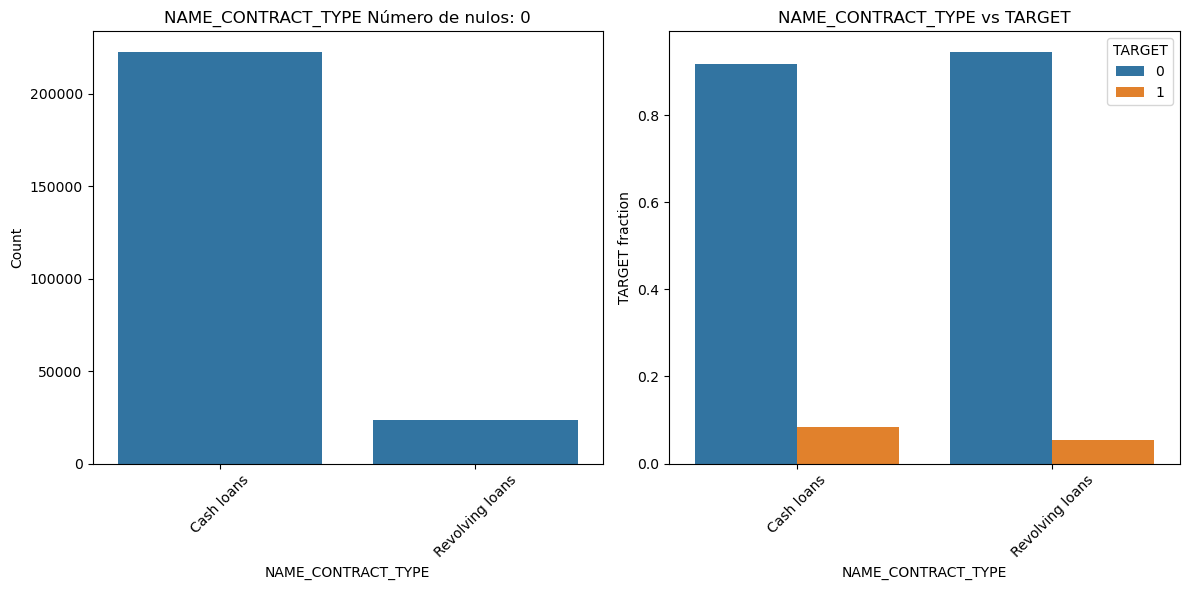

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



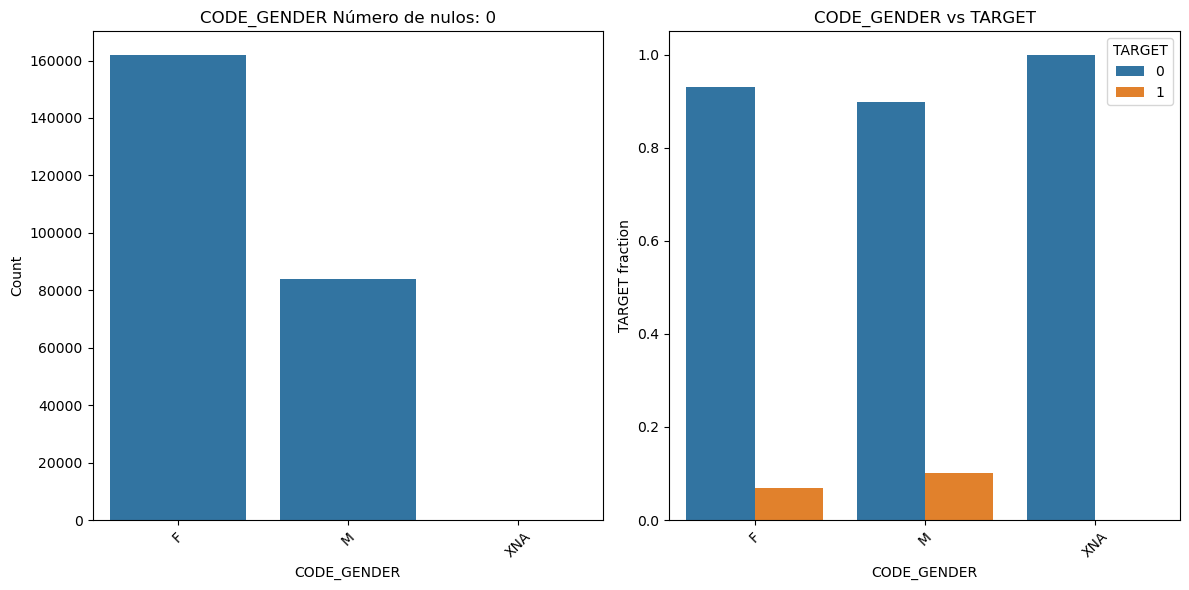

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



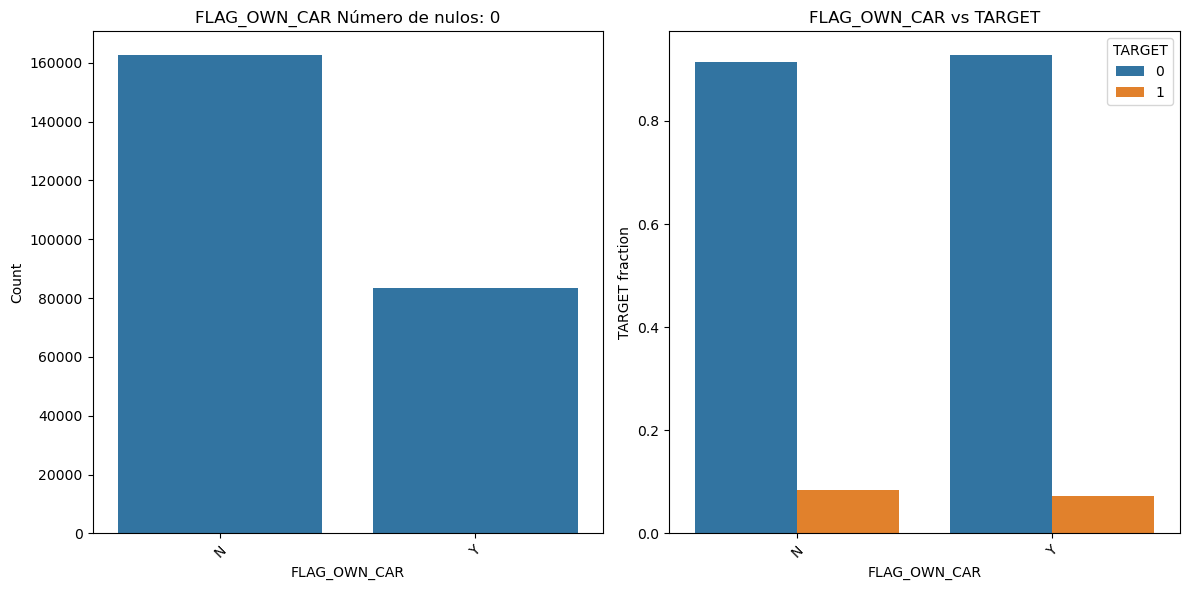

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



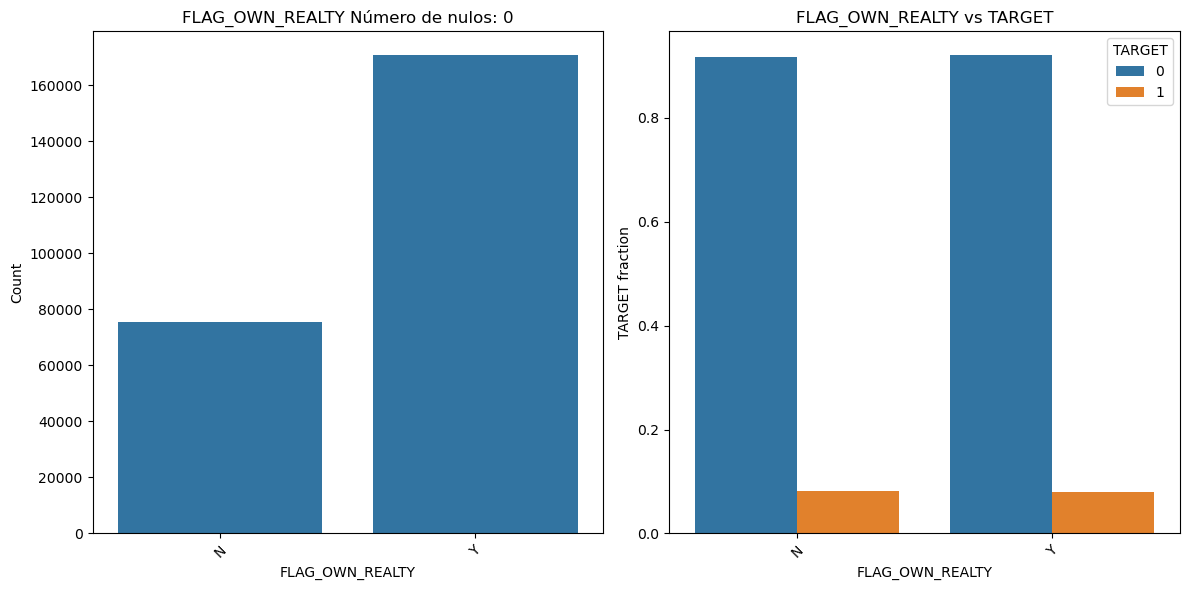

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



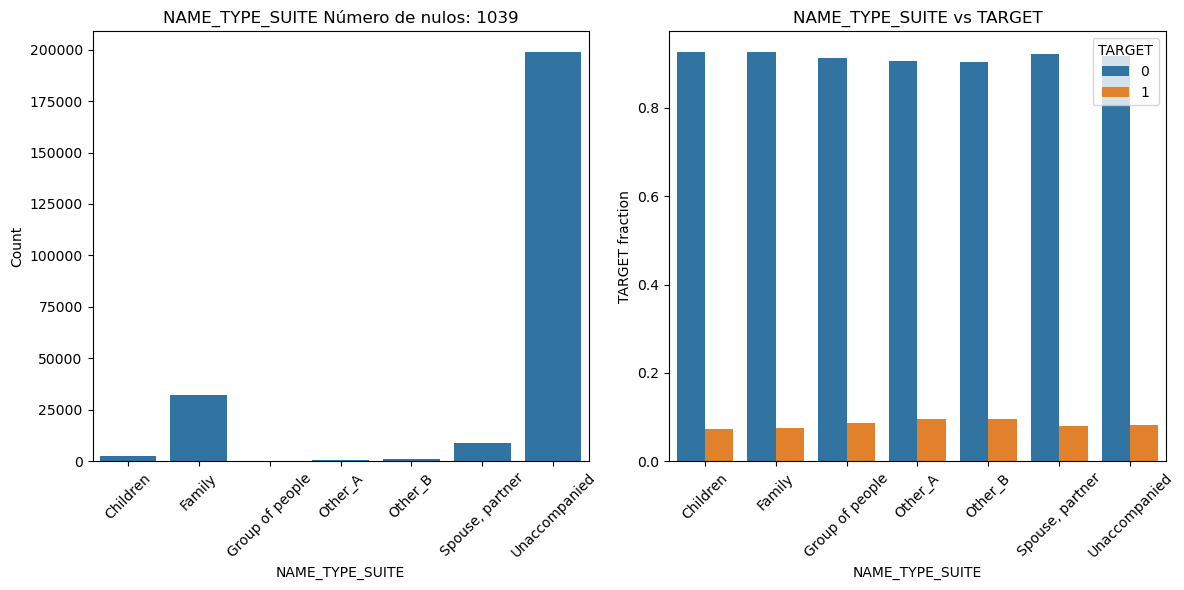

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



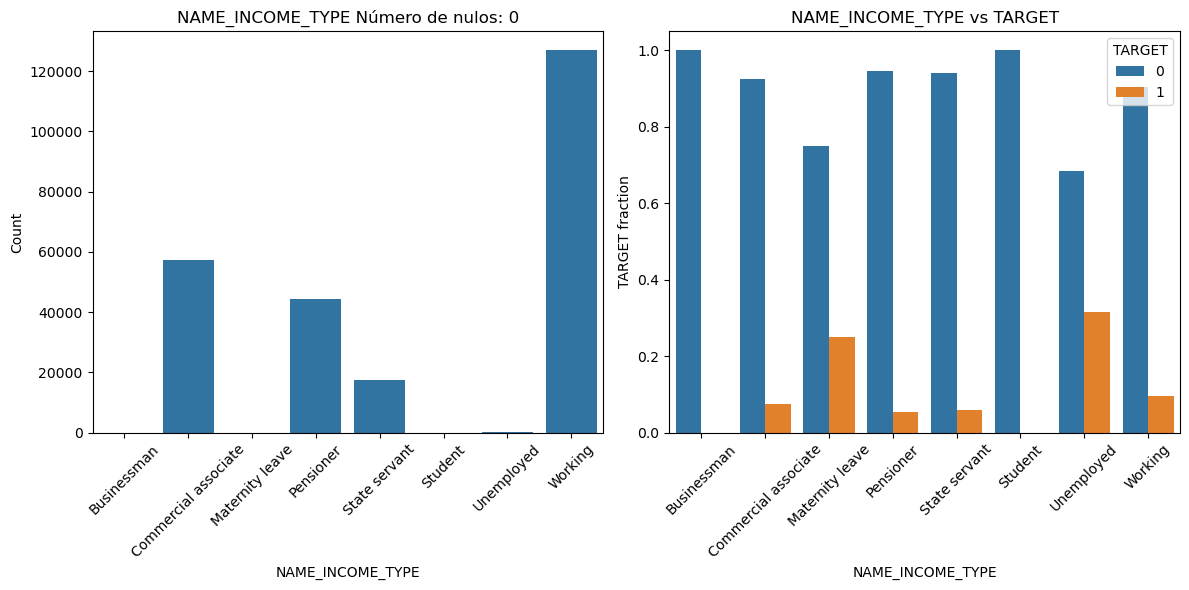

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



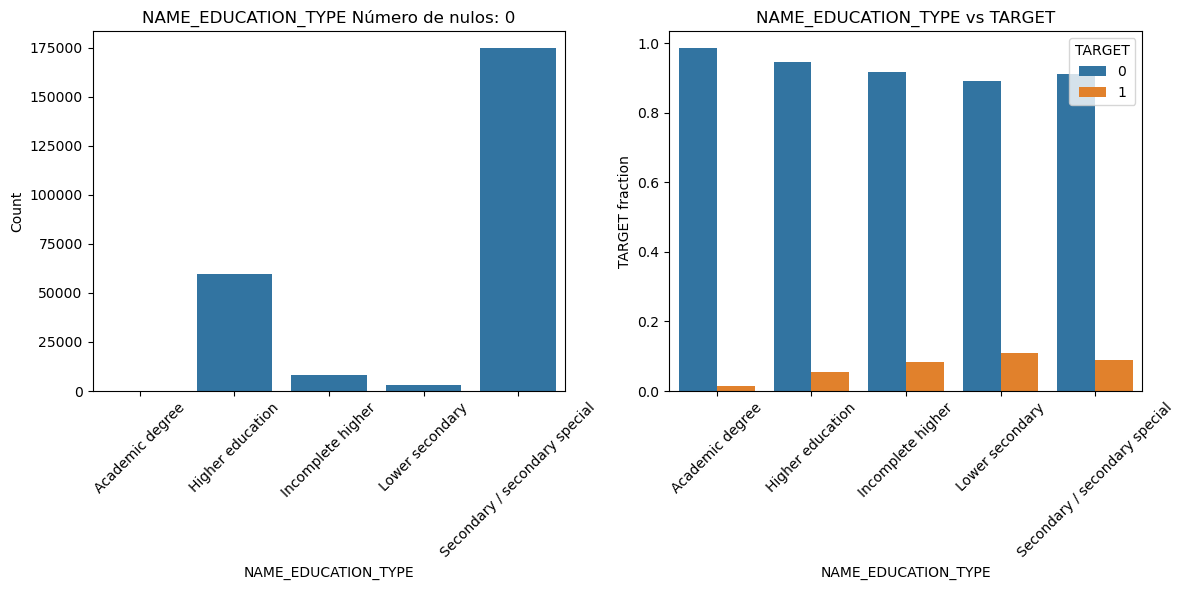

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



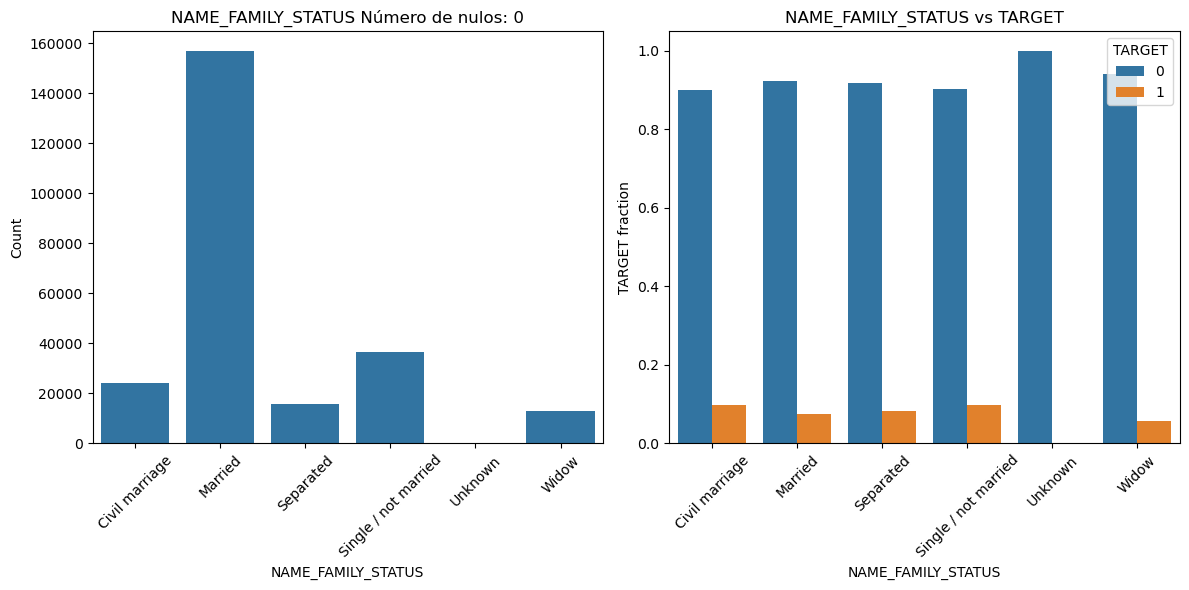

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



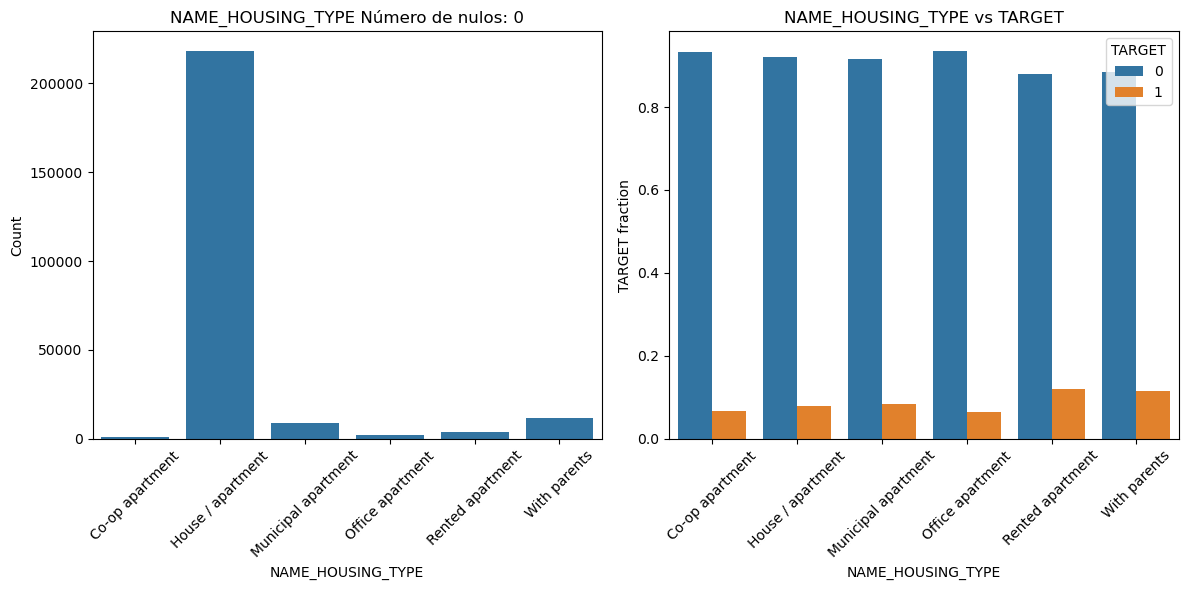

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



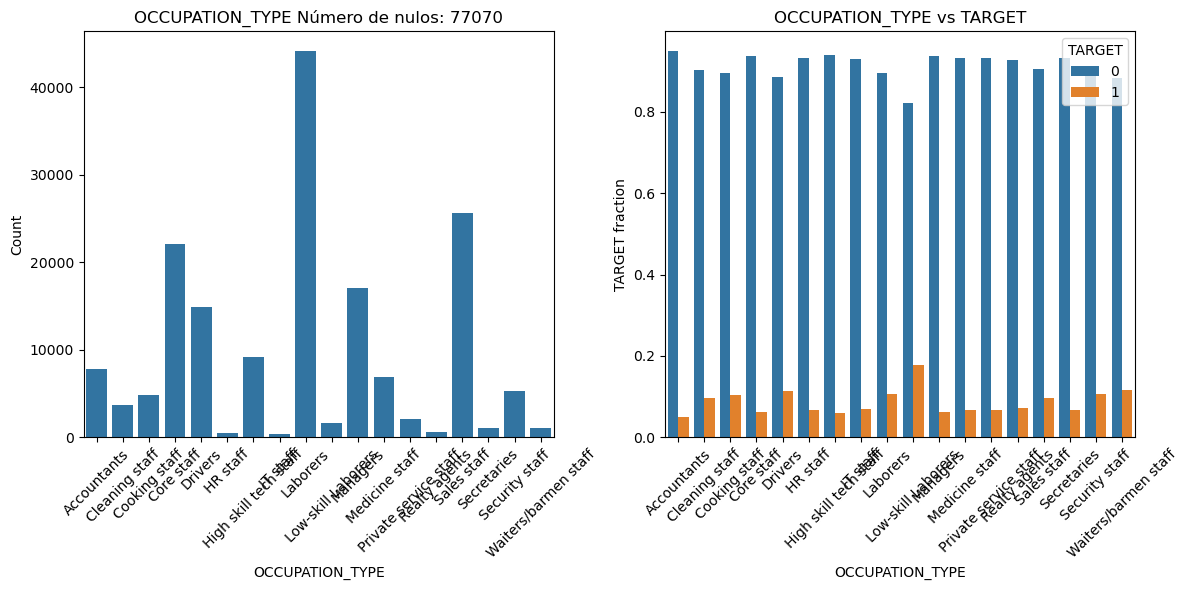

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



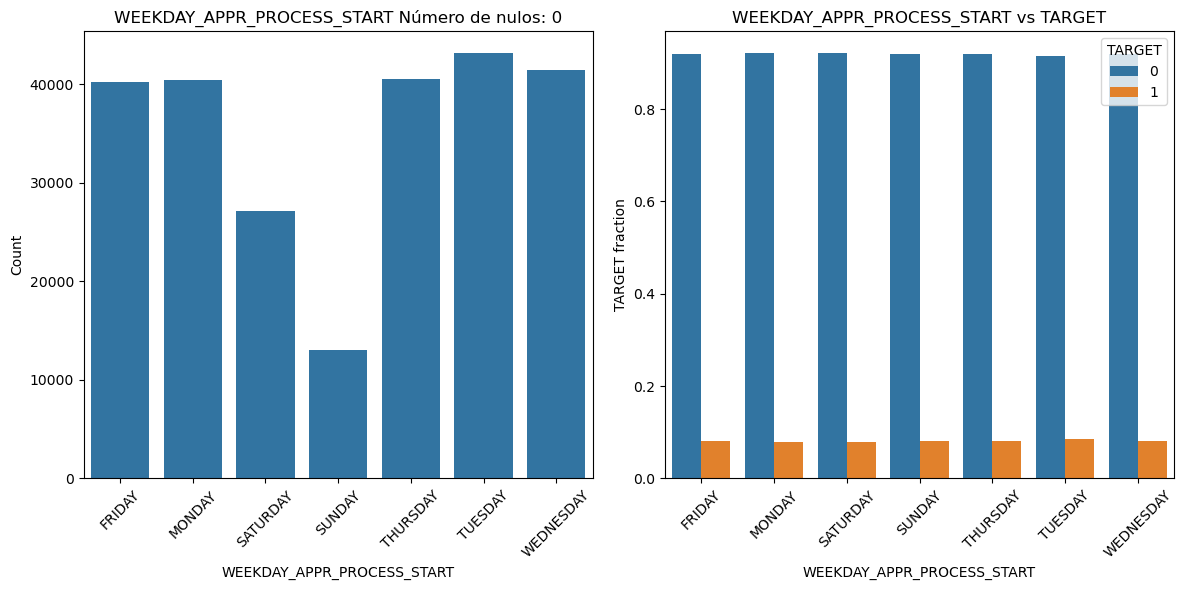

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



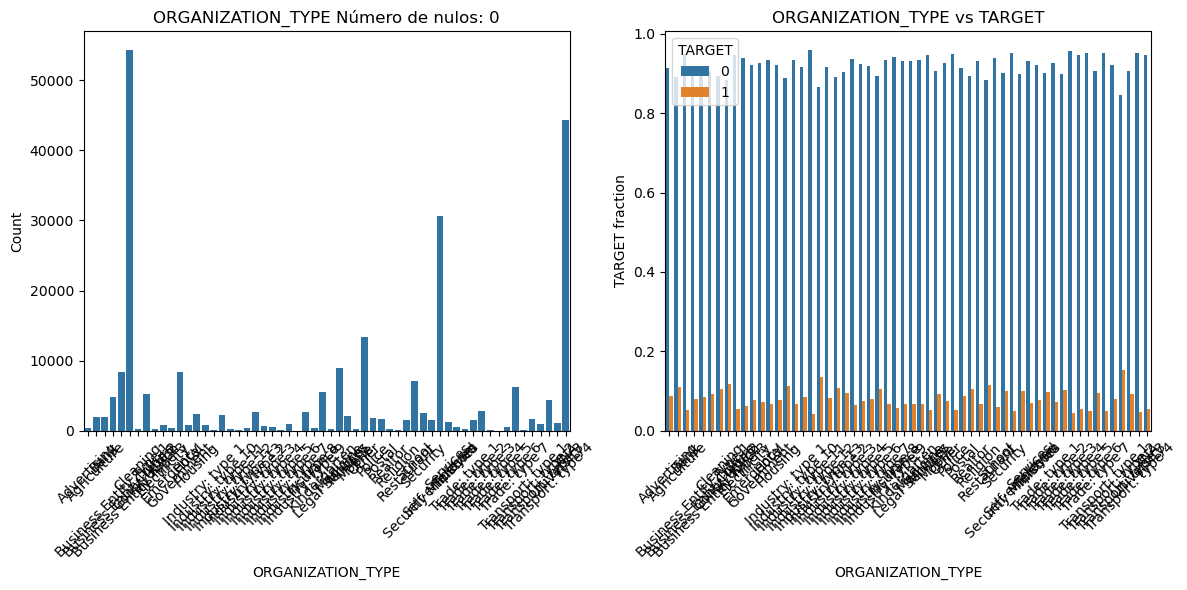

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



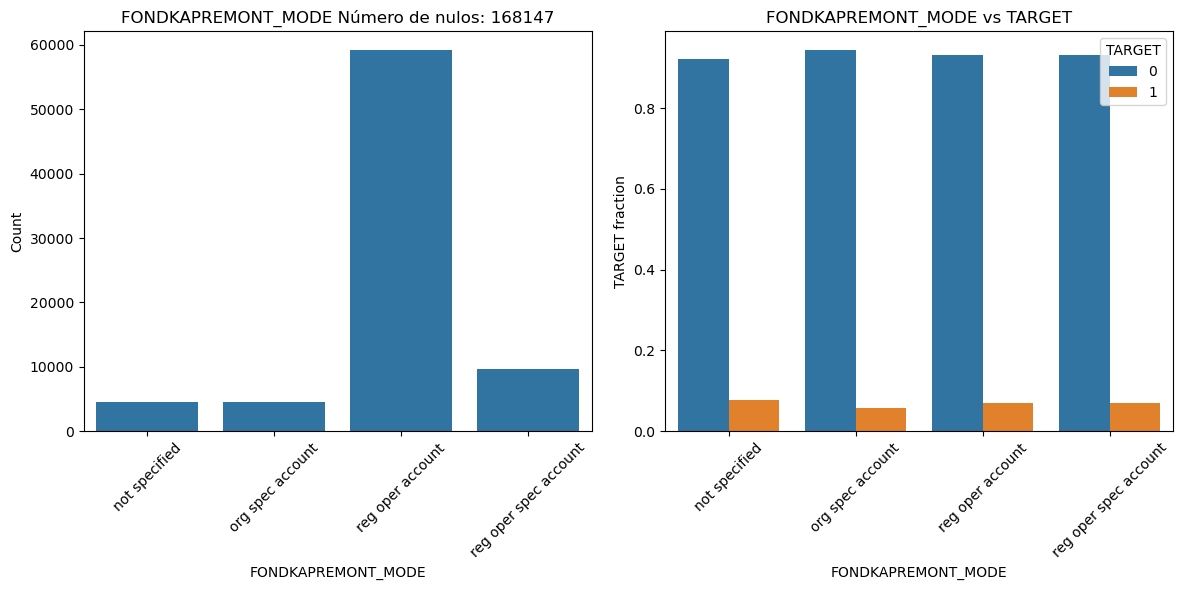

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



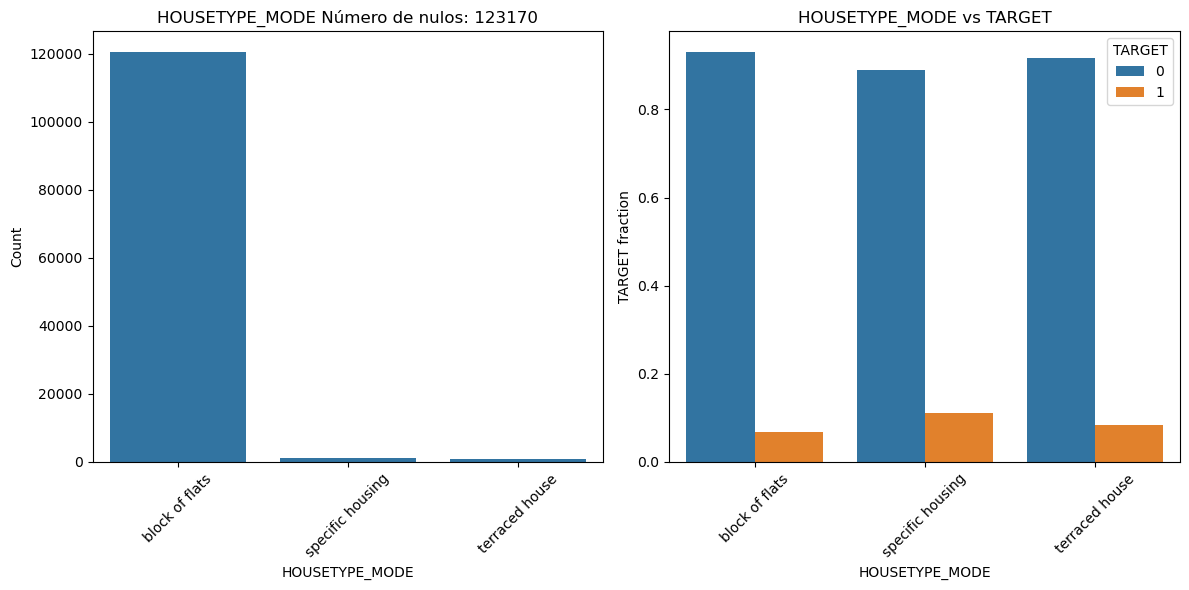

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



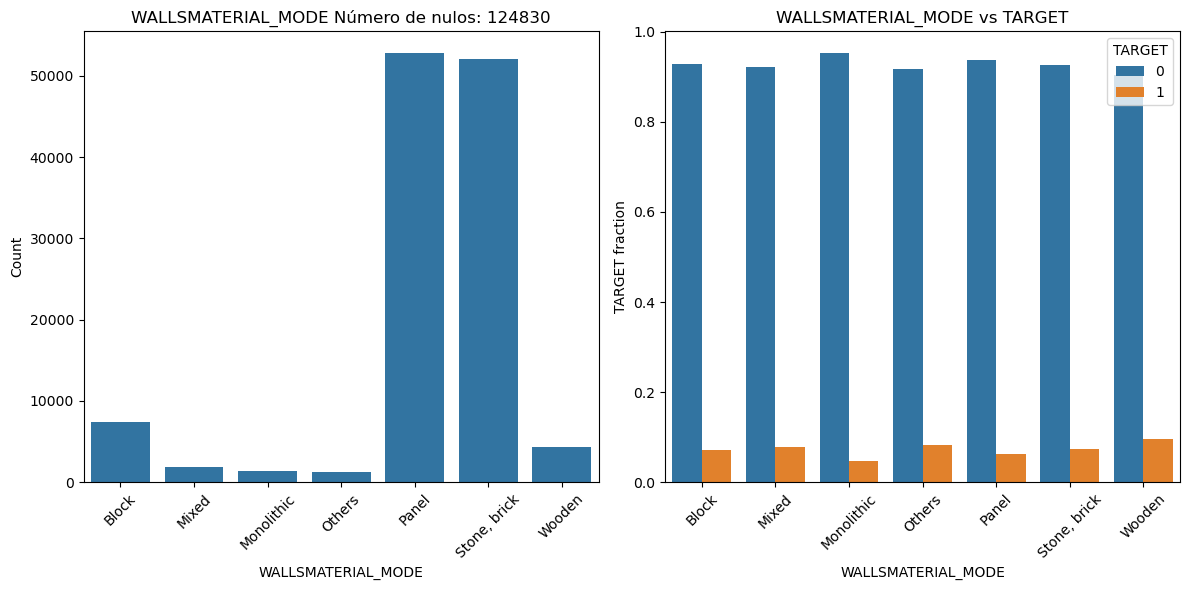

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



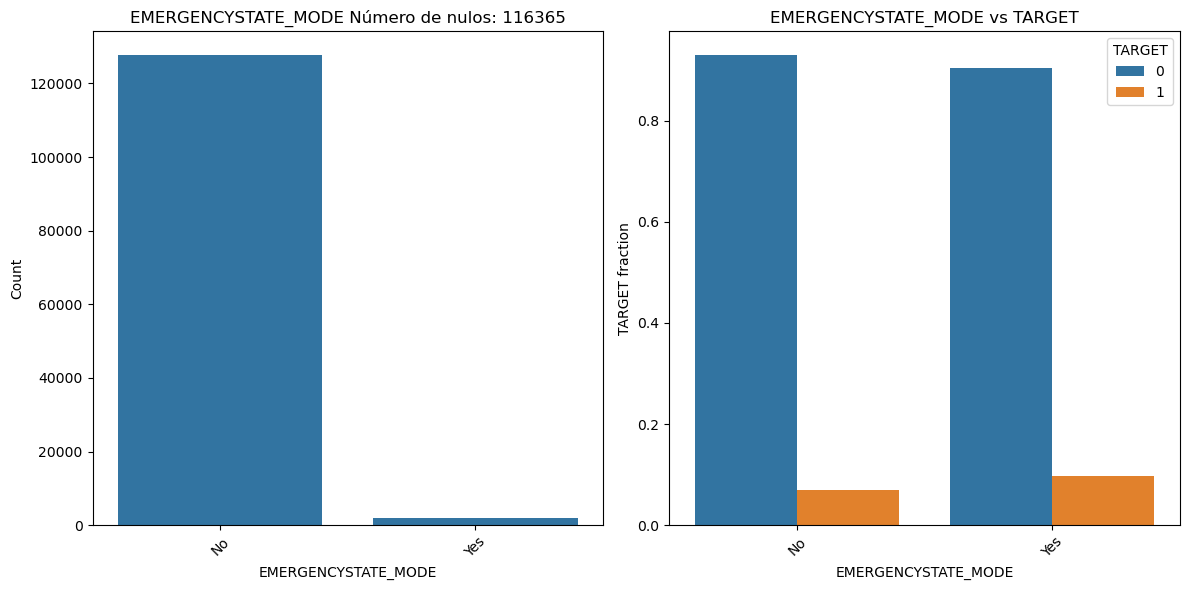

In [13]:
#Realizamos un bucle para las variables categóricas

for variable in list_var_cat:
    if variable != "TARGET":
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Gráfico de conteo
        sns.countplot(data=pd_loan_train, x=variable, ax=axes[0])
        axes[0].set_title(f'{variable} Número de nulos: {pd_loan_train[variable].isna().sum()}')
        axes[0].set_ylabel('Count')

        # Rotar etiquetas del eje X
        axes[0].tick_params(axis='x', rotation=45)

        # Para cada categoría: gráfico de fracciones
        pd_loan_df = pd_loan_train.groupby([variable, 'TARGET']).size().reset_index(name='count')
        pd_loan_df['fraction'] = pd_loan_df['count'] / pd_loan_df.groupby(variable)['count'].transform('sum')

        sns.barplot(data=pd_loan_df, x=variable, y='fraction', hue='TARGET', ax=axes[1])
        axes[1].set_title(f'{variable} vs TARGET')
        axes[1].set_ylabel('TARGET fraction')

        # Rotar etiquetas del eje X
        axes[1].tick_params(axis='x', rotation=45)

        # Ajustar diseño
        plt.tight_layout()
        plt.show()

A partir de estos gráficos, podemos ver a la izquierda el número de valores nulos para cada categoría de las variables, y en el de la derecha, cómo se distribuye una variable en función de la variable TARGET. Por lo general, vemos que los datos están bastante desbalanceados, pues hay muchas variables que no vemos que tengan un impacto fuerte en el impago del préstamo. A continuación, vamos a comentar algunas variables que puedan ser significativas en el impago del préstamo.

NAME_INCOME_TYPE (Situación laboral del solicitante)
En el gráfico de la izquierda vemos que la mayoría de los datos se asocian con 'Working', es decir, personas que tienen un empleo. Otras categorías presentan también una parte de los datos, como 'Pensioner' o 'Commercial Associate'. Otras categorías como 'Student' o 'Unemployed' presentan muy poca distribución de los datos, o ninguna. En el gráfico de la derecha, que muestra la fracción de incumplimiento para cada categoría, vemos que las personas desempleadas o las que están de baja por maternidad, tienen un porcentaje alto de incumplimiento. Los desempleados parece lógico, pues se asocia con la falta de un trabajo estable. Otras categorías como los pensionistas o los trabajadores presentan un grado bajo de incumplimiento, pues están asociados con un salario o pensión.

NAME_EDUCATION_TYPE(Nivel de educación)
En el gráfico de la izquierda vemos que los datos se distribuyen sobre todo en clientes que tienen 'Secondary/Secondary Special', seguidos de 'Higher Education'. 'Academid degree' o 'Lower Secundary' son menos comunes.En el gráfico de la derecha se muestra las fracciones de incumplimiento para cada nivel educativo. Como vemos, secundaria, secundaria especial o secundaria baja son los niveles que más probabilidad de incumplimiento tienen, algo que puede estar relacionado por el tipo de empleo que estos clientes tienen, asociado con la baja formación académica recibida. Los clientes con un grado o educación superior presentan menor riesgo de incumplimiento, algo que también puede estar relacionado por el caso contrario al anterior.Podemos concluir que el nivel educativo influye en la capacidad de incumplimiento del solicitante.

NAME_HOUSING_TYPE(Tipo de vivienda)
En el gráfico de la izquierda vemos que la mayoría de los datos se asocian con clientes que vivene un apartameto o casa, que por otra parte es lo más normal. Otras categorías presentan una distribución de los datos mucho menor, como 'Municipal Apartment', 'With Parents' o 'Rented Apartment'. En cuanto a su relación con TARGET, vemos que la fracción de incumplimineto es algo mayor para aquellos solicitantes que viven con los padres o de alquiler. Esto puede estar relacionado con un menor grado de cumplimineto, pues los que viven con sus padres es posible que no tengan una ocupación, aunque también pueden ser aún jóvenes para independizarse. Aun así, no parece una variable muy significativa en cuanto al grado de incumplimiento del préstamo.

OCCUPATYON_TYPE (Tipo de trabajo)
Al observar la variable, vemos que presenta una buena cantidad de nulos que podríamos imputar para mejorar el análisis. En el gráfico de la izquierda, vemos que la mayoría de los solicitantes pertenecen a 'Laborers'(en mayor proporción), 'Core Staff' y 'Sales Staff'. Como vemos en el gráfico de la derecha, los trabajadores dedicados a actividades manuales o físicas como la construcción, fabricación, agaricultura, así como aquellos con una baja especialización, como por ejemplo, ayudante de obra, presentan mayor incumplimineto de devolver el préstamo. Otros gremios, como los conductores o los vigilantes de seguridad presentan un grado de incumplimiento menor, aunque mayor que el resto. Esto puede estar debido a la formación educativa, ya que estos trabajos no requieren de una cualificación para dedicarse a ellos. Podemos concluir que el tipo de ocupación puede influir en el grado de incumplimiento del préstamo.

CODE_GENDER(Género)
Como vemos en el gráfico de la izquierda, hay mayor proporción de clientes femeninos que masculinos.En el gráfico de la derecha no parece haber una diferencia extremadamente significativa entre el grado de incumplimineto de hombres y mujeres, aunque si nos fijamos el grado de incumplimiento mayor es ligeramente masculino. Esto puede deberse a muchas razones como el tipo de trabajo, mentalidad o tipo de educación, entre otras. En conclusión, esta variable tiene una relación moderada con la probabilidad de incumplkimiento, siendo importante considerar cómoa actúa con otras variables.

NAME_CONTRACT_TYPE (Tipo de contrato)
En el gráfico de la izquierda vemos que la mayoría de los préstamos pertenecen a 'Cash Loans', mientras que los 'Revolving Loans' tienen una proproción mucho menor. Con respecto a la variable TARGET, vemos que no hay una gran diferencia en la probabilidad de incumplimiento entre ambos préstamos, pero sí que es verdad que los 'Cash Loans' tienen una probabilidad mayor, cosa que tiene sentido al ser mucho más comunes en el día a día.

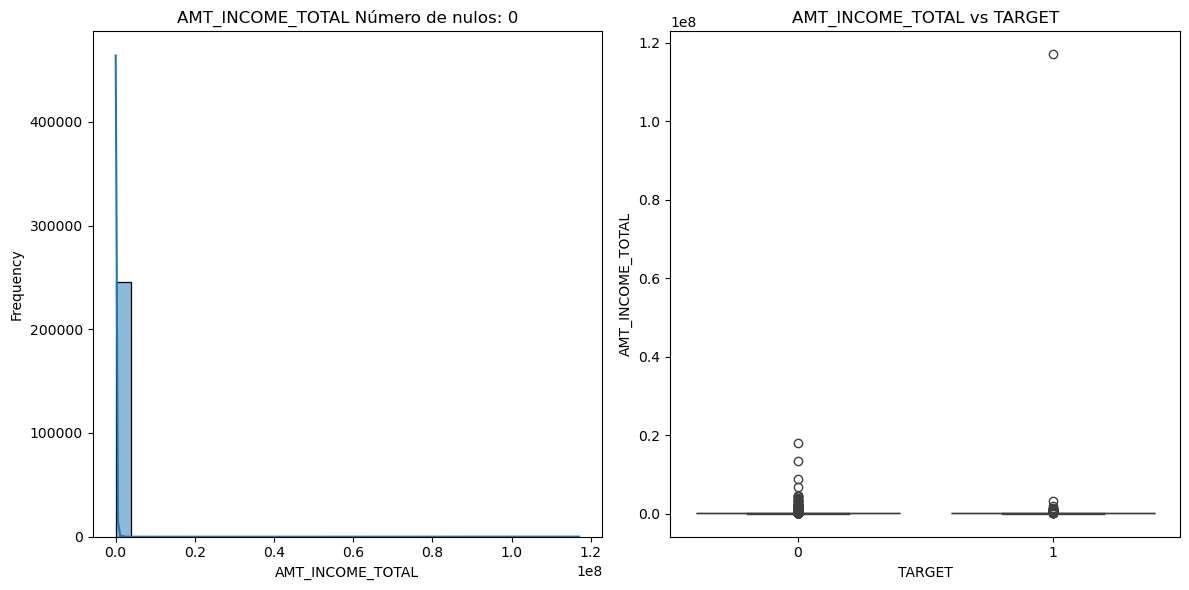

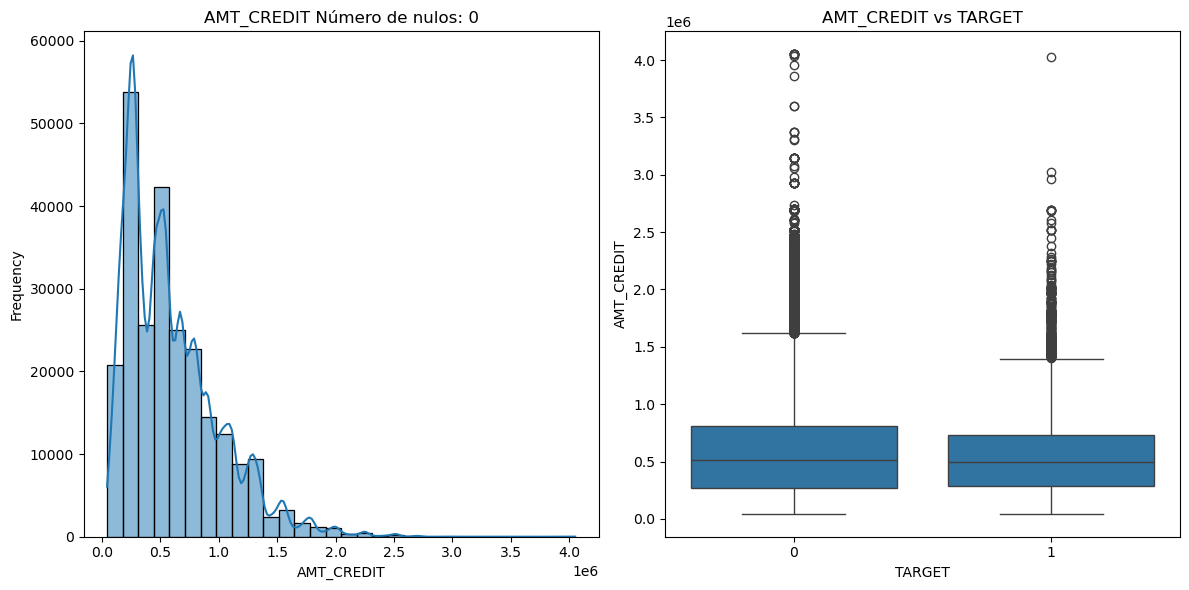

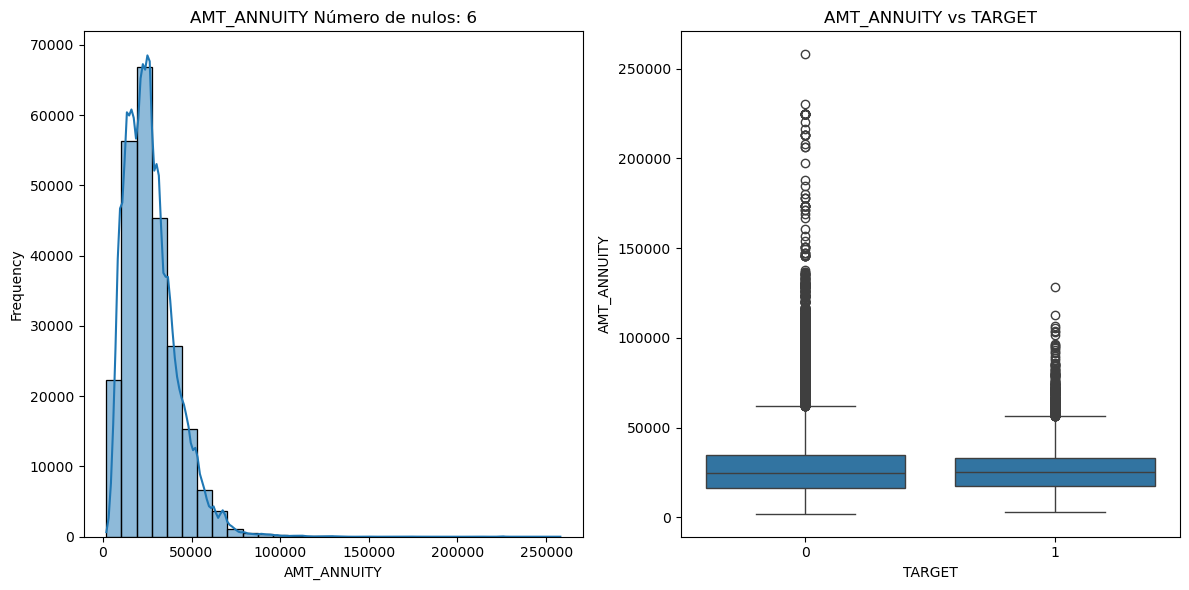

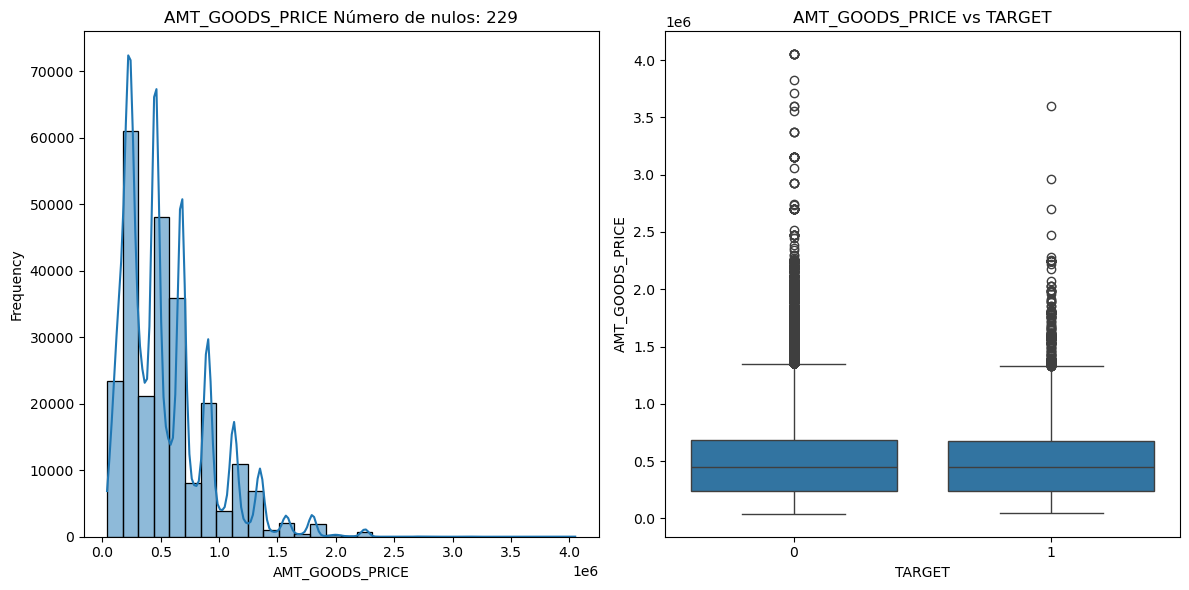

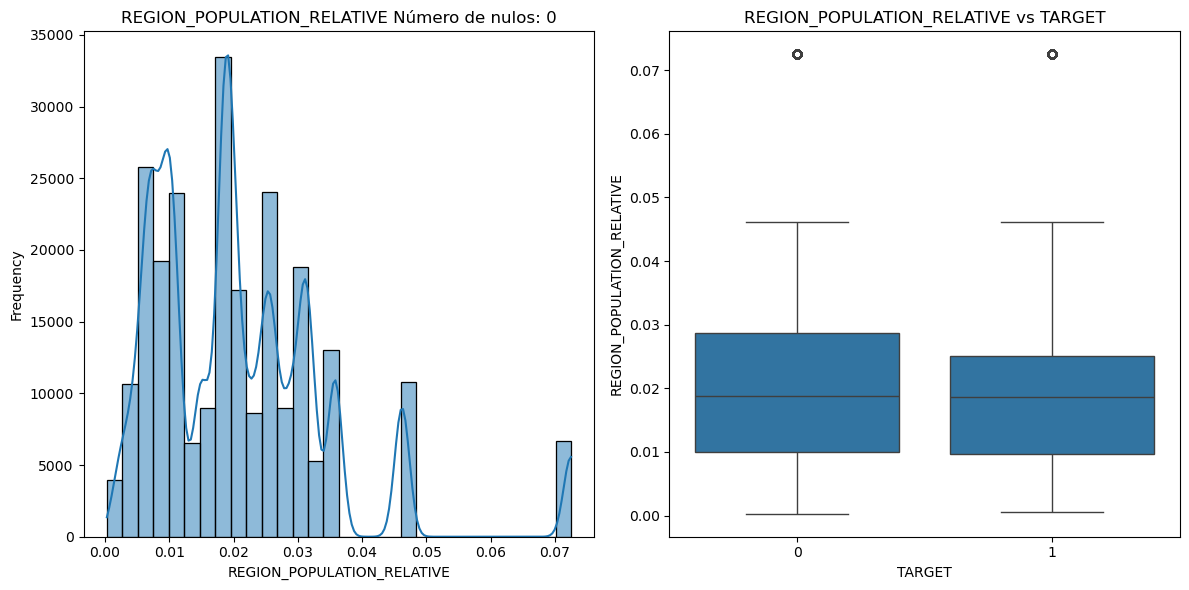

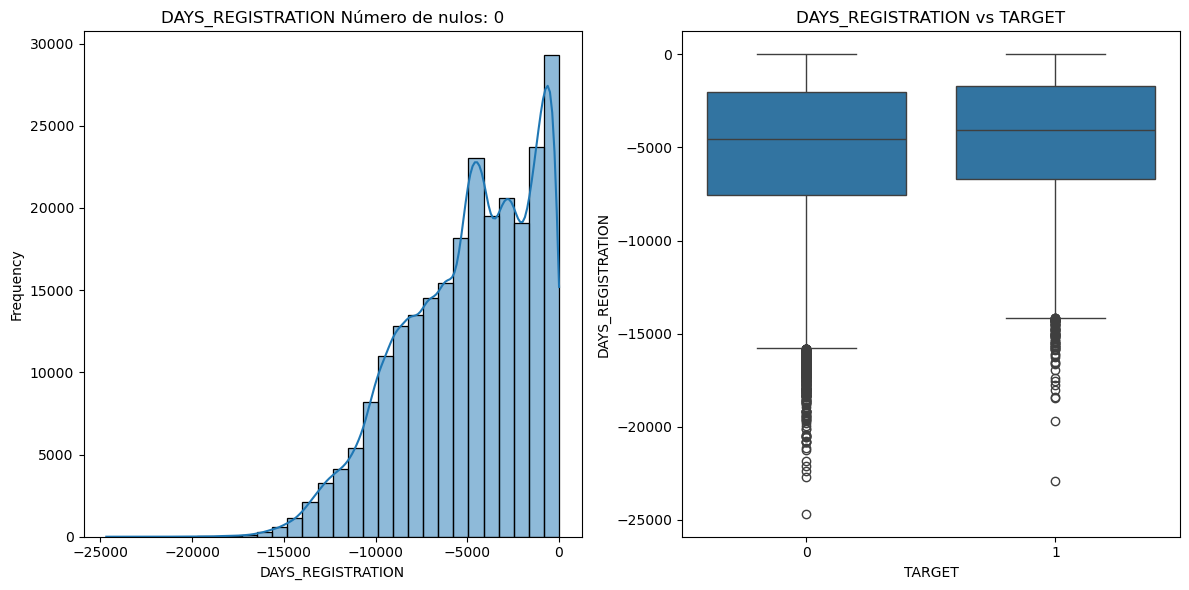

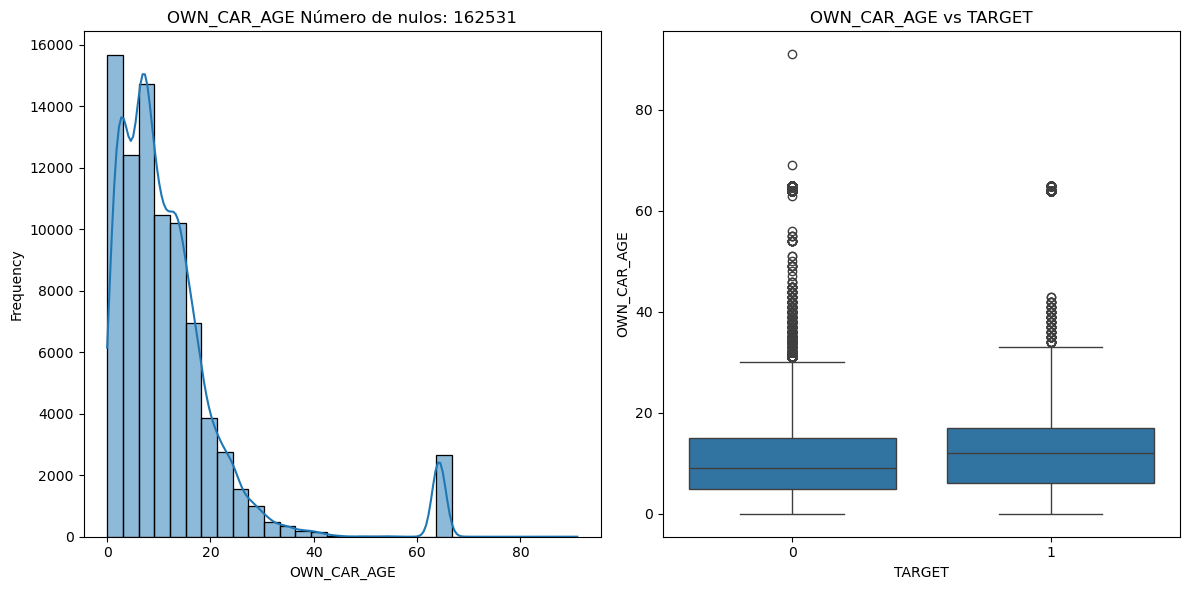

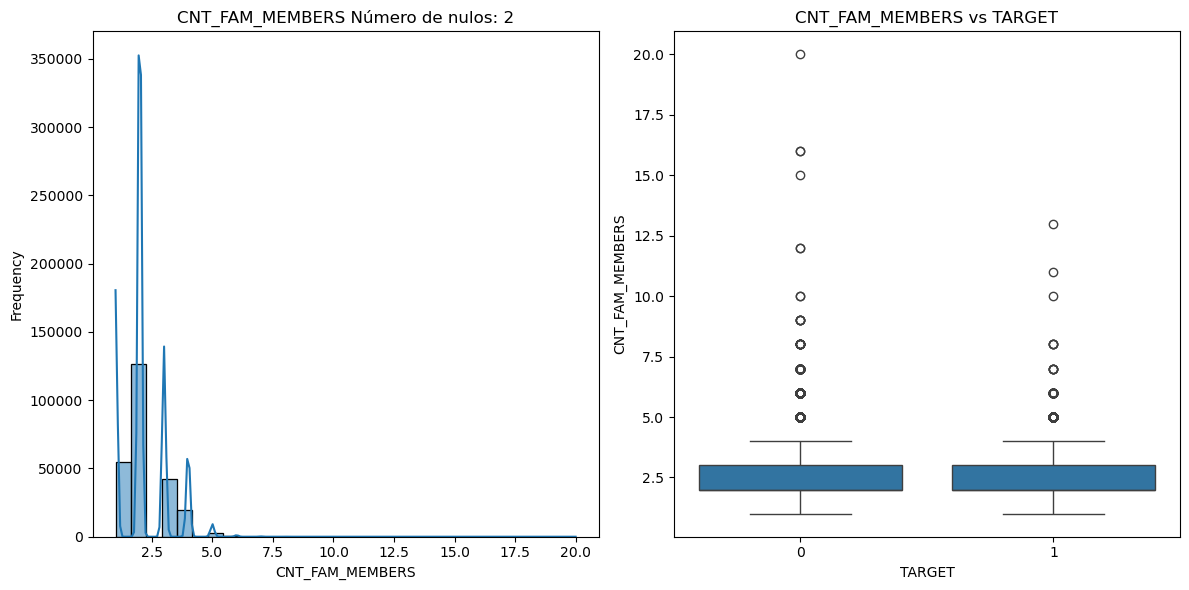

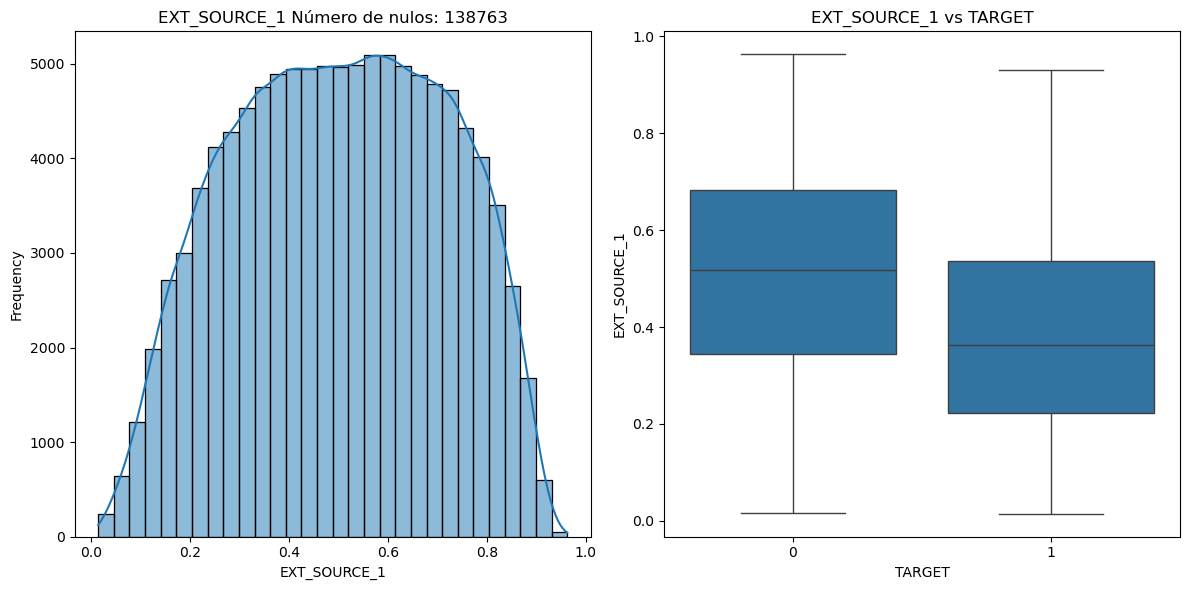

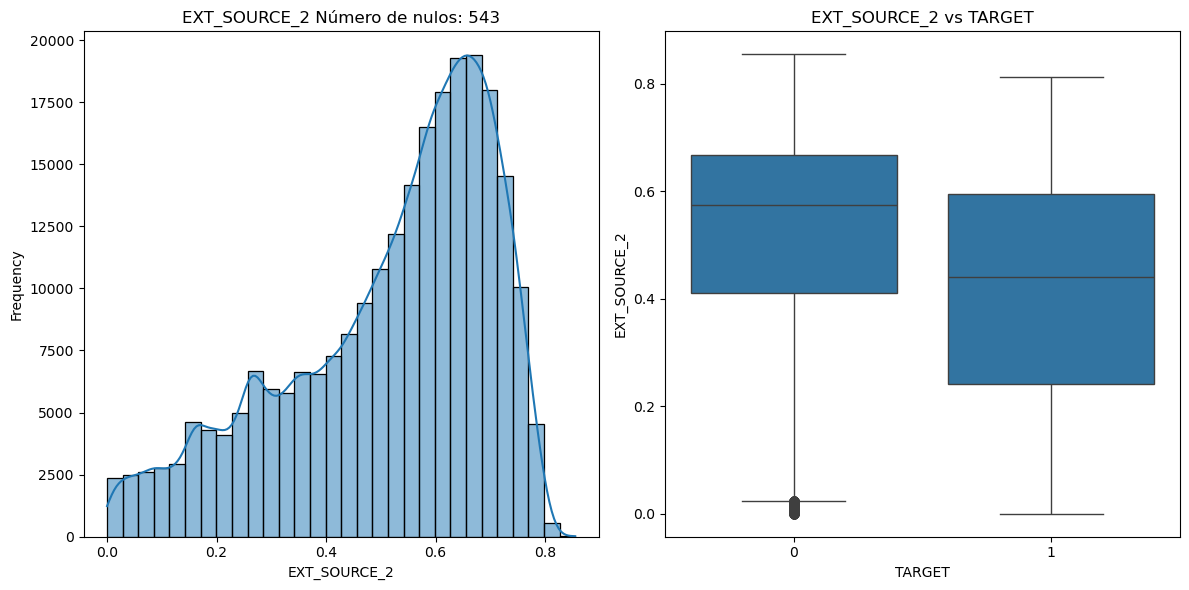

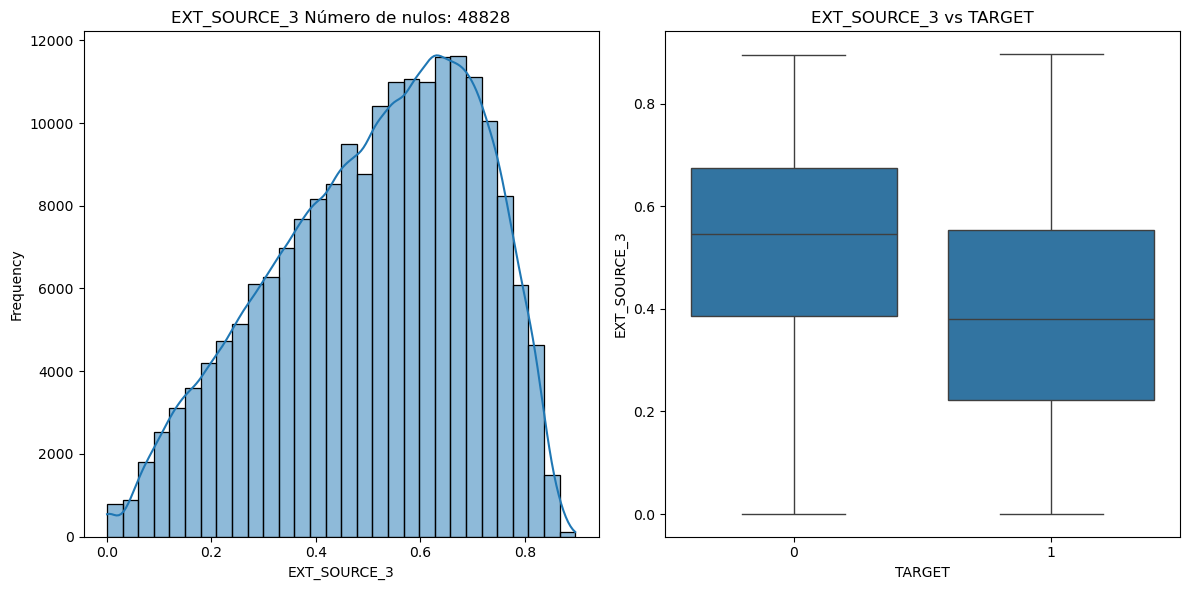

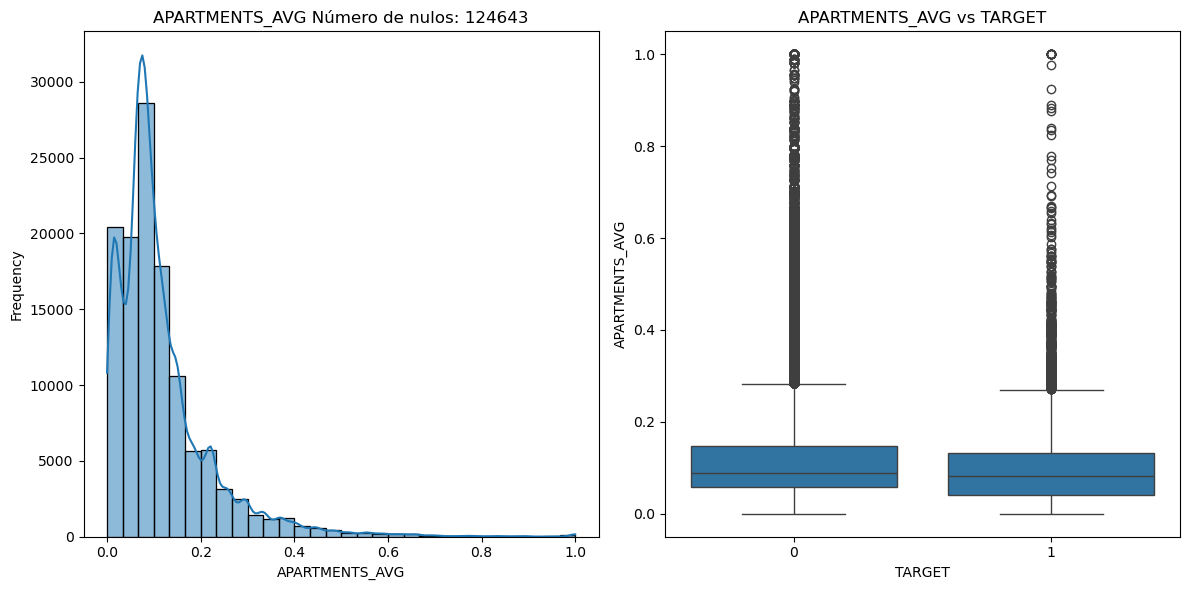

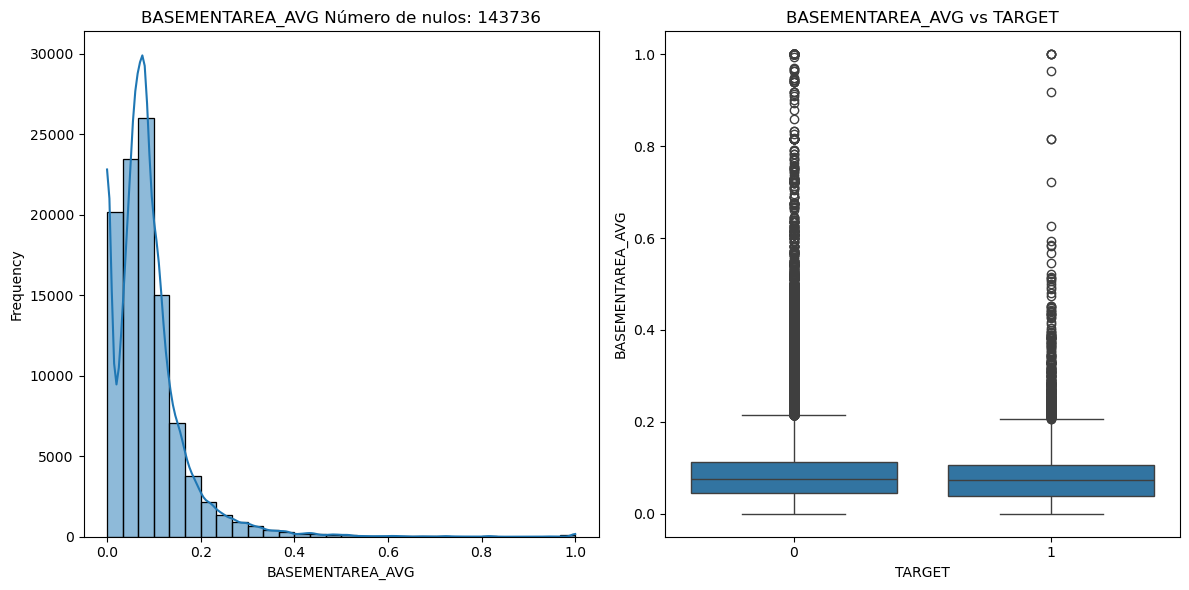

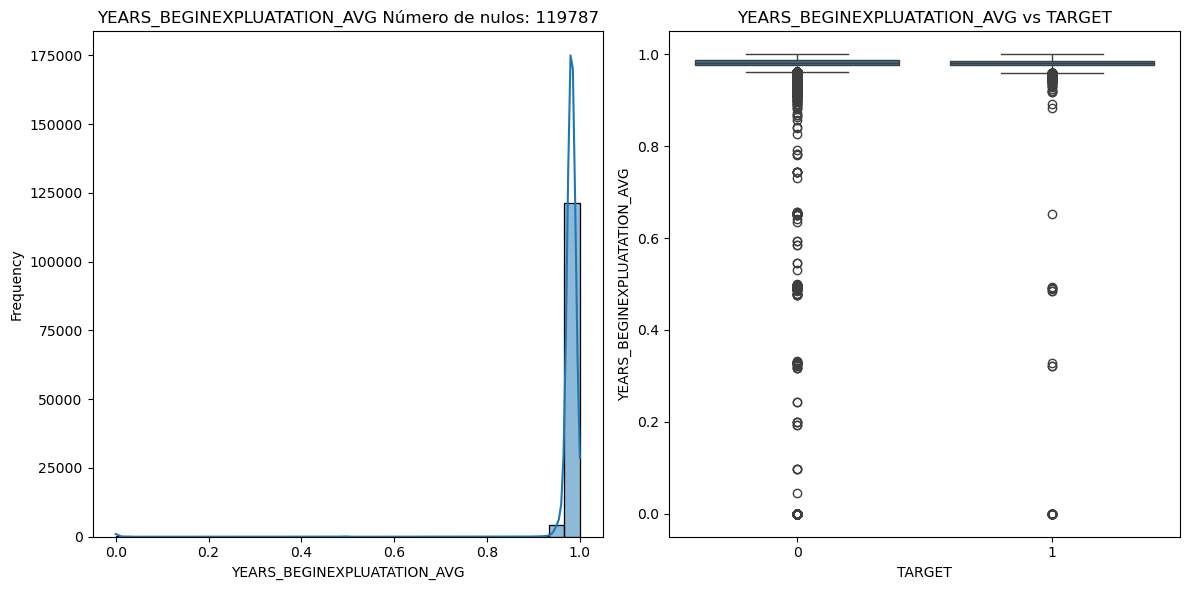

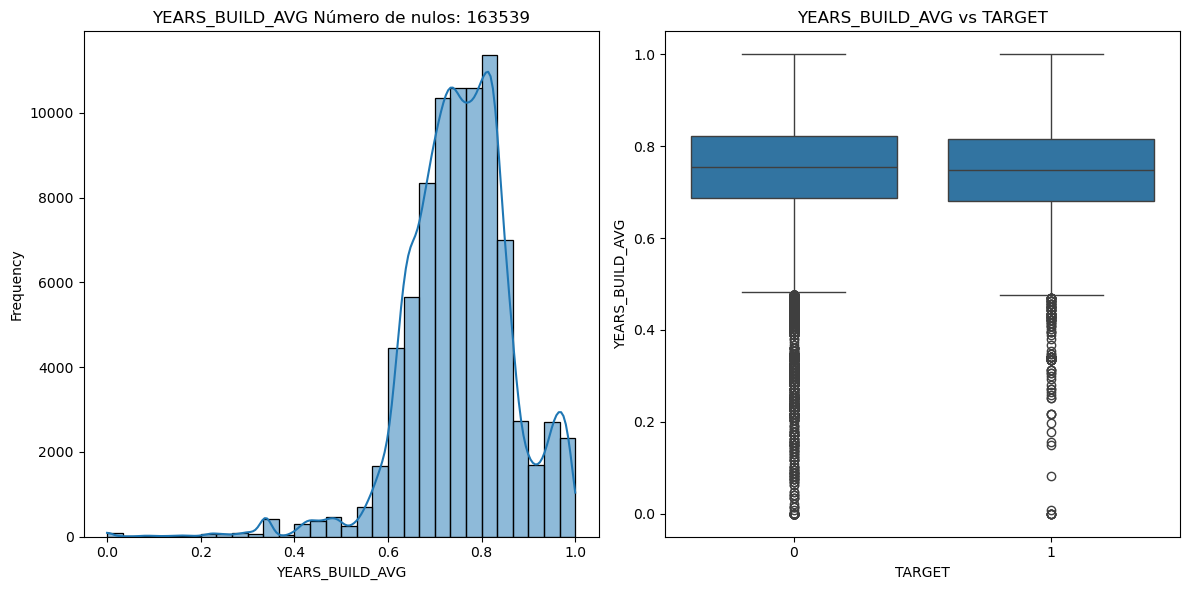

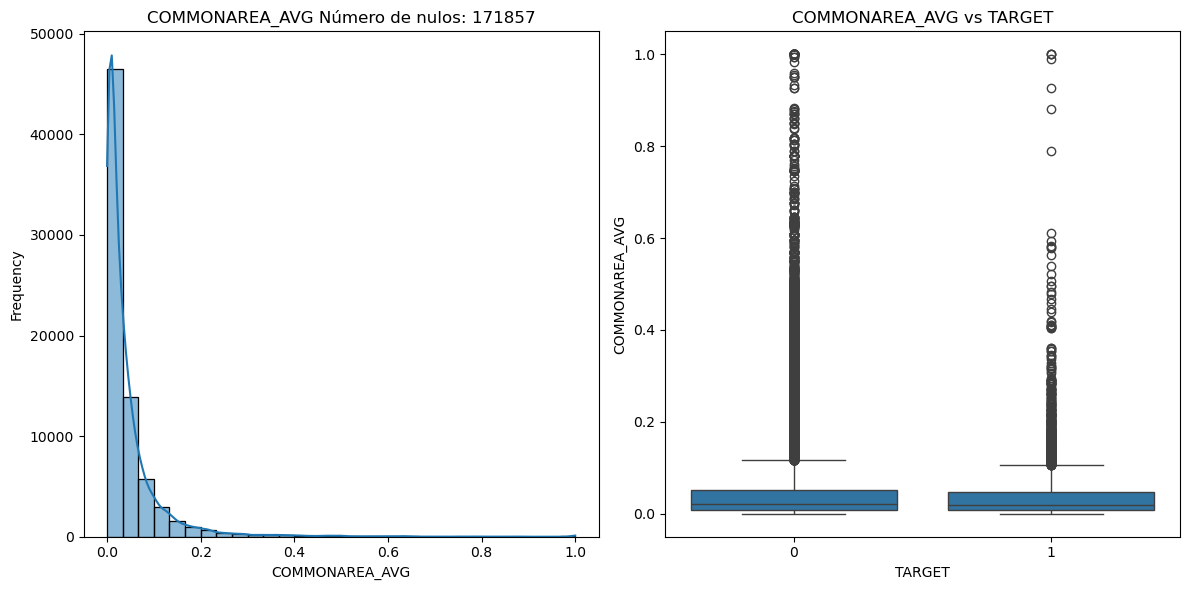

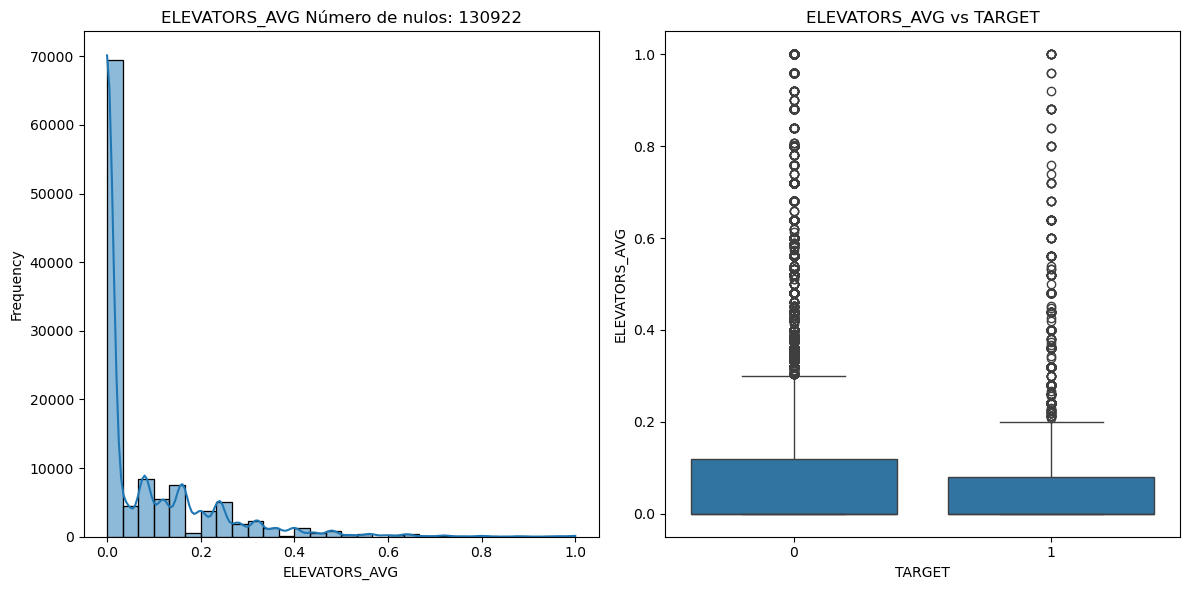

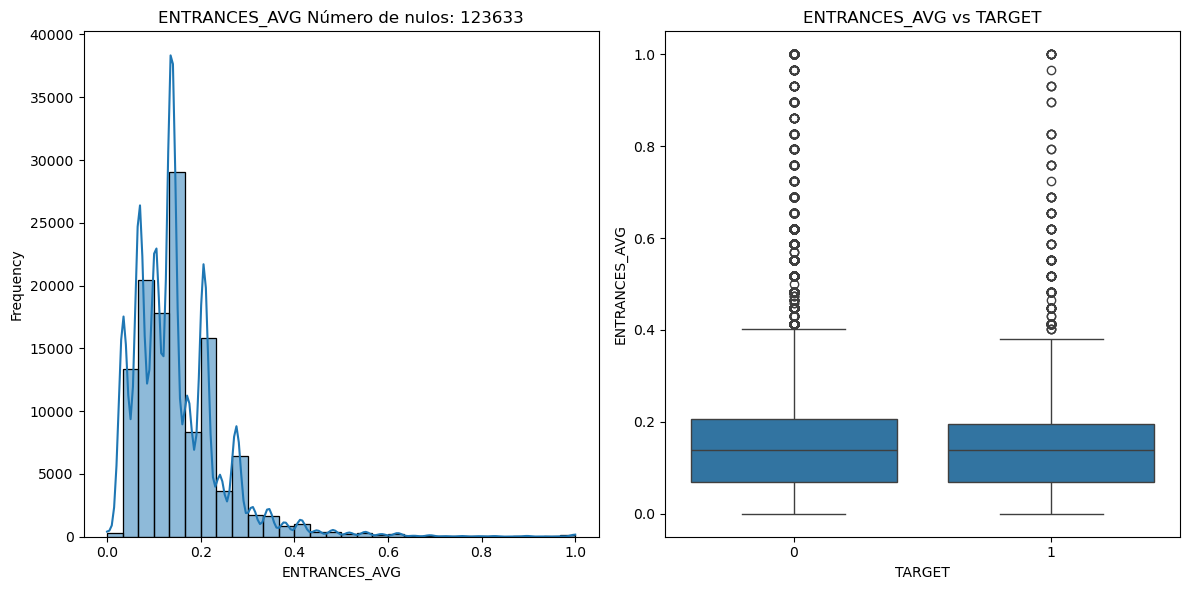

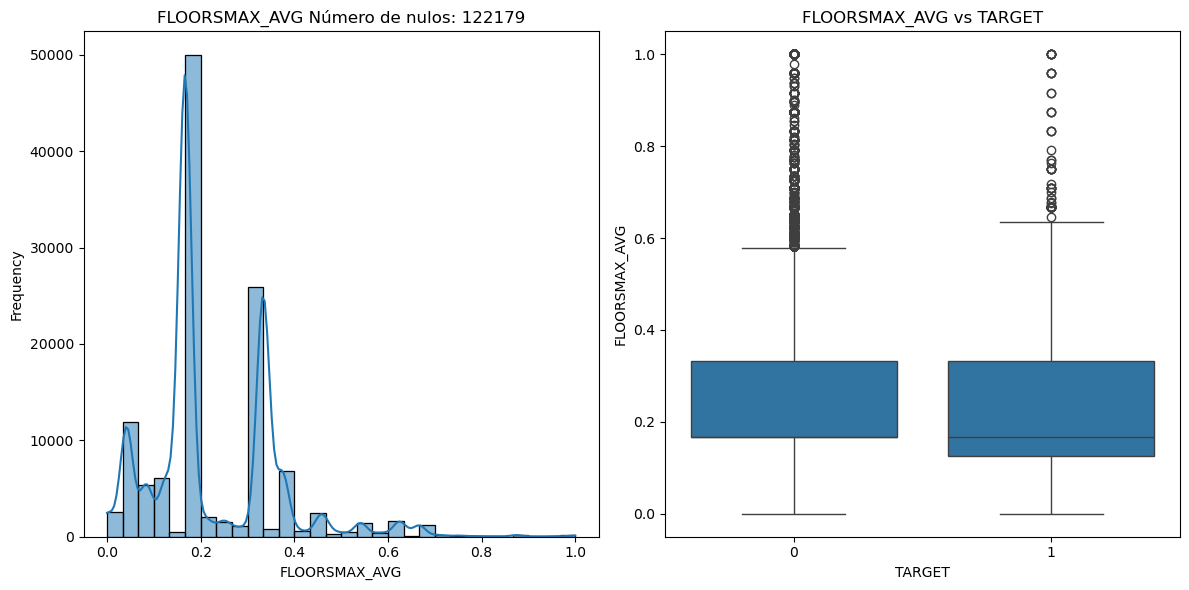

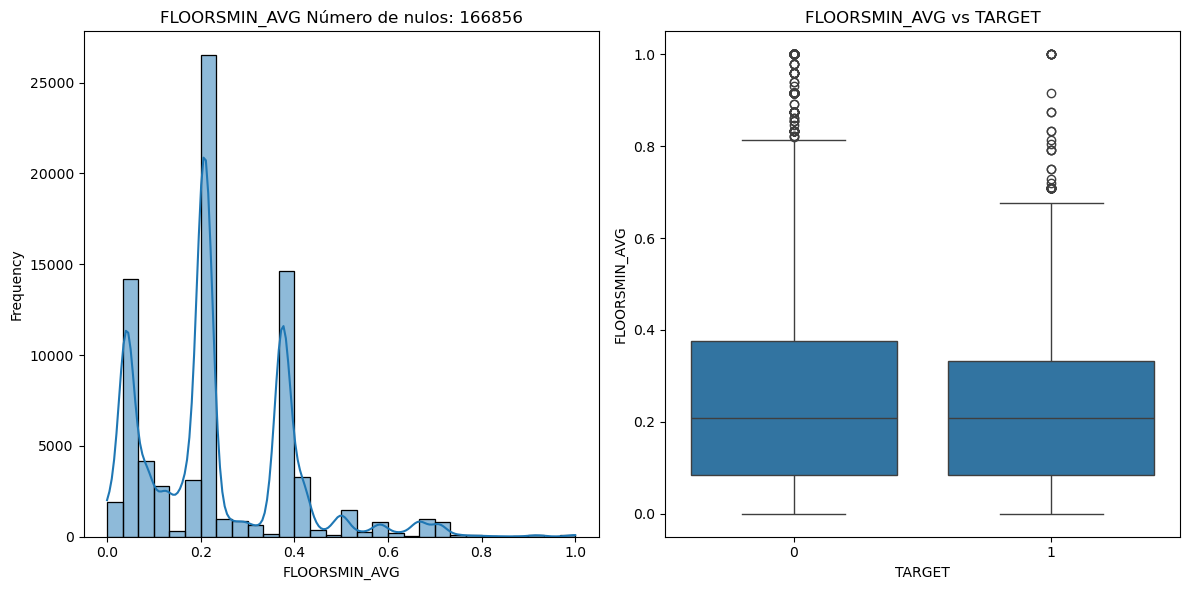

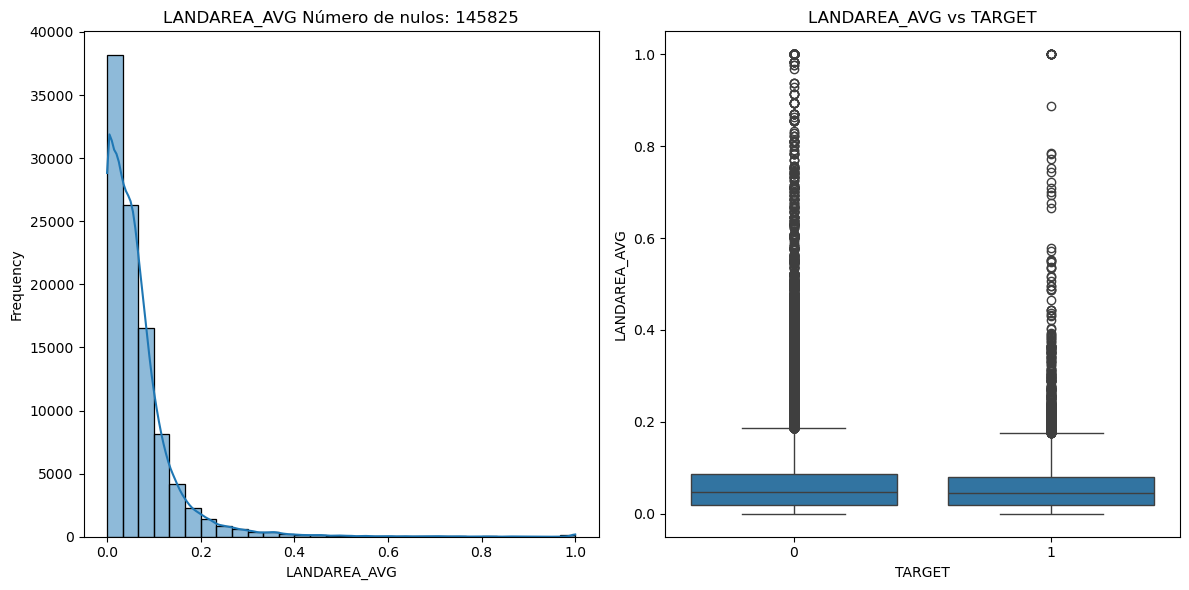

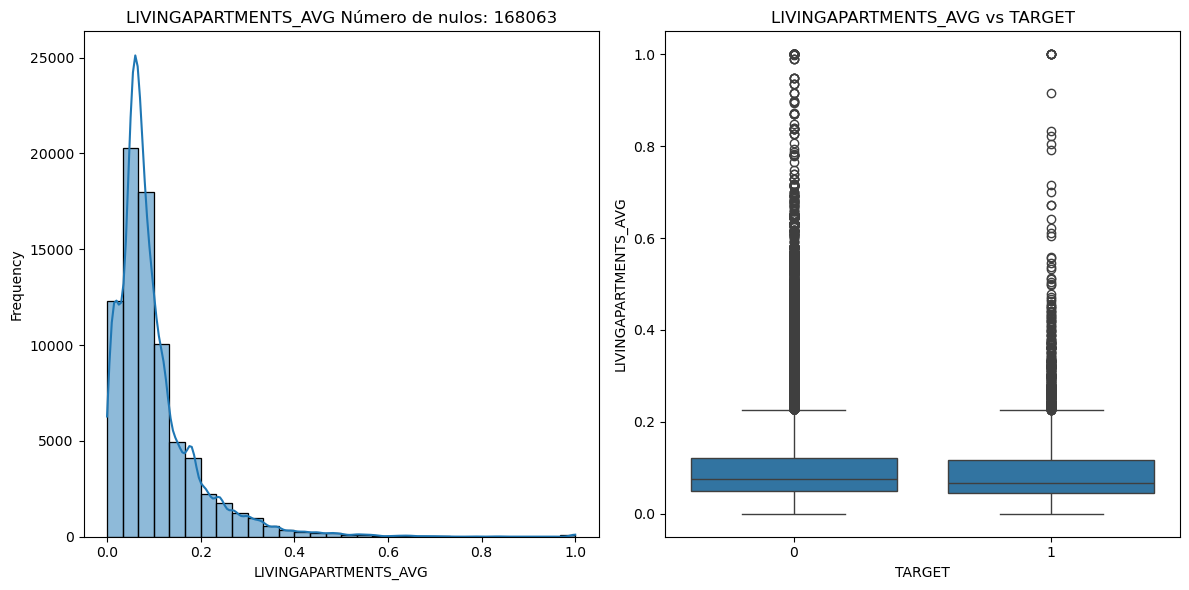

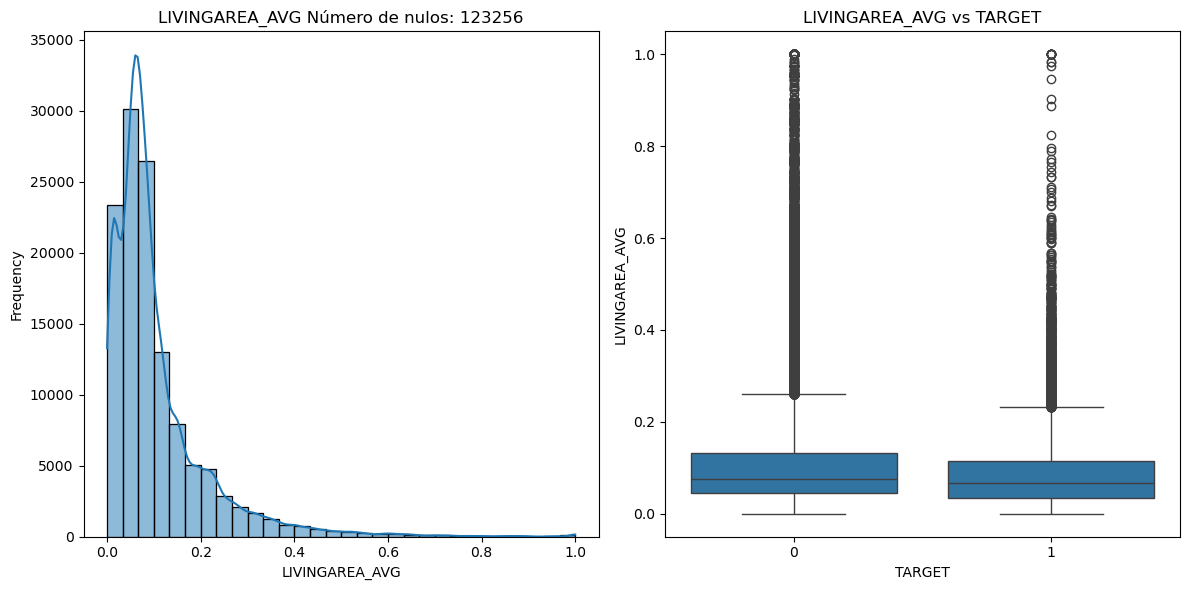

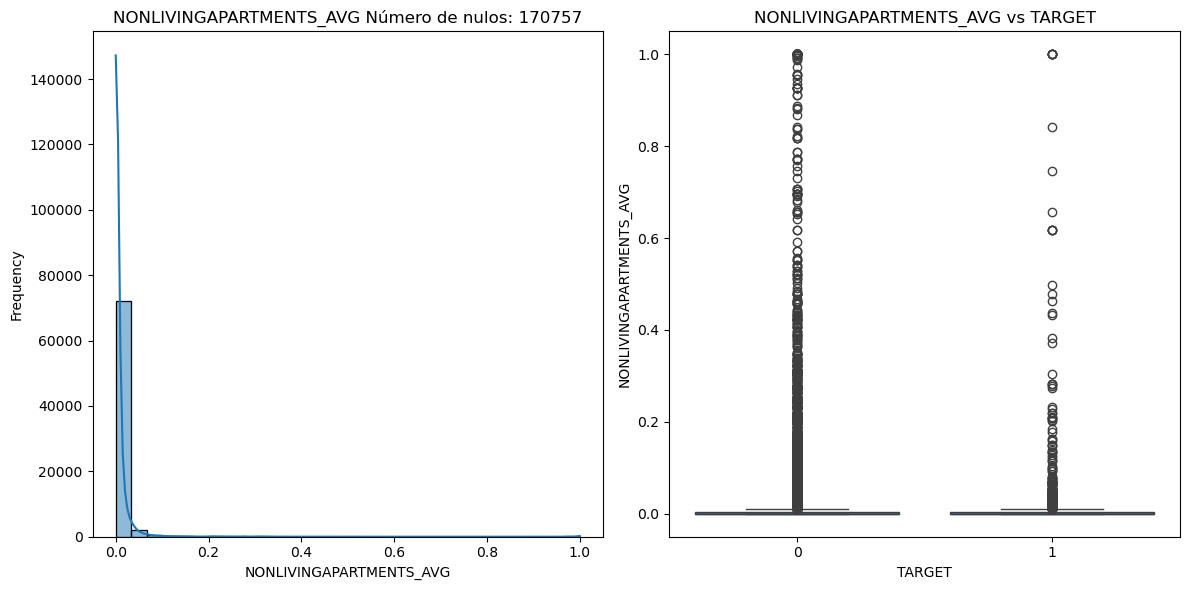

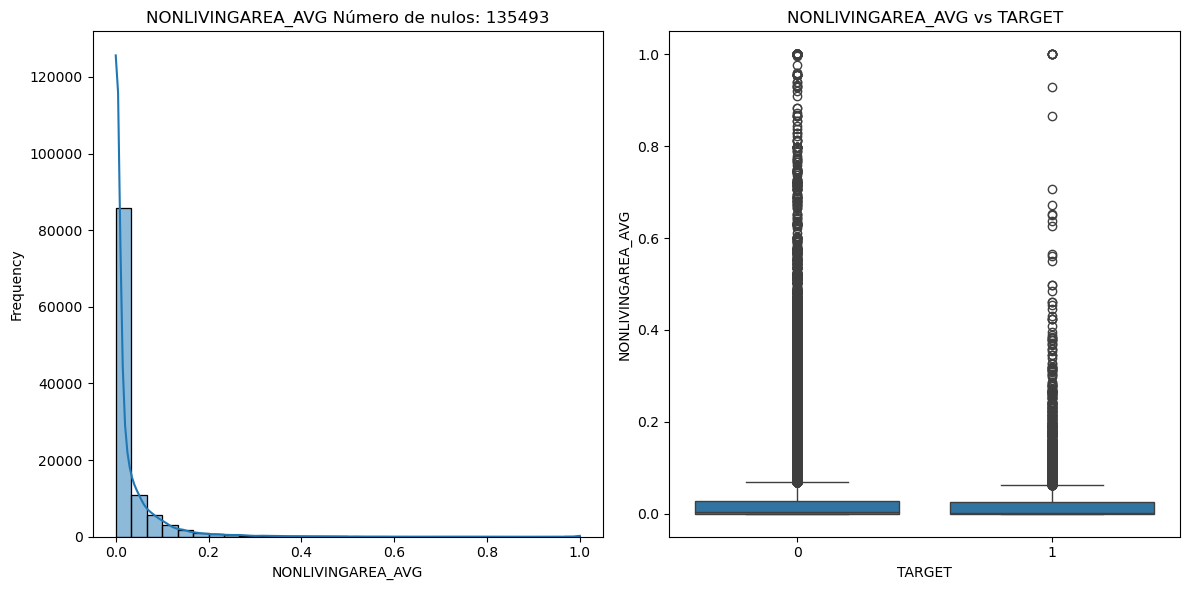

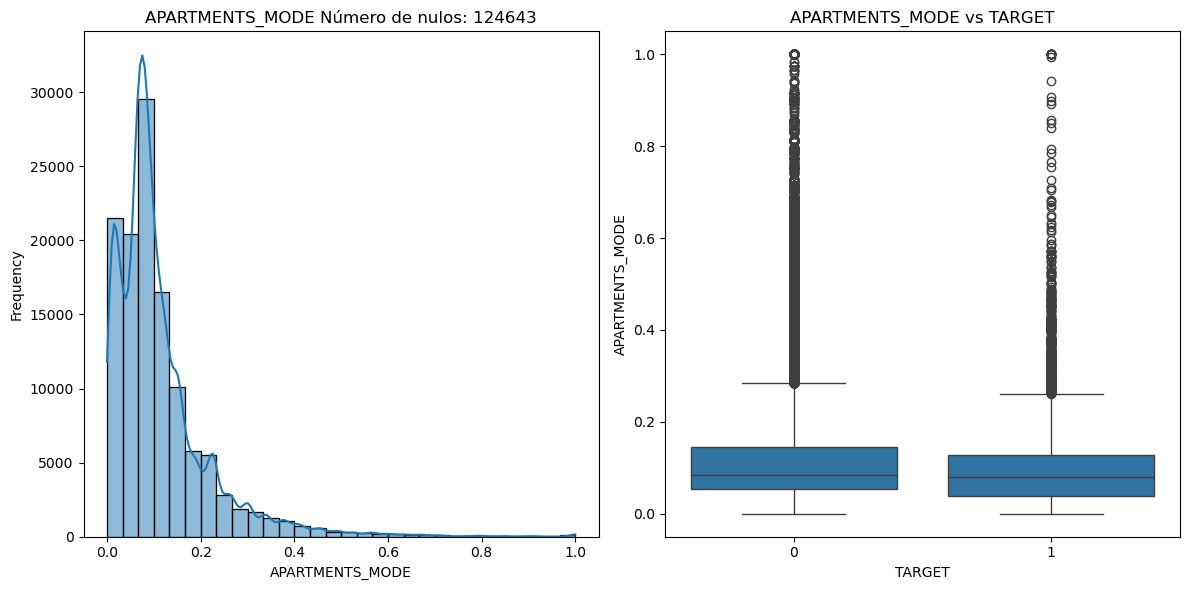

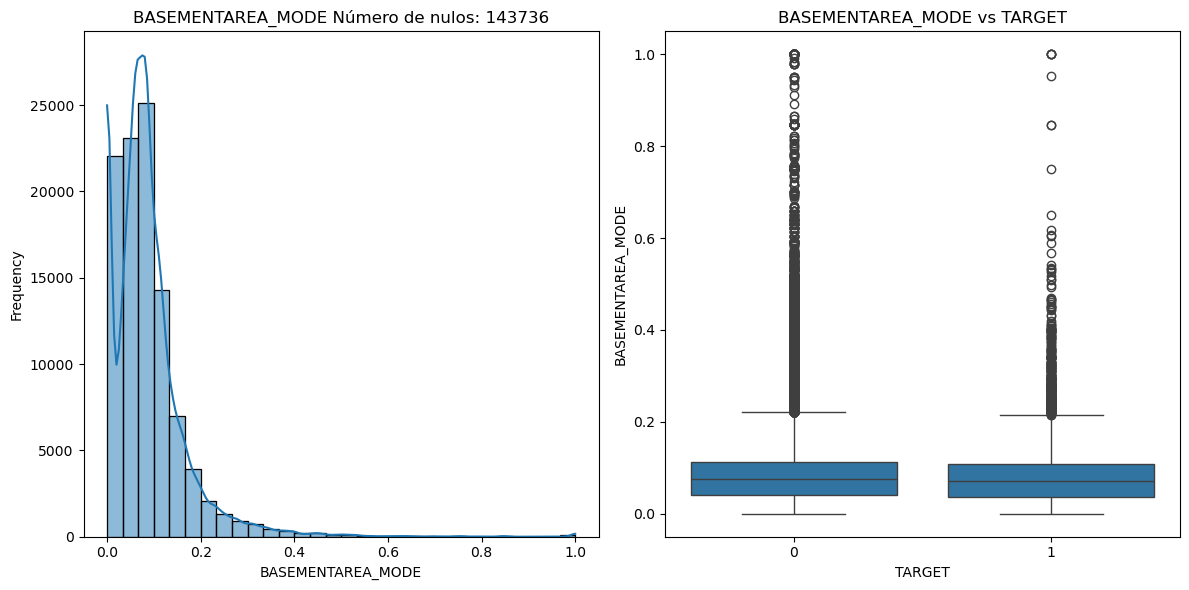

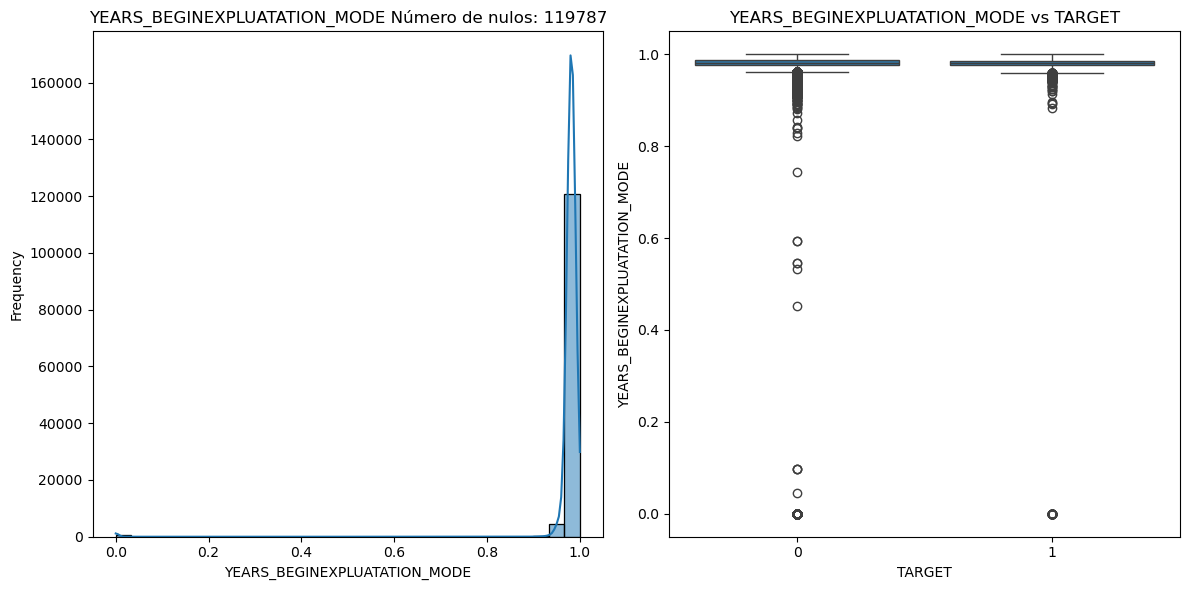

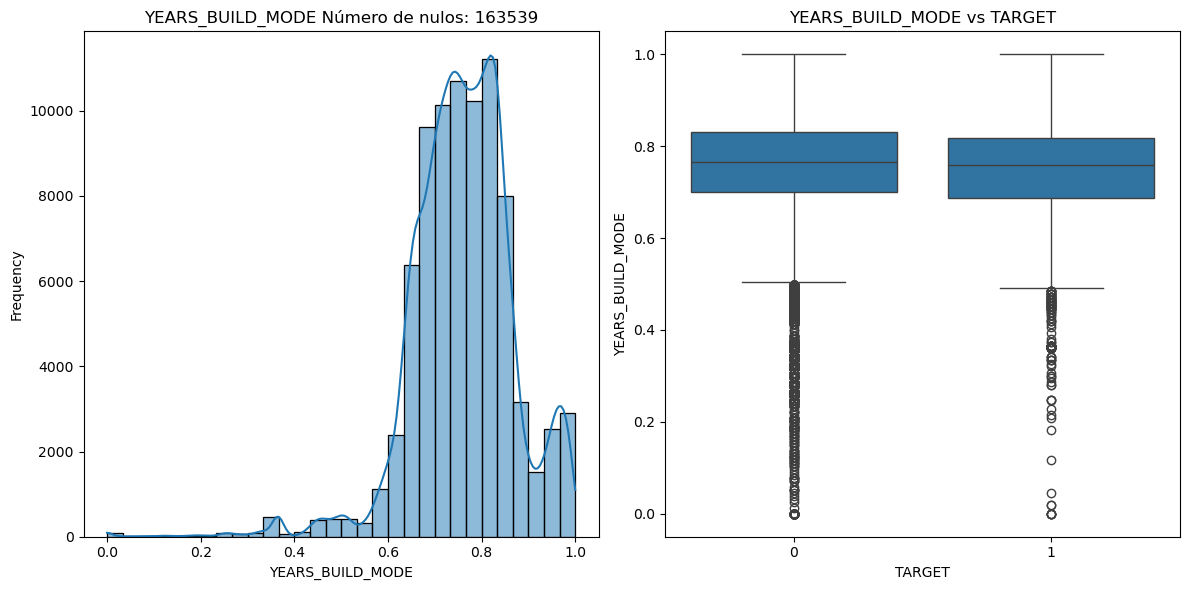

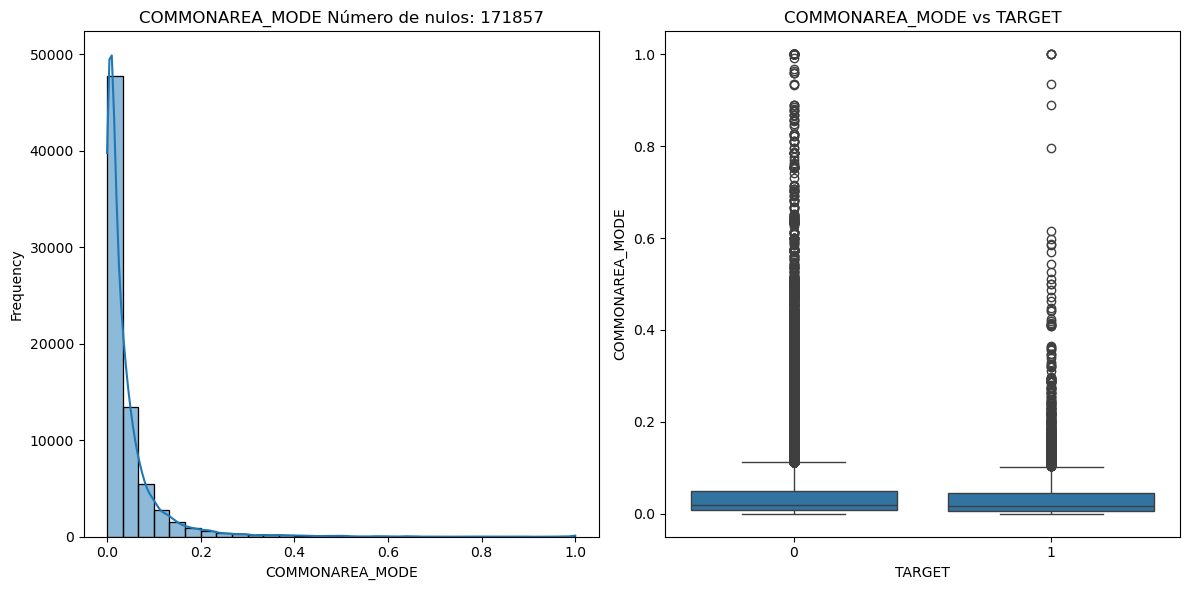

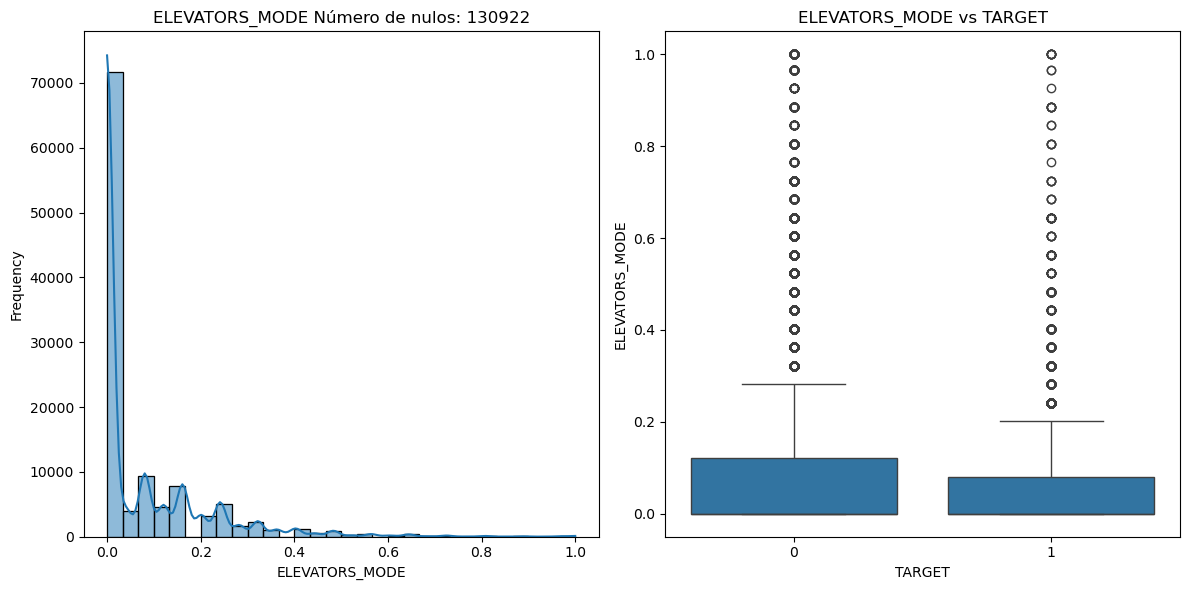

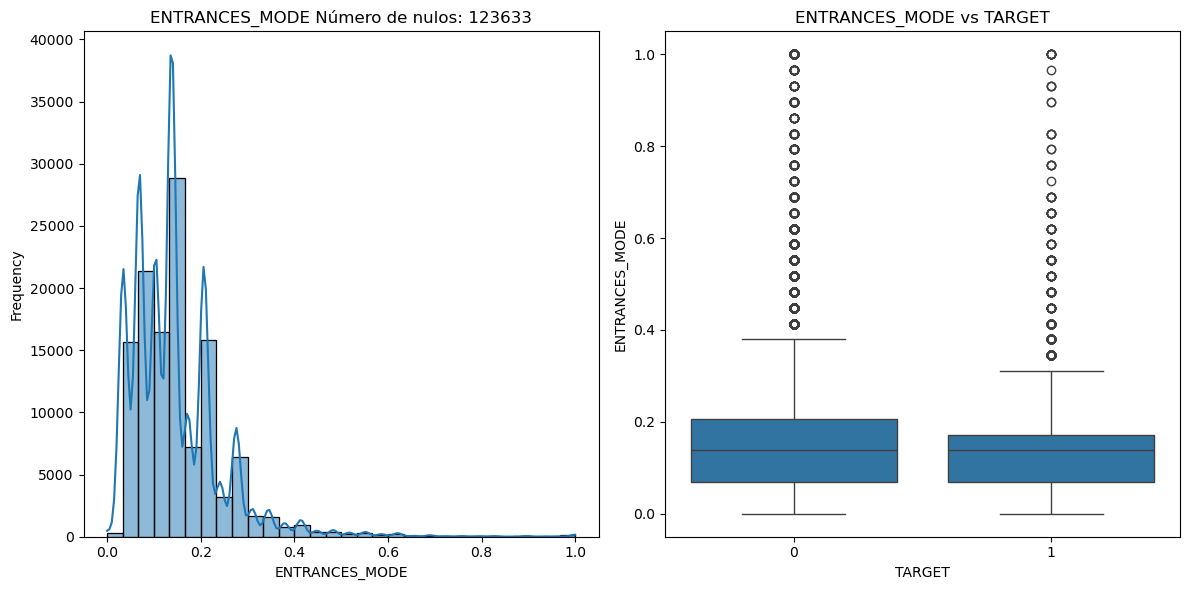

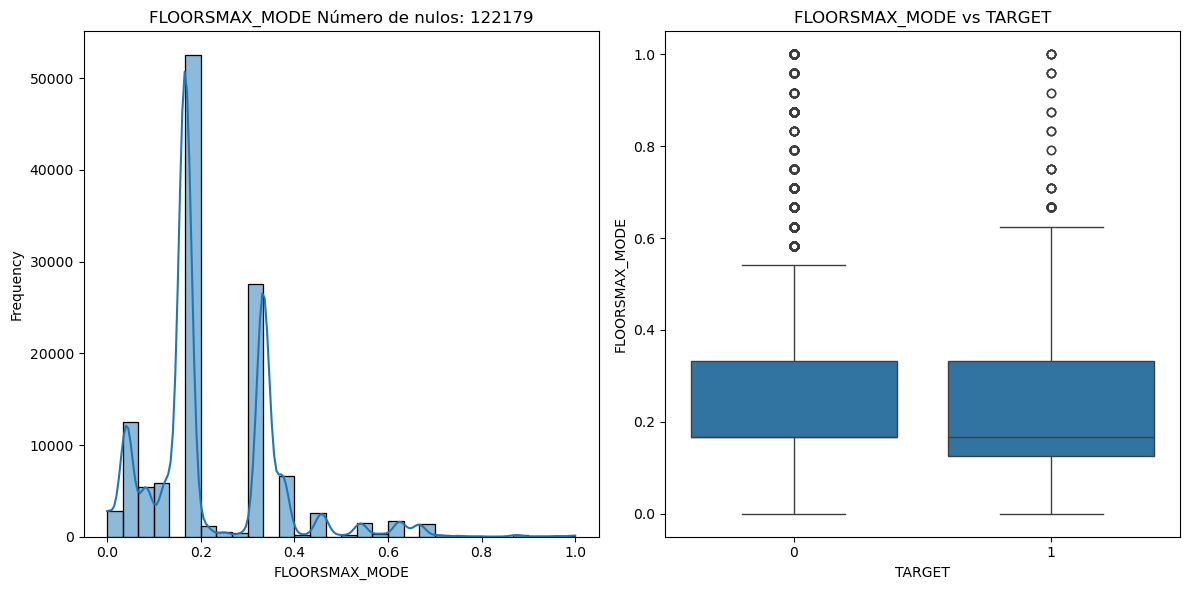

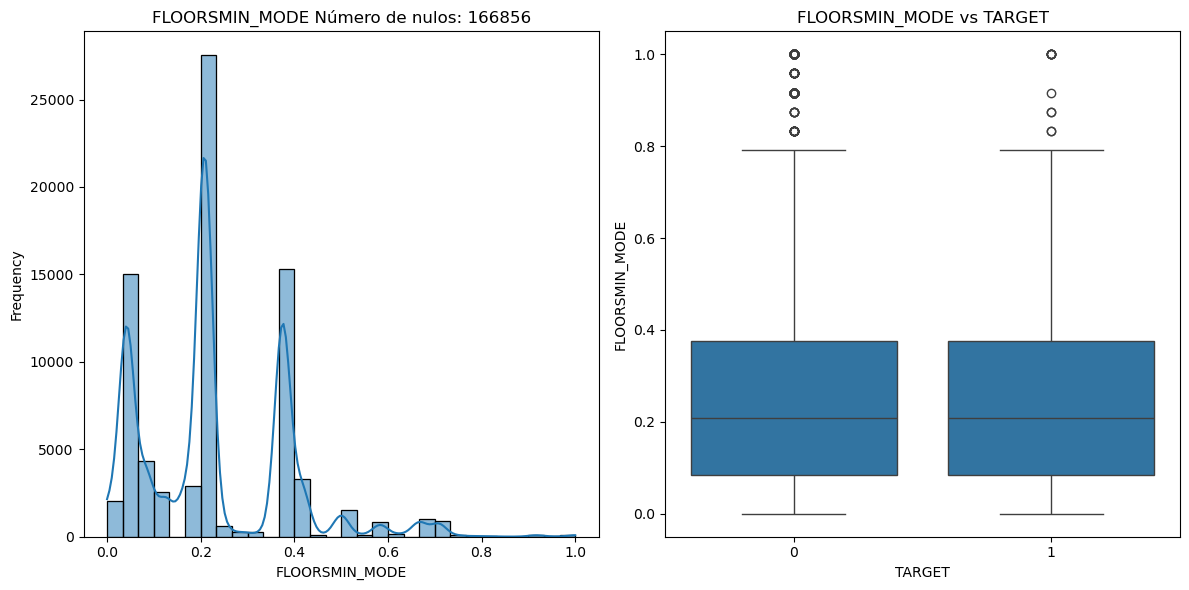

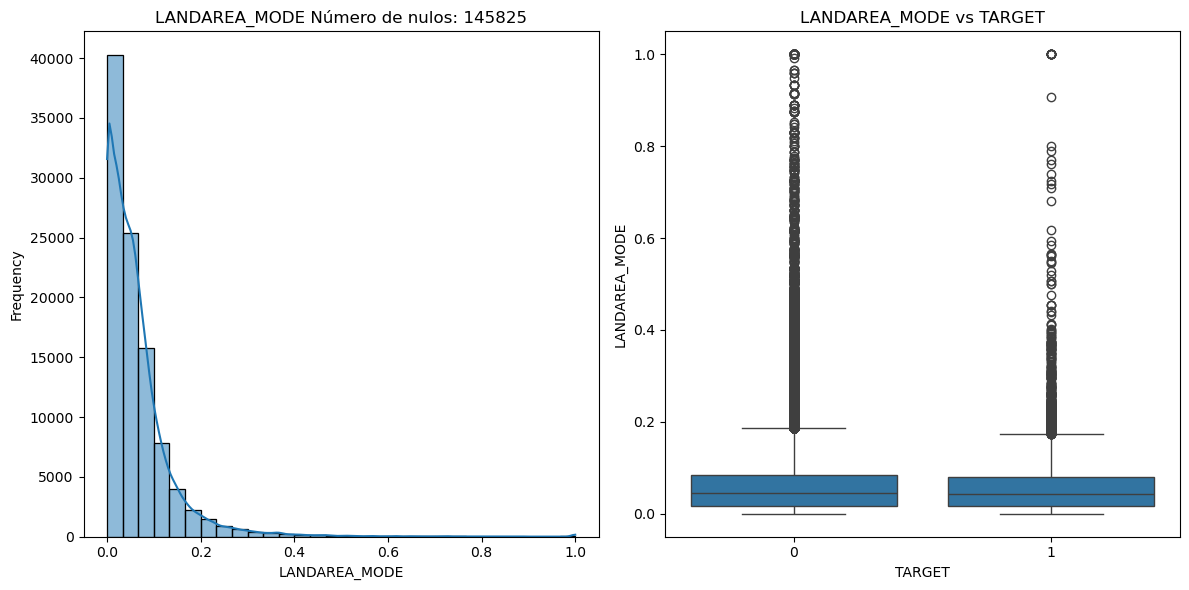

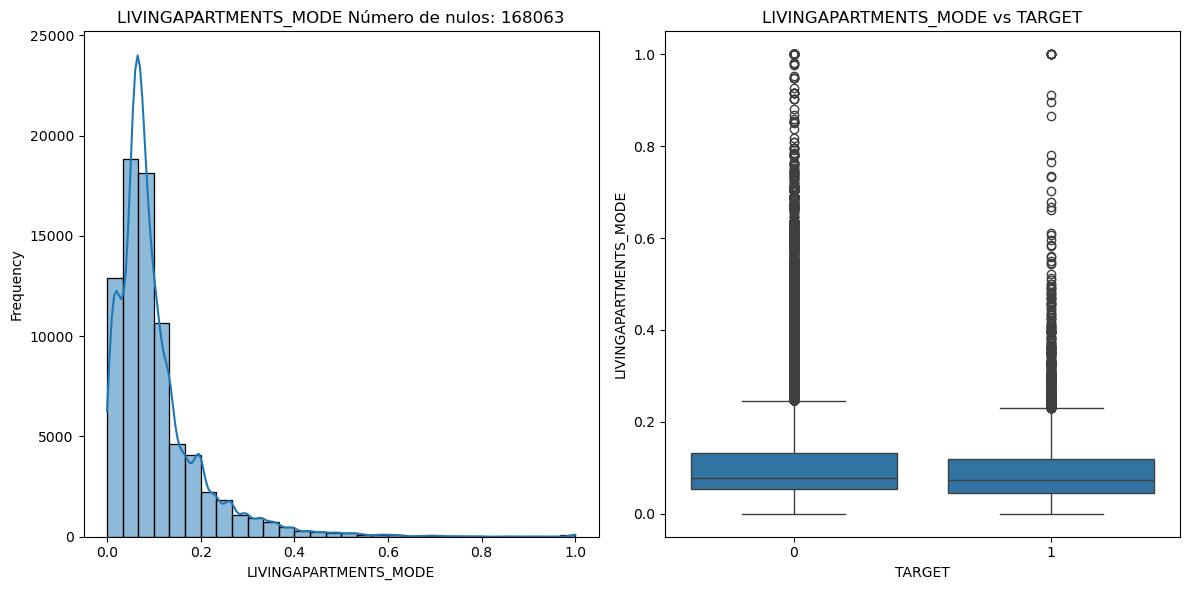

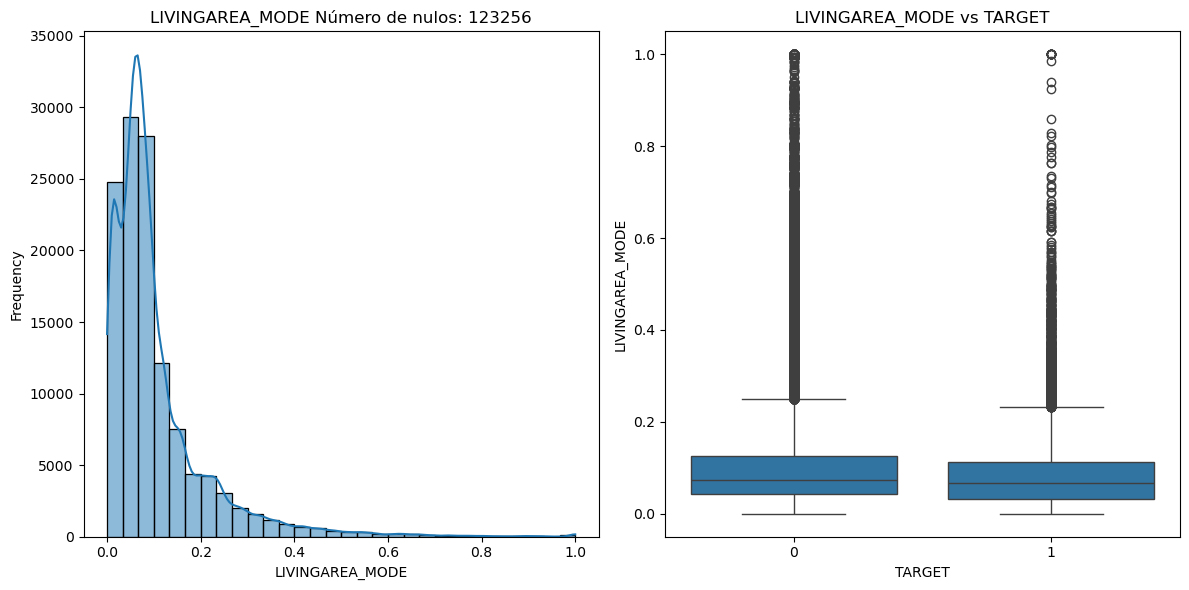

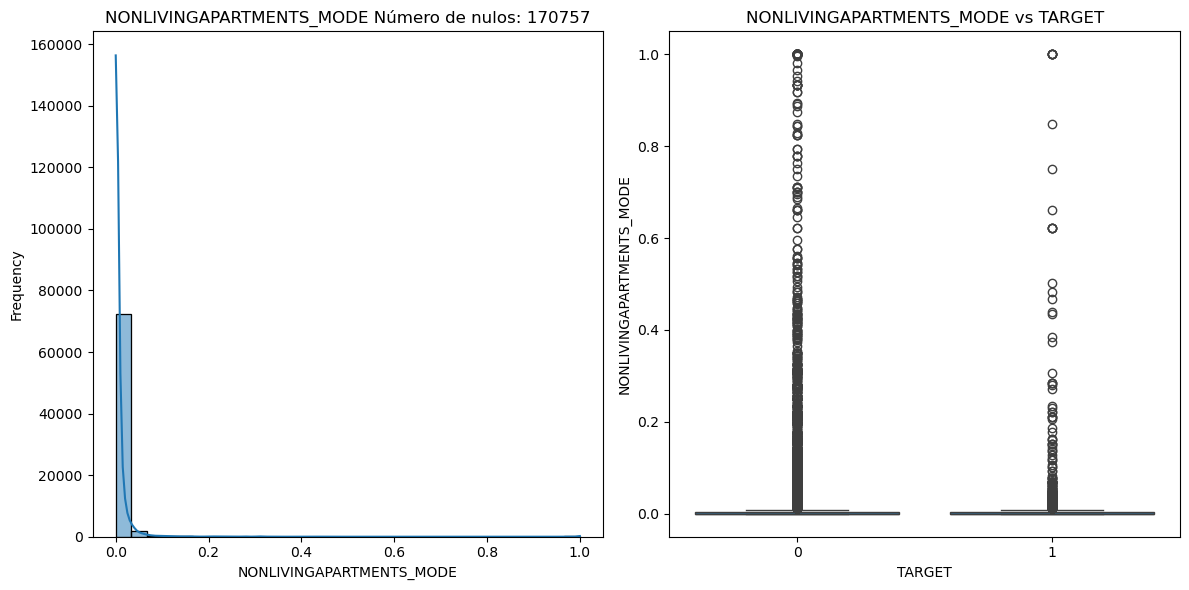

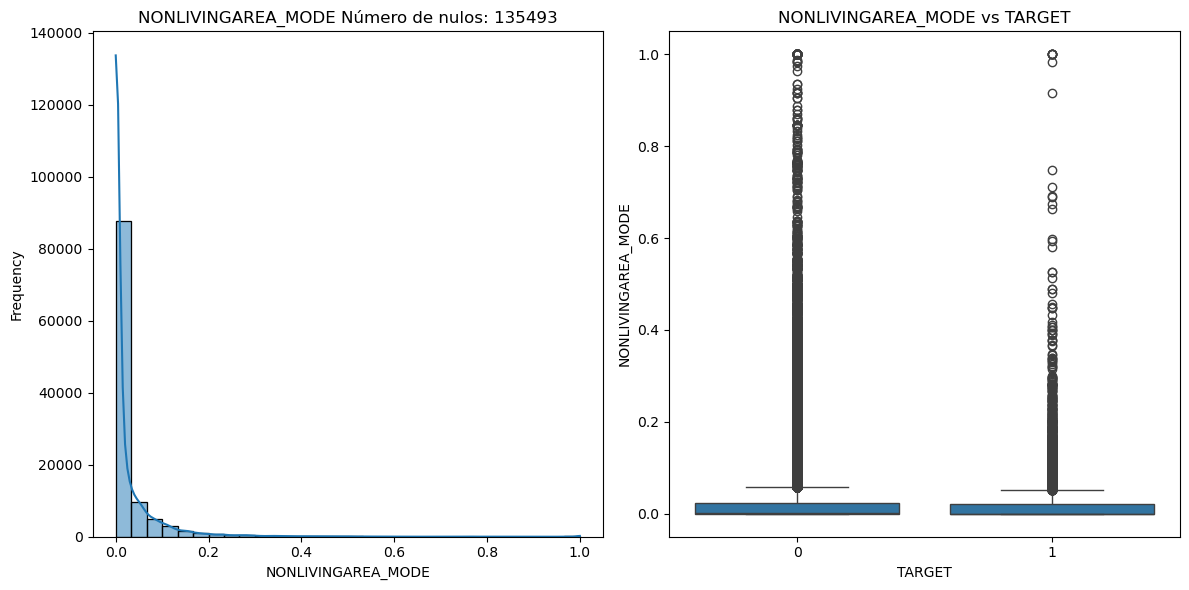

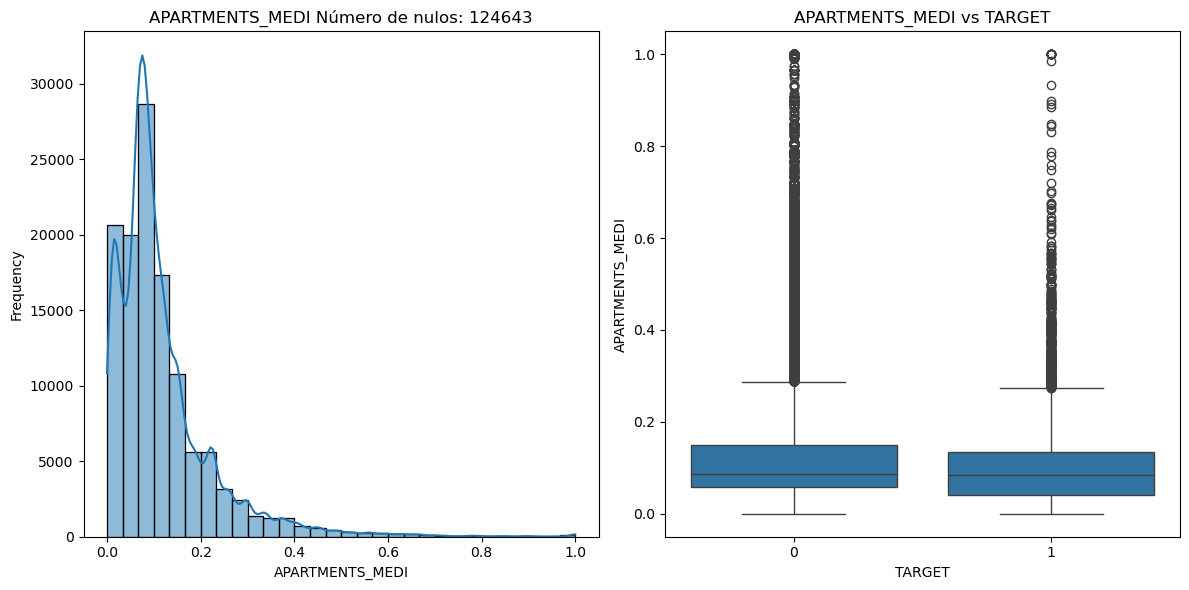

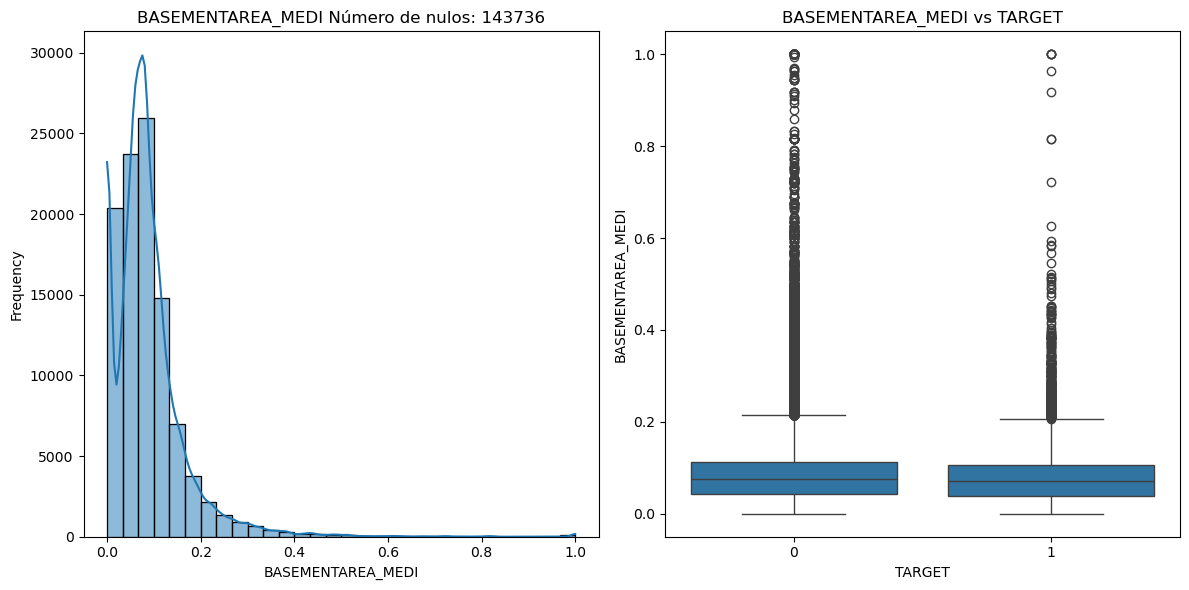

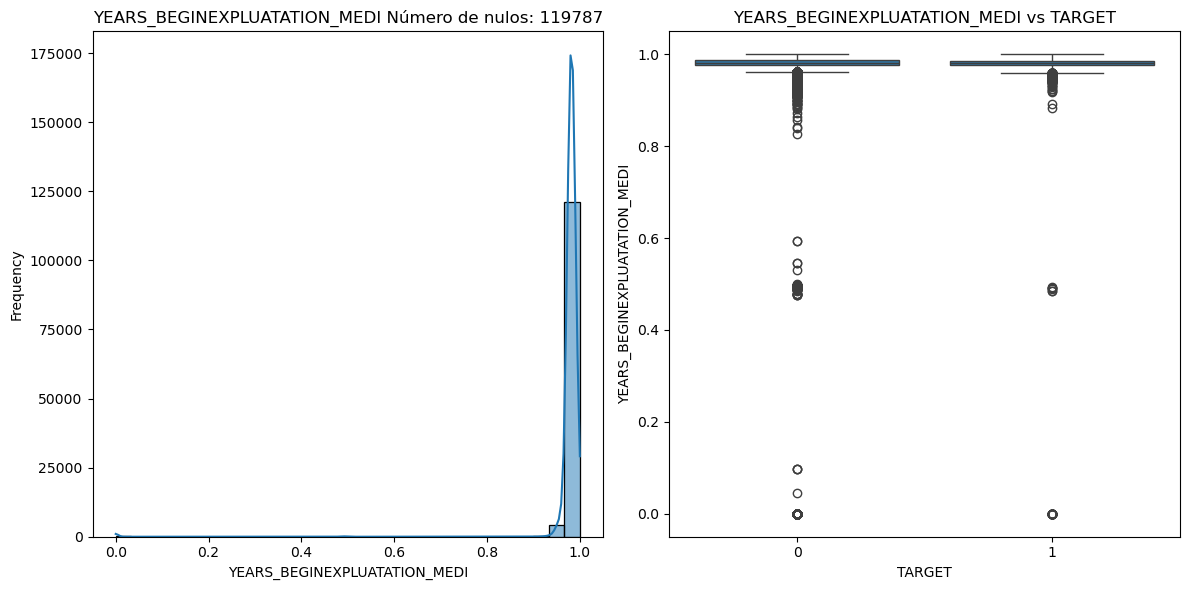

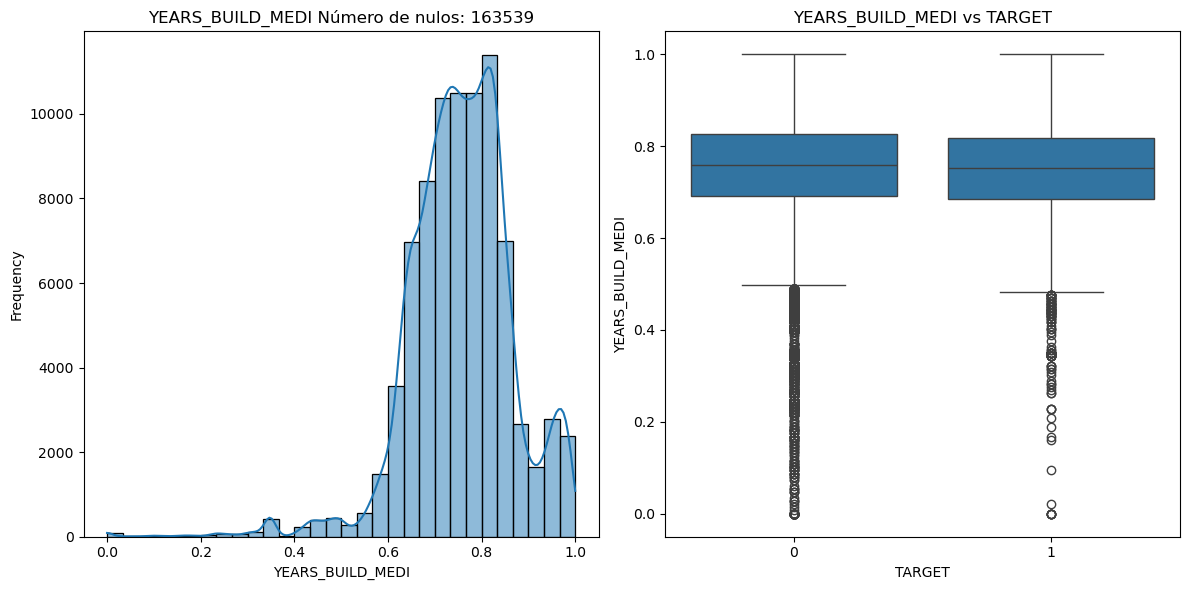

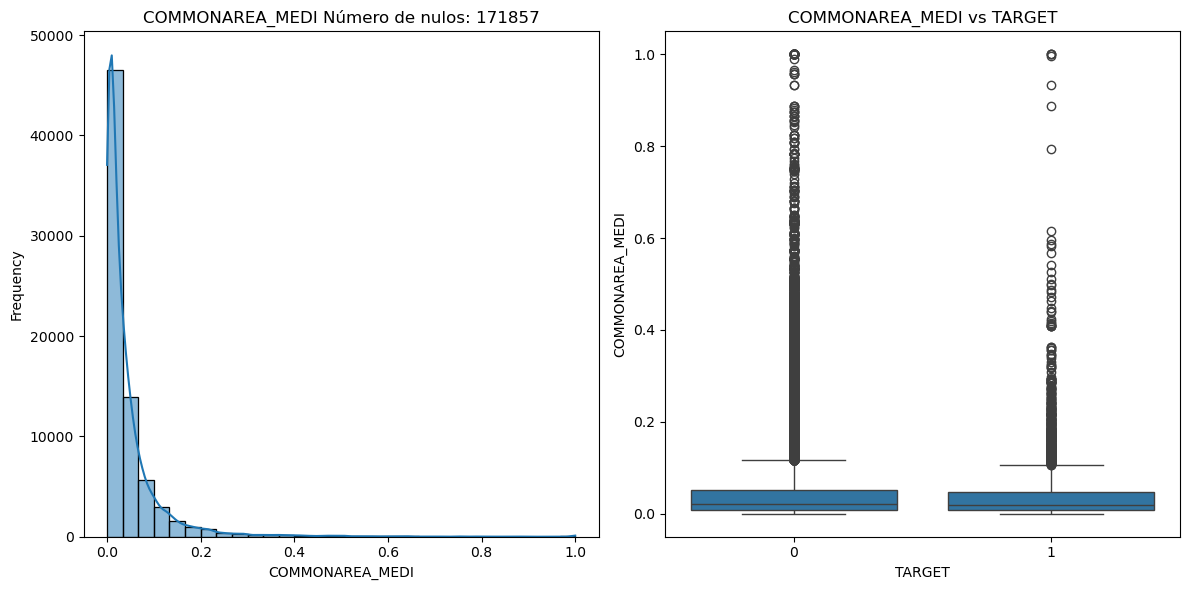

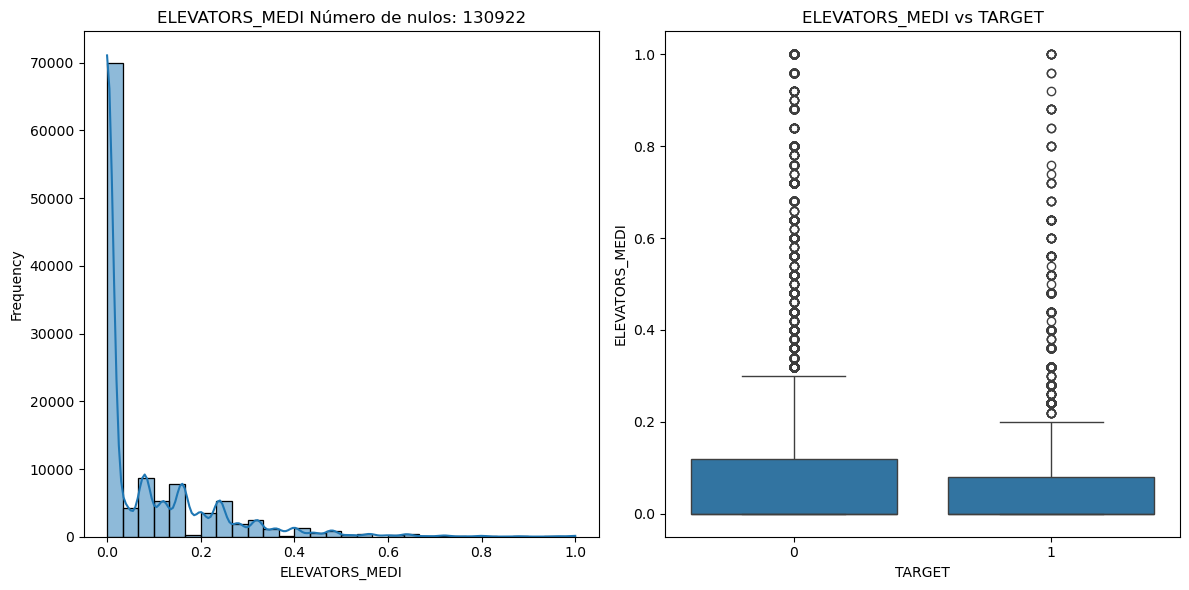

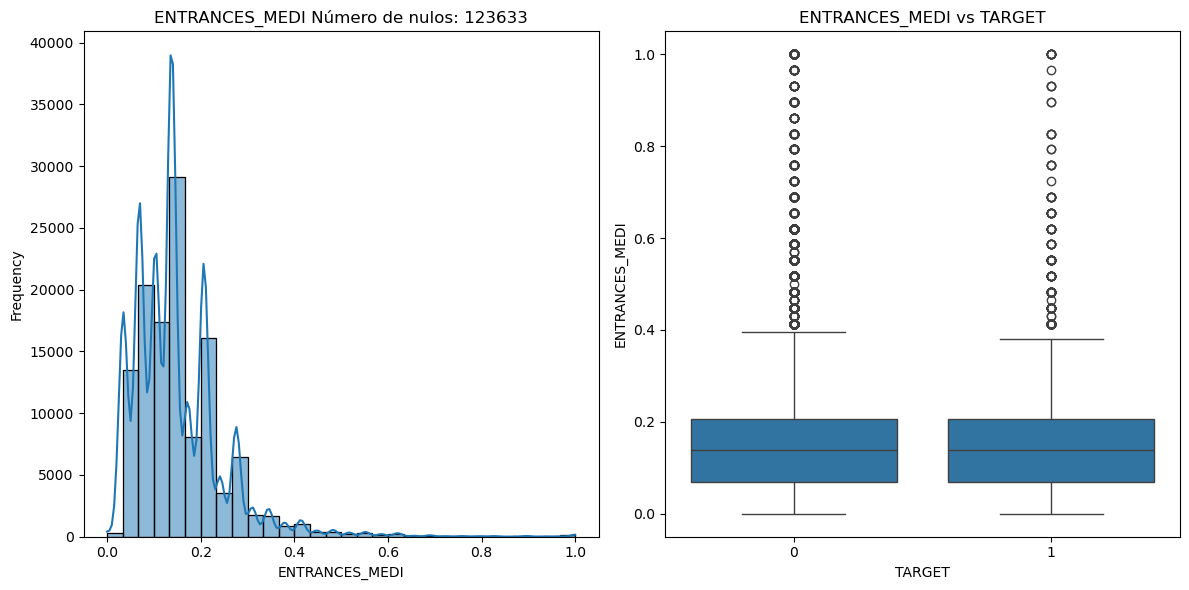

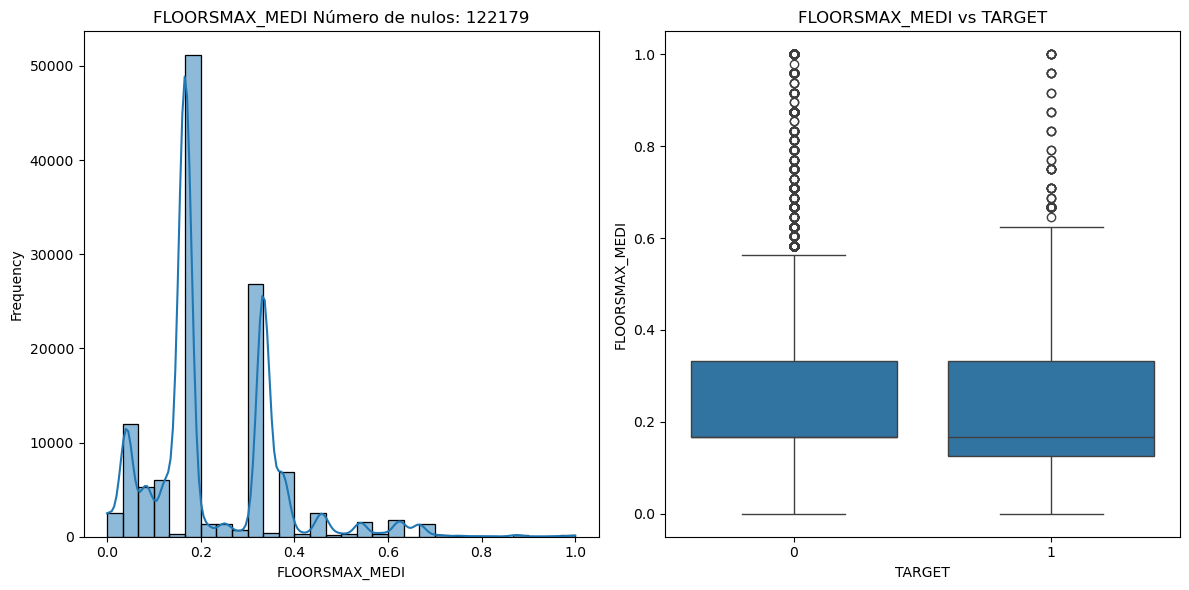

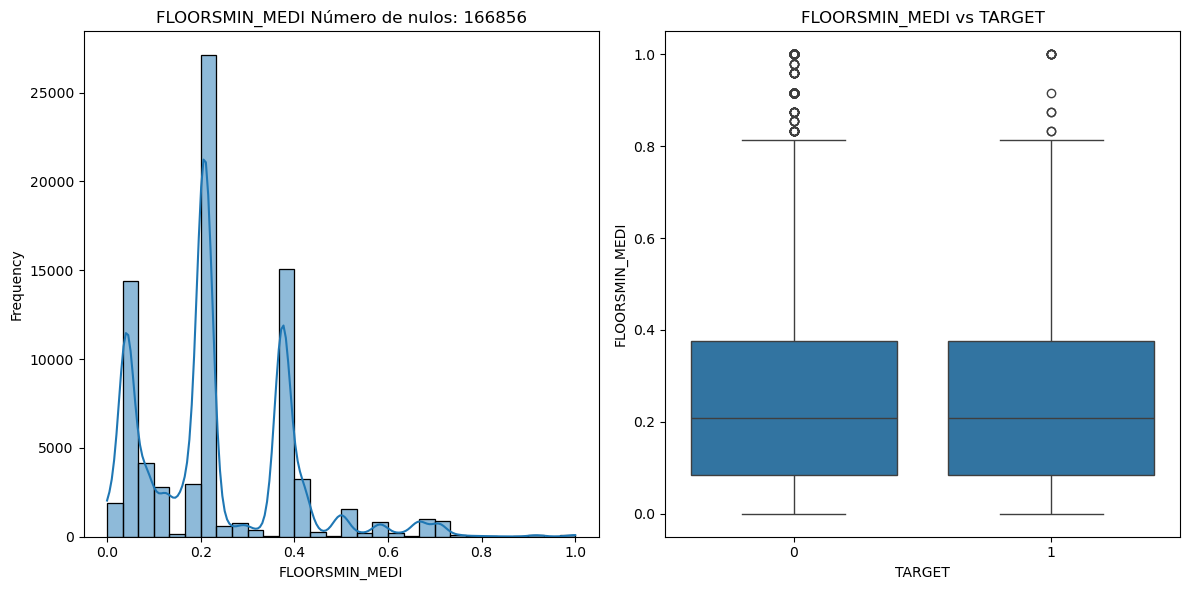

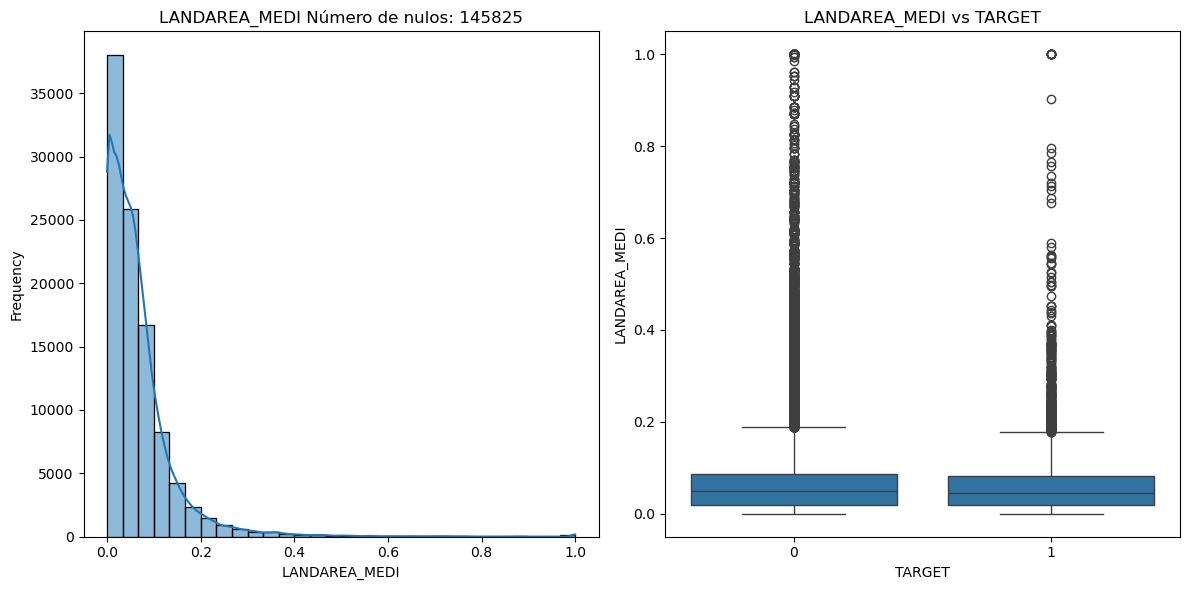

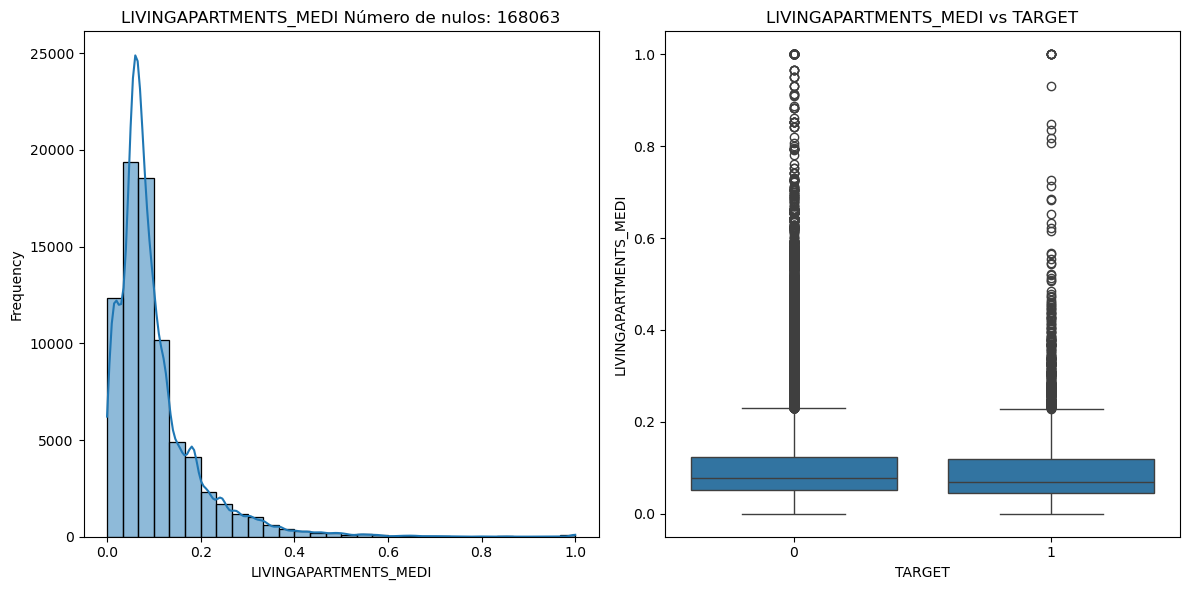

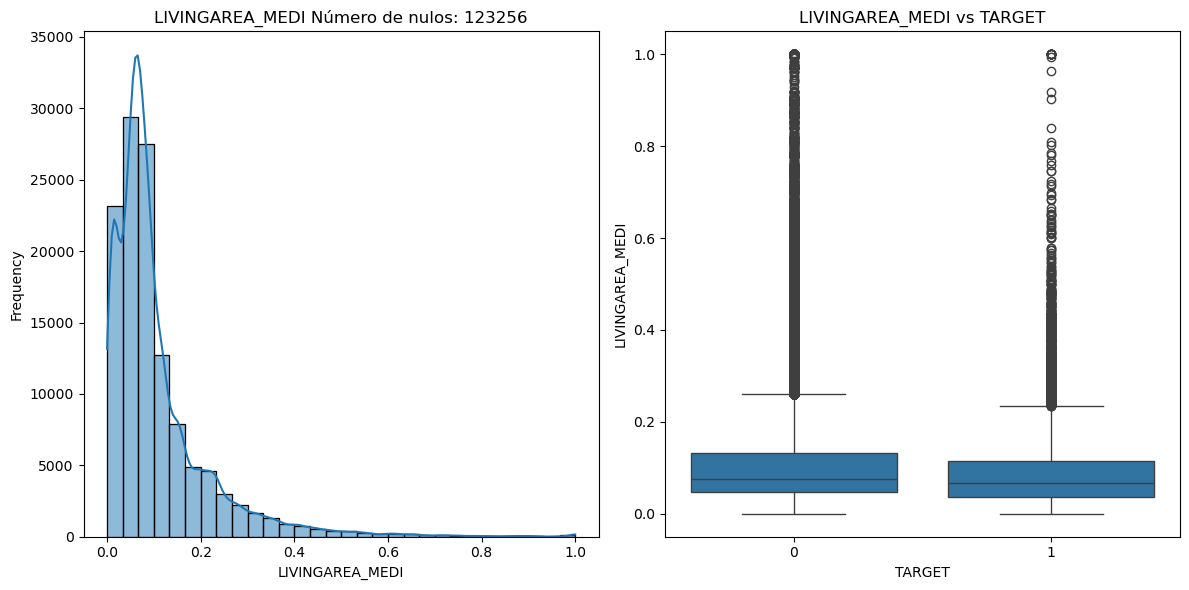

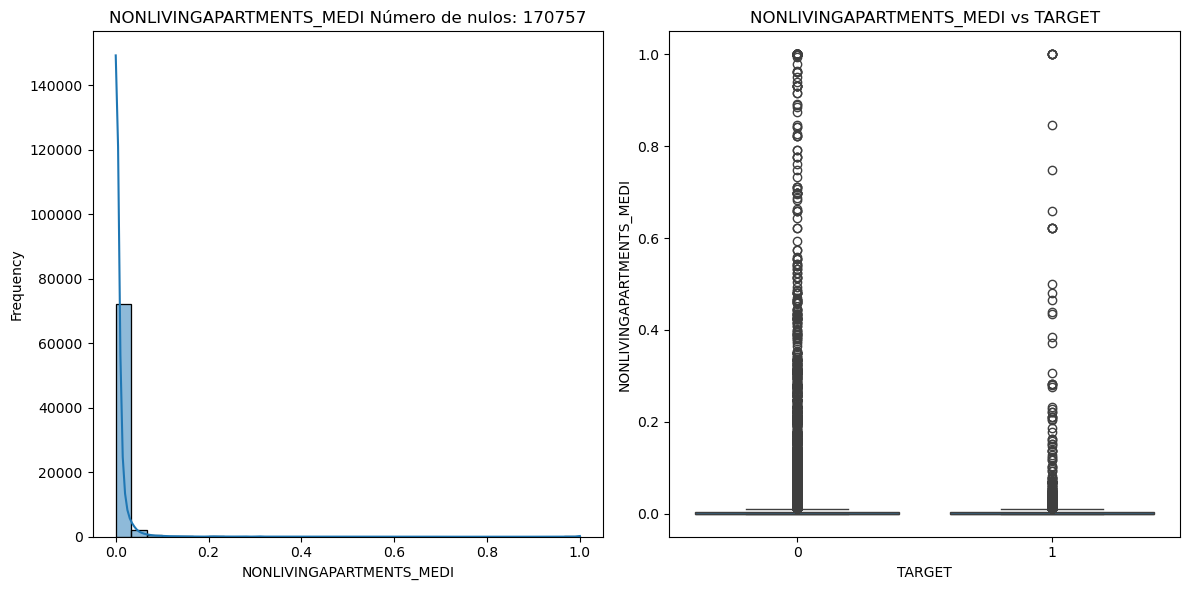

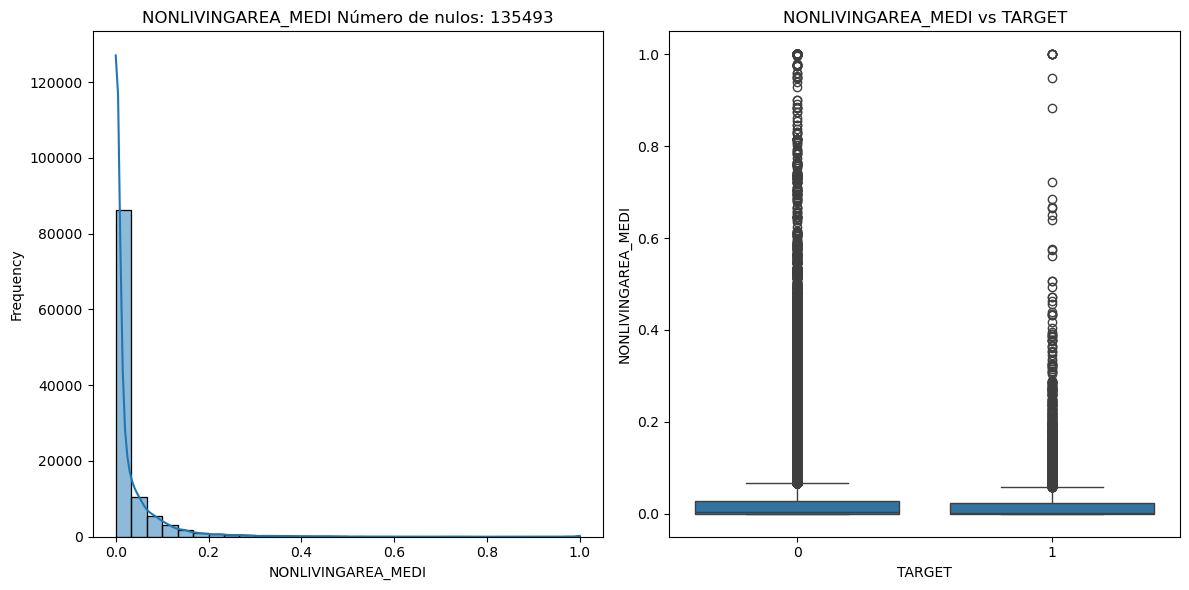

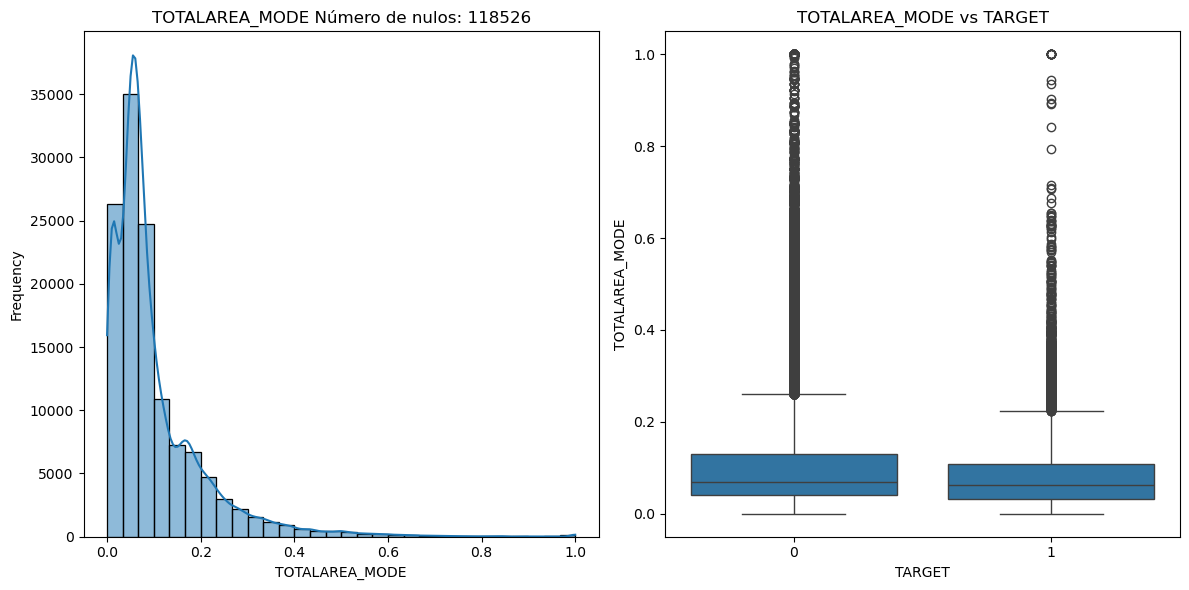

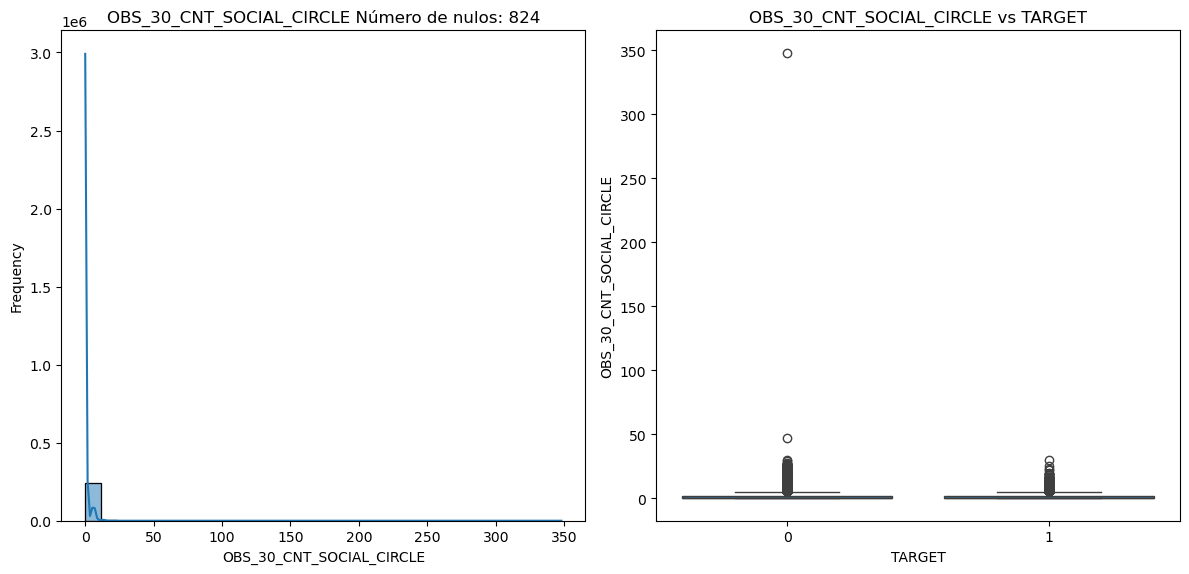

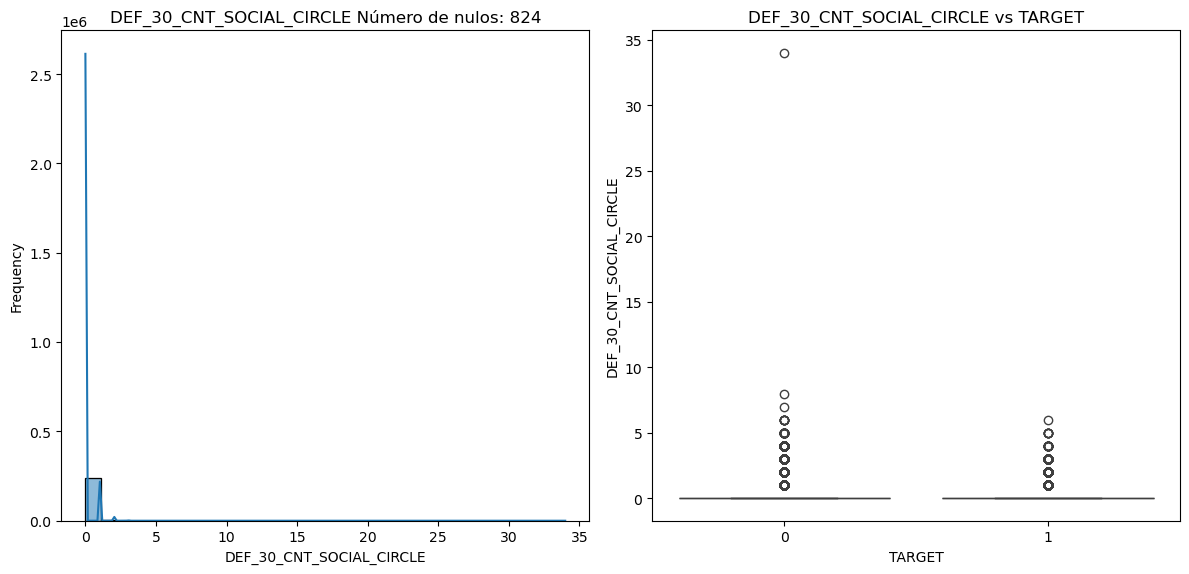

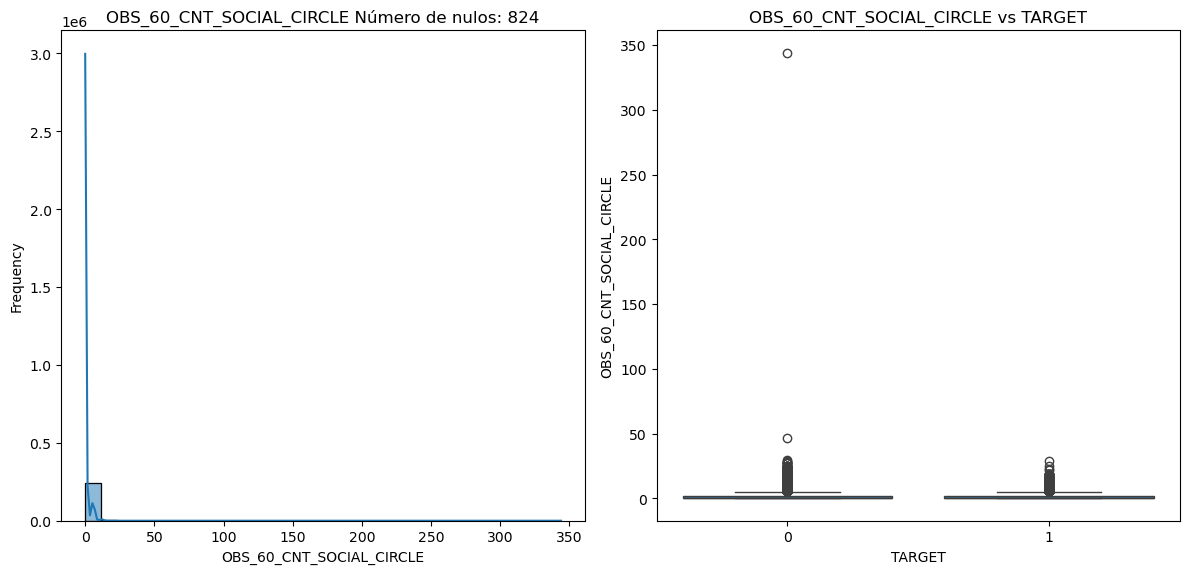

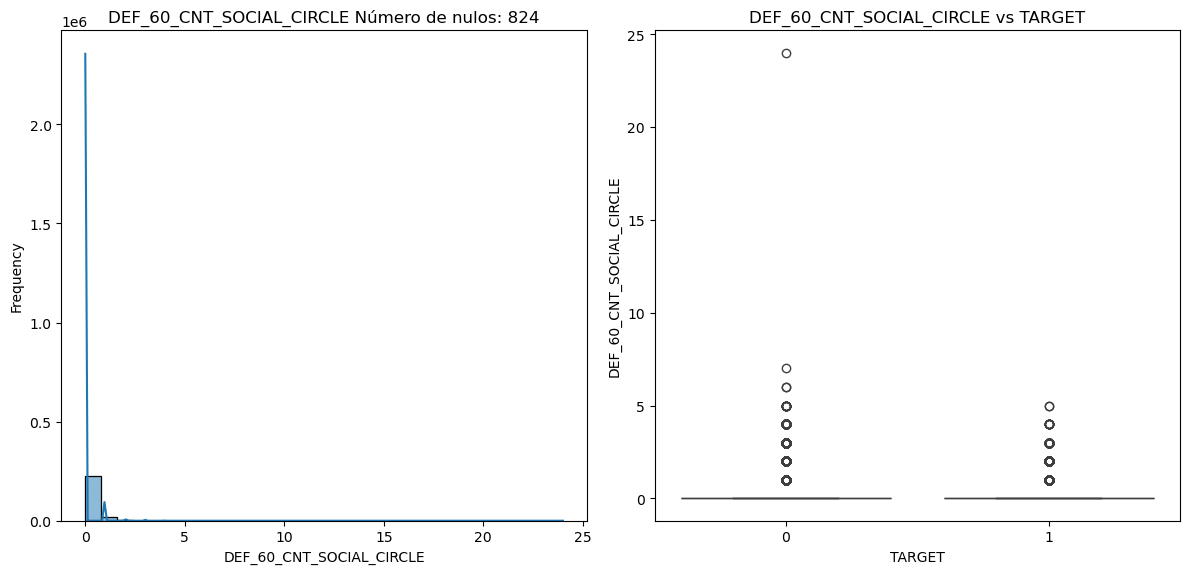

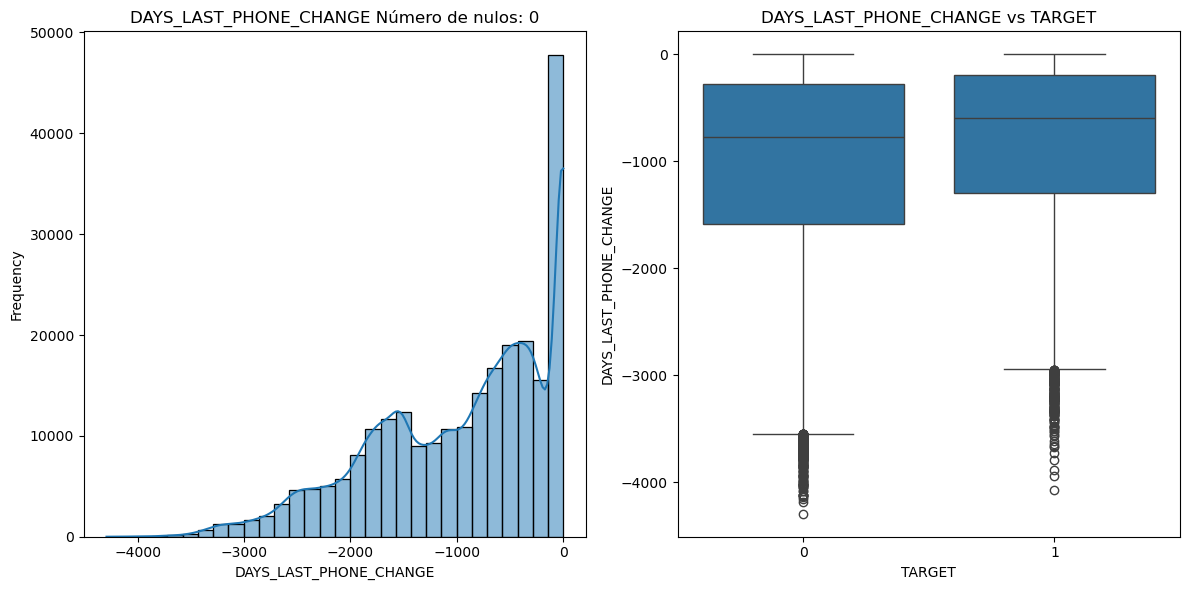

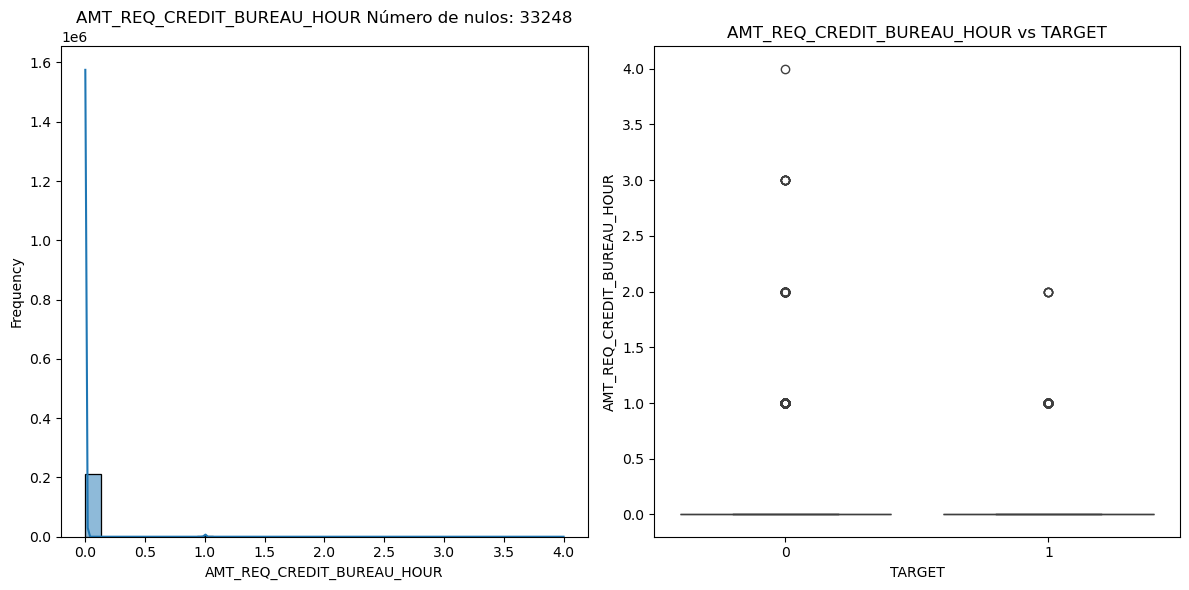

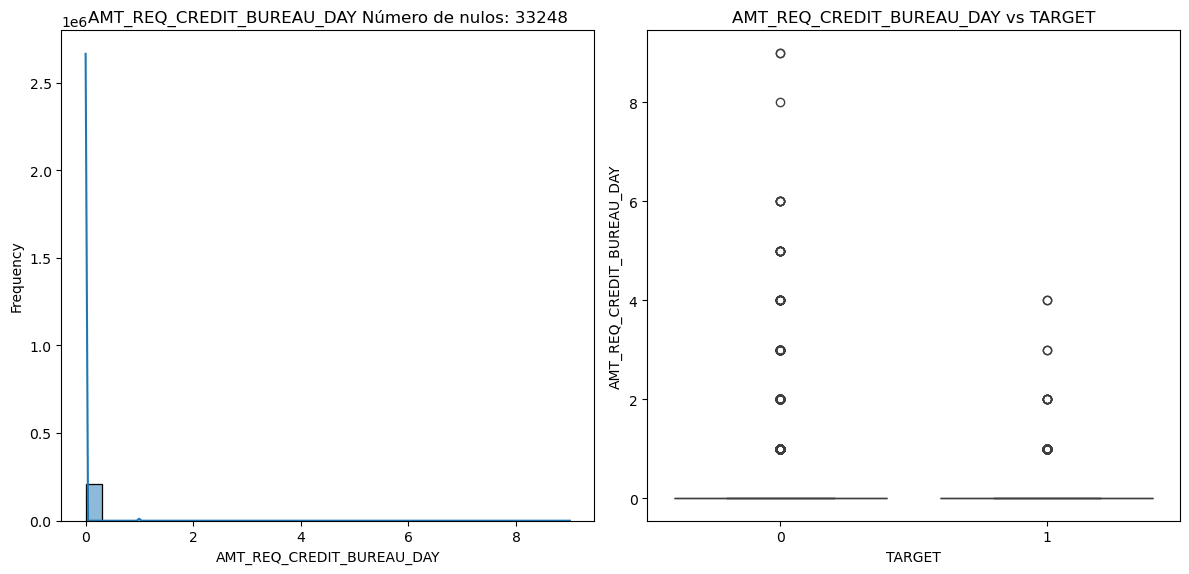

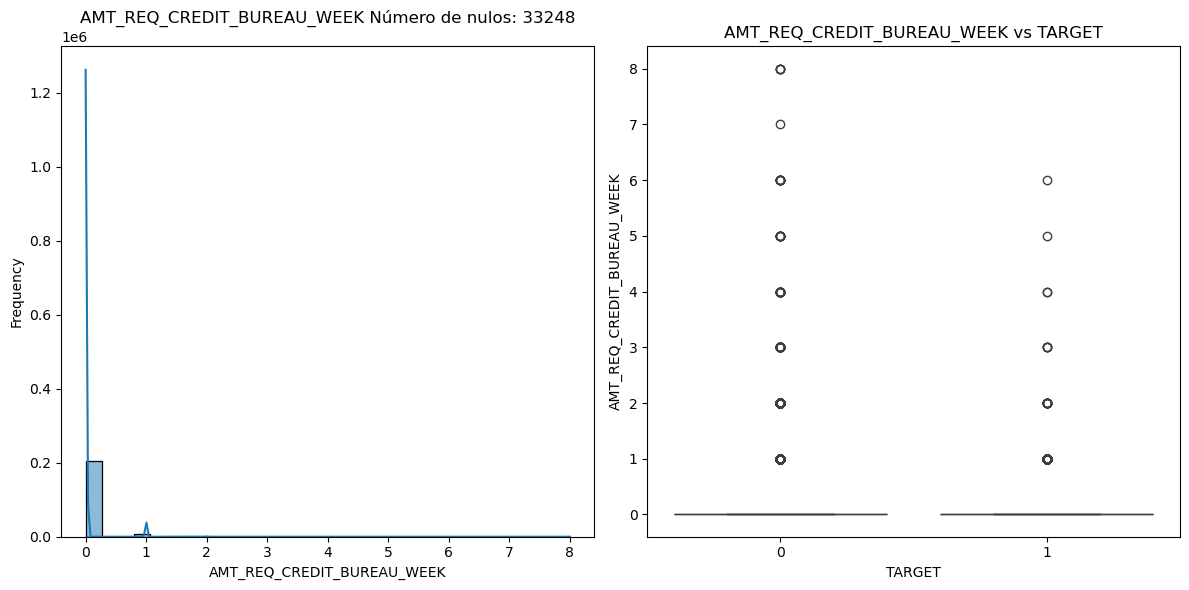

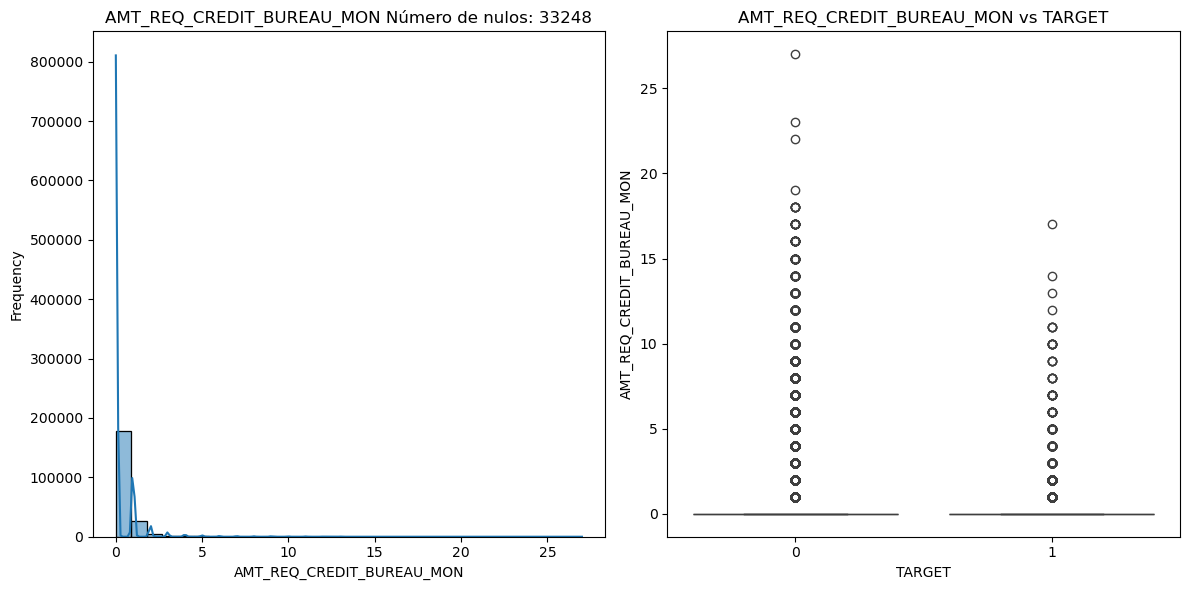

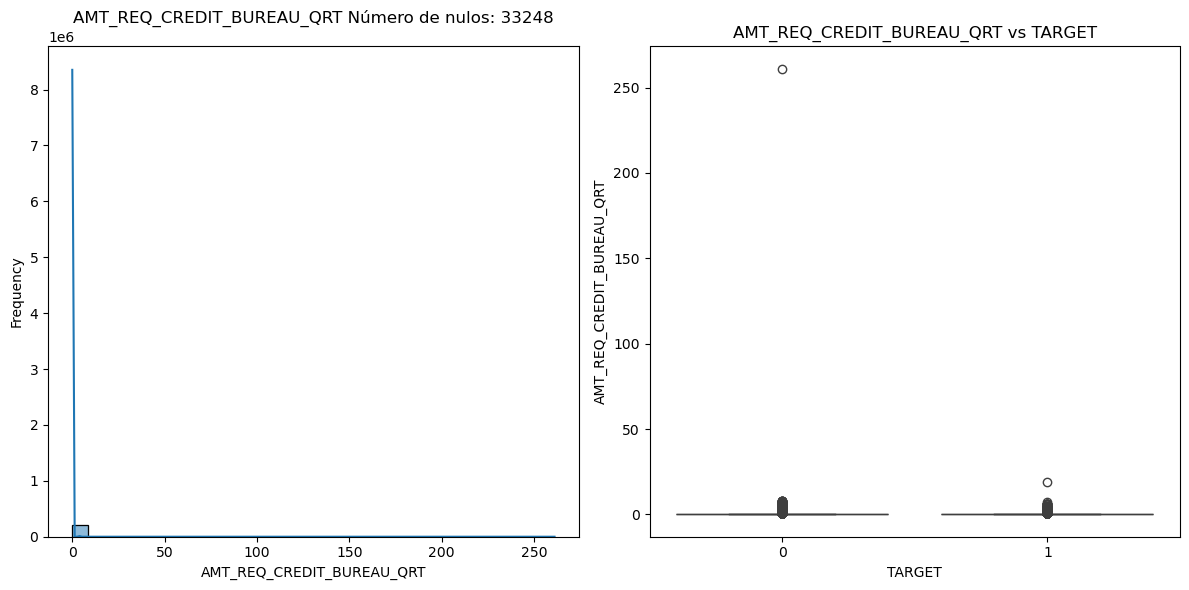

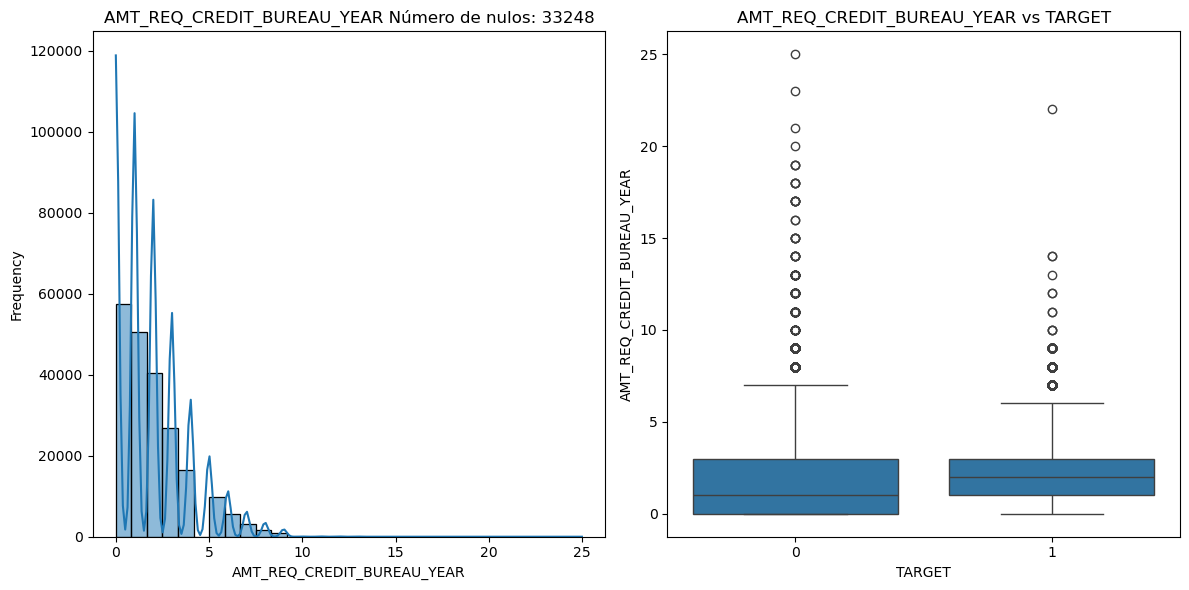

In [14]:
for variable in list_var_continuous:  # Lista de variables continuas
    if variable != "TARGET":
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Histograma
        sns.histplot(data=pd_loan_train, x=variable, kde=True, ax=axes[0], bins=30)
        axes[0].set_title(f'{variable} Número de nulos: {pd_loan_train[variable].isna().sum()}')
        axes[0].set_ylabel('Frequency')

        # Boxplot vs TARGET
        sns.boxplot(data=pd_loan_train, x='TARGET', y=variable, ax=axes[1])
        axes[1].set_title(f'{variable} vs TARGET')
        axes[1].set_ylabel(variable)
        axes[1].set_xlabel('TARGET')

        # Ajustar diseño
        plt.tight_layout()
        plt.show()




Una vez realizados los gráficos de las variables continuas con la variable objetivo (TARGET), procederemos a realizar algunos comentarios de algunas variables que puedan influir
en la misma, así como algunas que no sean tan significativas para tener un ejemplo de todo. A continuación, veremos cuáles son las variables elegidas.

OWN_CAR_AGE (Edad del coche propio).
Como vemos en el gráfico de la izquierda, hay un número considerable de valores nulos, concretamente 162.426, lo que indica que muchas personas no poseen automóvil o no hay información a cerca de ellos. Esto se debería gestionar mediante, por ejemplo, con la imputación o creando una categoría específica para los que no tienen automóvil. La mayoría de los coches tienen entre 0 y 20 años, con una concentración importante sobre todo de 0 a 10. No hay casi valores más allá de los 40 años, solo unos pocos datos sobrepasan los 60 años. En cuanto a su relación con TARGET, vemos en los boxplots que no hay grandes diferencias en la mediana ni en el rango intercuartílico para 0 y para 1, lo que nos puede indicar que no el coche propio puede no ser un factor influyente en cuanto a devolver o no el crédito.

EXT_SOURCE_1 (Puntuaciones de riesgo crediticio para los solicitantes que provienen de fuentes externas).
En el gráfico de la izquierda se puede observar que la variable sigue una distribución simétrica con forma similar a una distribución normal. Esta variable tiene una elevada cantidad de valores lo que indica que puede ser útil para discriminar entre distintos tipos de solicitantes. En cuanto a su relación con TARGET, observamos que el boxplot muestra que la mediana para los clientes que no incumplen (TARGET=0) es algo mayor que la de los que sí incumplen (TARGET=1) tienden a tener valores más altos, lo que puede decir que esta variable está asociada con un menor riesgo de incumplimiento.El rango intercuartílico es algo mayor también en los clientes cumplidores que en los que no. Podemos decir que esta variable puede tener un cierto poder predictivo.Los valores altos de EXT_SOURCE_1 se asocian con un menor riesgo de incumplimiento.


CNT_FAM_MEMBERS (Numero de miembros de la familia).
En el gráfico de la izquierda vemos que la variable posee 2 valores nulos, algo que no es significativo dentro del total de datos. En el histograma se muestra que la mayoría de los datos se encuentran entre 2 y 4 miembros, concentrándose sobre todo en 2, sugiriendo que una gran parte de las familias son pequeñas. En relación con TARGET, el boxplot muestra que la distribución es similiar tanto para los cumplidores como para los que no. Tanto la mediana como el rango intercuartílico son iguales, lo que indica que no hay una gran relación con la probabilidad de impago. Hay algunas familias con un número elevado de miembros, aunque no parece que tengan un efecto significativo.


AMT_INCOME_TOTAL (Ingresos totales).
Esta variable no posee valores nulos, por lo que podría ser representativa. En cuanto al histograma, la distribución de la variable está sesgada hacia la izquierda, lo que indica que la mayoría de clientes tienen ingresos bajos. La distribuación de los ingresos para TARGET=0 y TARGET=1 es muy similar, La mediana y el rango intercuartílico son también casi iguales, lo que indica que el nivel de ingresos no tiene una relación directa con la posibilidad de impago.

EXT_SOURCE_2 (Puntuaciones de riesgo crediticio para los solicitantes que provienen de fuentes externas)
En este caso, presenta pocos valores nulos con respecto al total de los datos, aunque se podrían imputar para no perder demasiada información. En el histograma vemos que la mayoría de los valores están concentrados entre 0.4 y 0.8, es decir, sesgados a la derecha, mientras que los valores extremos son menos comunes.En cuanto a su relación con TARGET, vemos que los valores más altos están relacionados con los clientes que no incumplen. La mediana es mas alta para los clientes que no incumplen, lo que un valor más alto de la variable podría estar asociado con un menor riesgo de incumplimiento. El rango intercuartílico es bastante parecido, aunque se observa que los valores bajos se concentran más en los clientes que presentan incumplimiento, por lo que podemos decir que esta variable puede ser un buen predictor.

EXT_SOURCE_3 (Puntuaciones de riesgo crediticio para los solicitantes que provienen de fuentes externas)
Al igual que en las variables anteriores como EXT_SOURCE_1 y EXT_SOURCE_2, prsenta los valores más altos asocidados a clientes que no incumplen el préstamo, lo que indica que valores bajos poseen un mayor riesgo de incumplimiento. Por lo tanto, podemos concluir que la información externa sobre clientes solicitantes de préstamo es una buena variable predictora.



TRATAMIENTO DE VARIABLES CONTINUAS

A continuación se tratarán tres aspectos clave del análisis de los datos: los valores missing, los outliers y las correlaciones entre las variables continuas

In [15]:

list_var_continuous


['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_M

In [16]:
def get_deviation_of_mean_perc(pd_loan, list_var_continuous, target, multiplier):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función get_deviation_of_mean_perc:
    ----------------------------------------------------------------------------------------------------------
    - Descripción:
        Esta función calcula el porcentaje de valores que se encuentran fuera de un 
        intervalo de confianza, determinado por la media y una desviación estándar 
        multiplicada por un factor (multiplier), para cada variable continua en el 
        DataFrame. Luego, analiza la relación entre estos valores atípicos y la variable 
        objetivo (TARGET), y devuelve un resumen con los porcentajes de valores atípicos 
        y su distribución en relación con la variable objetivo.
        
    - Inputs: 
        - pd_loan (DataFrame): DataFrame que contiene los datos de entrada.
        - list_var_continuous (list): Lista con los nombres de las variables continuas 
          a analizar.
        - target (str): Nombre de la variable objetivo en el DataFrame.
        - multiplier (float): Factor multiplicador para calcular el intervalo de confianza
          (desviación estándar).
        
    - Return:
        - pd_final (DataFrame): DataFrame que contiene el porcentaje de valores atípicos 
          por cada variable continua, su distribución con respecto a la variable objetivo 
          (TARGET), y otros detalles relevantes.
    '''
    
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = pd_loan[i].mean()
        series_std = pd_loan[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_loan[i].size
        
        perc_goods = pd_loan[i][(pd_loan[i] >= left) & (pd_loan[i] <= right)].size/size_s
        perc_excess = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_loan[target][(pd_loan[i] < left) | (pd_loan[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]

            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final

In [17]:
get_deviation_of_mean_perc(pd_loan_train, list_var_continuous, target='TARGET', multiplier=3)

0.0       1.0                      variable  sum_outlier_values  \
0    0.000000  1.000000              AMT_INCOME_TOTAL                 215   
1    0.948837  0.051163              AMT_INCOME_TOTAL                 215   
2    0.000000  1.000000                    AMT_CREDIT                2638   
3    0.958681  0.041319                    AMT_CREDIT                2638   
4    0.000000  1.000000                   AMT_ANNUITY                2354   
5    0.964741  0.035259                   AMT_ANNUITY                2354   
6    0.000000  1.000000               AMT_GOODS_PRICE                3371   
7    0.961732  0.038268               AMT_GOODS_PRICE                3371   
8    0.000000  1.000000    REGION_POPULATION_RELATIVE                6686   
9    0.959168  0.040832    REGION_POPULATION_RELATIVE                6686   
10   0.000000  1.000000             DAYS_REGISTRATION                 605   
11   0.958678  0.041322             DAYS_REGISTRATION                 605   
12   0.000000  1.000000                   OWN_CAR_AGE                2677   
13   0.917445  0.082555                   OWN_CAR_AGE                2677   
14   0.000000  1.000000               CNT_FAM_MEMBERS                3223   
15   0.900093  0.099907               CNT_FAM_MEMBERS                3223   
16   0.000000  1.000000                APARTMENTS_AVG                2387   
17   0.948890  0.051110                APARTMENTS_AVG                2387   
18   0.000000  1.000000              BASEMENTAREA_AVG                1588   
19   0.947733  0.052267              BASEMENTAREA_AVG                1588   
20   0.000000  1.000000   YEARS_BEGINEXPLUATATION_AVG                 552   
21   0.902174  0.097826   YEARS_BEGINEXPLUATATION_AVG                 552   
22   0.000000  1.000000               YEARS_BUILD_AVG                 964   
23   0.930498  0.069502               YEARS_BUILD_AVG                 964   
24   0.000000  1.000000                COMMONAREA_AVG                1371   
25   0.951131  0.048869                COMMONAREA_AVG                1371   
26   0.000000  1.000000                 ELEVATORS_AVG                1941   
27   0.954663  0.045337                 ELEVATORS_AVG                1941   
28   0.000000  1.000000                 ENTRANCES_AVG                1759   
29   0.938033  0.061967                 ENTRANCES_AVG                1759   
30   0.000000  1.000000                 FLOORSMAX_AVG                2056   
31   0.957198  0.042802                 FLOORSMAX_AVG                2056   
32   0.000000  1.000000                 FLOORSMIN_AVG                 474   
33   0.955696  0.044304                 FLOORSMIN_AVG                 474   
34   0.000000  1.000000                  LANDAREA_AVG                1696   
35   0.938679  0.061321                  LANDAREA_AVG                1696   
36   0.000000  1.000000          LIVINGAPARTMENTS_AVG                1393   
37   0.952620  0.047380          LIVINGAPARTMENTS_AVG                1393   
38   0.000000  1.000000                LIVINGAREA_AVG                2568   
39   0.948988  0.051012                LIVINGAREA_AVG                2568   
40   0.000000  1.000000       NONLIVINGAPARTMENTS_AVG                 586   
41   0.930034  0.069966       NONLIVINGAPARTMENTS_AVG                 586   
42   0.000000  1.000000             NONLIVINGAREA_AVG                1956   
43   0.947342  0.052658             NONLIVINGAREA_AVG                1956   
44   0.000000  1.000000               APARTMENTS_MODE                2411   
45   0.948569  0.051431               APARTMENTS_MODE                2411   
46   0.000000  1.000000             BASEMENTAREA_MODE                1689   
47   0.944938  0.055062             BASEMENTAREA_MODE                1689   
48   0.000000  1.000000  YEARS_BEGINEXPLUATATION_MODE                 540   
49   0.900000  0.100000  YEARS_BEGINEXPLUATATION_MODE                 540   
50   0.000000  1.000000              YEARS_BUILD_MODE                 975   
51   0

CORRELACIONES

In [18]:
def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    ''''
    ----------------------------------------------------------------------------------------------------------
    Función get_corr_matrix:
    ----------------------------------------------------------------------------------------------------------
    - Descripción:
        Esta función calcula y visualiza la matriz de correlación entre las variables 
        numéricas de un conjunto de datos. 

    - Inputs: 
        - dataset (DataFrame): Conjunto de datos con las variables numéricas a analizar.
        - metodo (str): Método de correlación a utilizar.
        - size_figure (list): Tamaño de la figura del gráfico.

    - Return:
        - None: Muestra un mapa de calor de la matriz de correlación.
    ----------------------------------------------------------------------------------------------------------
    '''
    
    # Comprobación de que se ha proporcionado el dataset
    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    
    # Calcular la matriz de correlación
    corr = dataset.corr(method=metodo) 
    
    # Establecer la autocorrelación a cero para evitar distracciones
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    
    f, ax = plt.subplots(figsize=size_figure)
    
    # Dibujar el mapa de calor con la correlación
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

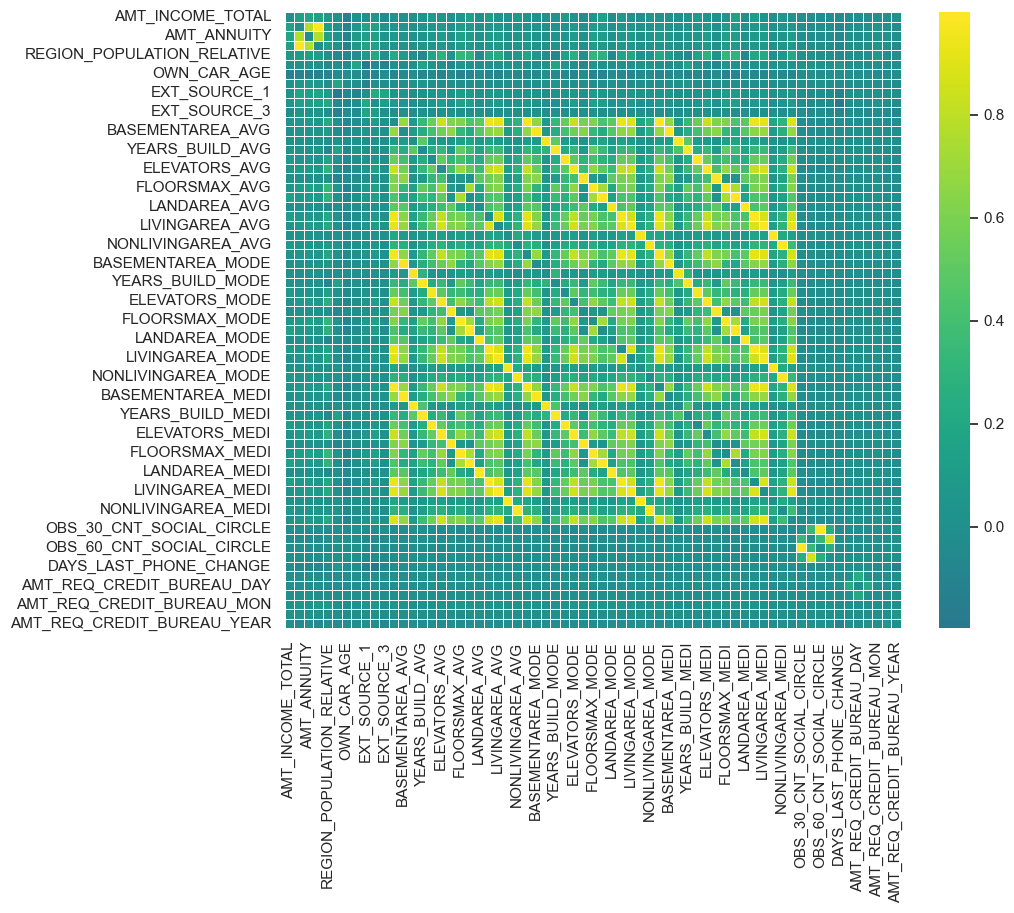

0

In [19]:
get_corr_matrix(dataset = pd_loan_train[list_var_continuous], 
                metodo='pearson', size_figure=[10,8])

En la matriz de correlación se observan varias correlaciones de Pearson cercanas o iguales a 1, lo que indica que algunas variables están perfectamente correlacionadas. Esto puede deberse a la existencia de variables redundantes o derivadas de otras, lo que podría generar problemas de multicolinealidad en modelos estadísticos. Es recomendable revisar estas variables y, en caso de ser necesario, eliminar las que sean idénticas o altamente correlacionadas para evitar distorsiones en los resultados del modelo.

In [20]:
corr = pd_loan_train[list_var_continuous].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.6]

level_0                       level_1  correlation
3694      OBS_60_CNT_SOCIAL_CIRCLE      OBS_30_CNT_SOCIAL_CIRCLE     0.998498
2744              YEARS_BUILD_MEDI               YEARS_BUILD_AVG     0.998480
3074                FLOORSMIN_MEDI                 FLOORSMIN_AVG     0.997218
3008                FLOORSMAX_MEDI                 FLOORSMAX_AVG     0.996977
2942                ENTRANCES_MEDI                 ENTRANCES_AVG     0.996884
2876                ELEVATORS_MEDI                 ELEVATORS_AVG     0.996026
2810               COMMONAREA_MEDI                COMMONAREA_AVG     0.995566
3272               LIVINGAREA_MEDI                LIVINGAREA_AVG     0.995388
2612             BASEMENTAREA_MEDI              BASEMENTAREA_AVG     0.994972
2546               APARTMENTS_MEDI                APARTMENTS_AVG     0.994890
3206         LIVINGAPARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.993515
2678  YEARS_BEGINEXPLUATATION_MEDI   YEARS_BEGINEXPLUATATION_AVG     0.993382
3140                 LANDAREA_MEDI                  LANDAREA_AVG     0.990689
3404            NONLIVINGAREA_MEDI             NONLIVINGAREA_AVG     0.989493
2758              YEARS_BUILD_MEDI              YEARS_BUILD_MODE     0.989490
1834              YEARS_BUILD_MODE               YEARS_BUILD_AVG     0.989383
3338      NONLIVINGAPARTMENTS_MEDI       NONLIVINGAPARTMENTS_AVG     0.988915
3088                FLOORSMIN_MEDI                FLOORSMIN_MODE     0.988121
3022                FLOORSMAX_MEDI                FLOORSMAX_MODE     0.987859
196                AMT_GOODS_PRICE                    AMT_CREDIT     0.987028
2164                FLOORSMIN_MODE                 FLOORSMIN_AVG     0.985501
2098                FLOORSMAX_MODE                 FLOORSMAX_AVG     0.985307
2890                ELEVATORS_MEDI                ELEVATORS_MODE     0.982507
2956                ENTRANCES_MEDI                ENTRANCES_MODE     0.980636
3154                 LANDAREA_MEDI                 LANDAREA_MODE     0.980086
2824               COMMONAREA_MEDI               COMMONAREA_MODE     0.978585
1966                ELEVATORS_MODE                 ELEVATORS_AVG     0.978504
2032                ENTRANCES_MODE                 ENTRANCES_AVG     0.977752
2626             BASEMENTAREA_MEDI             BASEMENTAREA_MODE     0.977507
2560               APARTMENTS_MEDI               APARTMENTS_MODE     0.976882
3418            NONLIVINGAREA_MEDI            NONLIVINGAREA_MODE     0.975851
3352      NONLIVINGAPARTMENTS_MEDI      NONLIVINGAPARTMENTS_MODE     0.975829
1900               COMMONAREA_MODE                COMMONAREA_AVG     0.975696
3220         LIVINGAPARTMENTS_MEDI         LIVINGAPARTMENTS_MODE     0.975206
3286               LIVINGAREA_MEDI               LIVINGAREA_MODE     0.974256
1702             BASEMENTAREA_MODE              BASEMENTAREA_AVG     0.973761
1636               APARTMENTS_MODE                APARTMENTS_AVG     0.972757
2230                 LANDAREA_MODE                  LANDAREA_AVG     0.972270
2362               LIVINGAREA_MODE                LIVINGAREA_AVG     0.971495
1768  YEARS_BEGINEXPLUATATION_MODE   YEARS_BEGINEXPLUATATION_AVG     0.970595
2296         LIVINGAPARTMENTS_MODE          LIVINGAPARTMENTS_AVG     0.969416
2494            NONLIVINGAREA_MODE             NONLIVINGAREA_AVG     0.965026
2428      NONLIVINGAPARTMENTS_MODE       NONLIVINGAPARTMENTS_AVG     0.964931
2692  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BEGINEXPLUATATION_MODE     0.961011
1376          LIVINGAPARTMENTS_AVG                APARTMENTS_AVG     0.943873
3224         LIVINGAPARTMENTS_MEDI               APARTMENTS_MEDI     0.942700
3196         LIVINGAPARTMENTS_MEDI                APARTMENTS_AVG     0.941100
2300         LIVINGAPARTMENTS_MODE               APARTMENTS_MODE     0.938834
2556               APARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.935462
2570               APARTMENTS_MEDI         LIVINGAPARTMENTS_MODE     0.932595
2286         LIVINGAPARTMENTS_MODE               

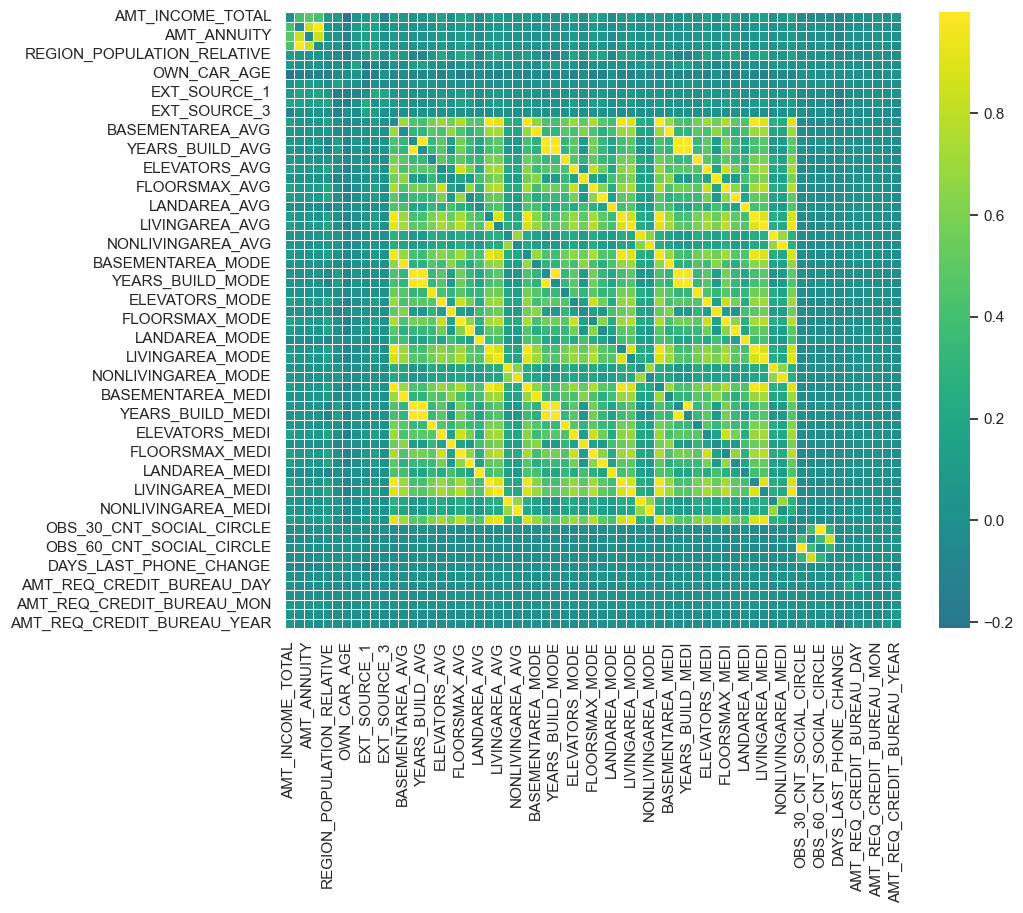

0

In [21]:
get_corr_matrix(dataset = pd_loan_train[list_var_continuous], 
                metodo='spearman', size_figure=[10,8])

También hemos hecho la matriz de spearman. Ambas matrices proporcionan resultados muy parecidos, por lo que llegamos a la conclusión de que es necesario realizar una simplificación de las variables para evitar problemas en el modelado, ya que muchas de nuestras variables no nos están aportando un valor añadido y nos hace el trabajo más complejo.

In [22]:
corr = pd_loan_train[list_var_continuous].corr('spearman')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) 
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.6]

level_0                       level_1  correlation
2744              YEARS_BUILD_MEDI               YEARS_BUILD_AVG     0.998428
2678  YEARS_BEGINEXPLUATATION_MEDI   YEARS_BEGINEXPLUATATION_AVG     0.997466
3694      OBS_60_CNT_SOCIAL_CIRCLE      OBS_30_CNT_SOCIAL_CIRCLE     0.997344
3074                FLOORSMIN_MEDI                 FLOORSMIN_AVG     0.996217
3206         LIVINGAPARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.996197
3140                 LANDAREA_MEDI                  LANDAREA_AVG     0.996097
2810               COMMONAREA_MEDI                COMMONAREA_AVG     0.995745
3272               LIVINGAREA_MEDI                LIVINGAREA_AVG     0.995526
2546               APARTMENTS_MEDI                APARTMENTS_AVG     0.995280
3008                FLOORSMAX_MEDI                 FLOORSMAX_AVG     0.994909
2612             BASEMENTAREA_MEDI              BASEMENTAREA_AVG     0.994903
2942                ENTRANCES_MEDI                 ENTRANCES_AVG     0.993446
2876                ELEVATORS_MEDI                 ELEVATORS_AVG     0.990981
2758              YEARS_BUILD_MEDI              YEARS_BUILD_MODE     0.988085
1834              YEARS_BUILD_MODE               YEARS_BUILD_AVG     0.987839
923                YEARS_BUILD_AVG   YEARS_BEGINEXPLUATATION_AVG     0.987054
3022                FLOORSMAX_MEDI                FLOORSMAX_MODE     0.986370
2771              YEARS_BUILD_MEDI  YEARS_BEGINEXPLUATATION_MEDI     0.985982
3088                FLOORSMIN_MEDI                FLOORSMIN_MODE     0.985881
2743              YEARS_BUILD_MEDI   YEARS_BEGINEXPLUATATION_AVG     0.985650
2692  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BEGINEXPLUATATION_MODE     0.985505
1768  YEARS_BEGINEXPLUATATION_MODE   YEARS_BEGINEXPLUATATION_AVG     0.985173
196                AMT_GOODS_PRICE                    AMT_CREDIT     0.984943
2679  YEARS_BEGINEXPLUATATION_MEDI               YEARS_BUILD_AVG     0.984562
2164                FLOORSMIN_MODE                 FLOORSMIN_AVG     0.982143
3338      NONLIVINGAPARTMENTS_MEDI       NONLIVINGAPARTMENTS_AVG     0.981957
2098                FLOORSMAX_MODE                 FLOORSMAX_AVG     0.981609
3404            NONLIVINGAREA_MEDI             NONLIVINGAREA_AVG     0.981065
1847              YEARS_BUILD_MODE  YEARS_BEGINEXPLUATATION_MODE     0.980198
2890                ELEVATORS_MEDI                ELEVATORS_MODE     0.977569
1833              YEARS_BUILD_MODE   YEARS_BEGINEXPLUATATION_AVG     0.975319
2693  YEARS_BEGINEXPLUATATION_MEDI              YEARS_BUILD_MODE     0.974900
1376          LIVINGAPARTMENTS_AVG                APARTMENTS_AVG     0.973931
3220         LIVINGAPARTMENTS_MEDI         LIVINGAPARTMENTS_MODE     0.973522
3224         LIVINGAPARTMENTS_MEDI               APARTMENTS_MEDI     0.971352
3154                 LANDAREA_MEDI                 LANDAREA_MODE     0.970759
3196         LIVINGAPARTMENTS_MEDI                APARTMENTS_AVG     0.970180
2824               COMMONAREA_MEDI               COMMONAREA_MODE     0.970113
2560               APARTMENTS_MEDI               APARTMENTS_MODE     0.970000
2296         LIVINGAPARTMENTS_MODE          LIVINGAPARTMENTS_AVG     0.969626
2757              YEARS_BUILD_MEDI  YEARS_BEGINEXPLUATATION_MODE     0.969480
1769  YEARS_BEGINEXPLUATATION_MODE               YEARS_BUILD_AVG     0.969186
3286               LIVINGAREA_MEDI               LIVINGAREA_MODE     0.969180
1966                ELEVATORS_MODE                 ELEVATORS_AVG     0.968642
2556               APARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.968240
2230                 LANDAREA_MODE                  LANDAREA_AVG     0.967052
1636               APARTMENTS_MODE                APARTMENTS_AVG     0.964885
2956                ENTRANCES_MEDI                ENTRANCES_MODE     0.964759
1900               COMMONAREA_MODE                COMMONAREA_AVG     0.964737
2362               LIVINGAREA_MODE                LIVINGAREA_AVG     0.964263
2626             BASEMENTAREA_MEDI             BA

TRATAMIENTO DE LOS VALORES NULOS

In [23]:
def get_percent_null_values_target(pd_loan, list_var_continuous, target):

    pd_final = pd.DataFrame()
    for i in list_var_continuous:
        if pd_loan[i].isnull().sum() > 0:
            pd_concat_percent = pd.DataFrame(pd_loan[target][pd_loan[i].isnull()]
                                             .value_counts(normalize=True).reset_index()).T

            # Verifica cuántas columnas tiene pd_concat_percent antes de asignarlas
            if pd_concat_percent.shape[1] >= 2:
                pd_concat_percent.columns = [pd_concat_percent.iloc[0, 0],
                                             pd_concat_percent.iloc[0, 1]]
            elif pd_concat_percent.shape[1] == 1:
                pd_concat_percent.columns = [pd_concat_percent.iloc[0, 0]]

            pd_concat_percent = pd_concat_percent.drop(target, axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_null_values'] = pd_loan[i].isnull().sum()
            pd_concat_percent['porcentaje_sum_null_values'] = pd_loan[i].isnull().sum() / pd_loan.shape[0]
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)

    if pd_final.empty:
        print('No existen variables con valores nulos')

    return pd_final



In [24]:
get_percent_null_values_target(pd_loan_train, list_var_continuous, target='TARGET')


0.0                      variable  sum_null_values  \
0   1.000000                   AMT_ANNUITY                6   
1   0.934498               AMT_GOODS_PRICE              229   
2   0.915038                   OWN_CAR_AGE           162531   
3   1.000000               CNT_FAM_MEMBERS                2   
4   0.914876                  EXT_SOURCE_1           138763   
5   0.922652                  EXT_SOURCE_2              543   
6   0.906754                  EXT_SOURCE_3            48828   
7   0.908370                APARTMENTS_AVG           124643   
8   0.910746              BASEMENTAREA_AVG           143736   
9   0.907886   YEARS_BEGINEXPLUATATION_AVG           119787   
10  0.913042               YEARS_BUILD_AVG           163539   
11  0.914184                COMMONAREA_AVG           171857   
12  0.908915                 ELEVATORS_AVG           130922   
13  0.908148                 ENTRANCES_AVG           123633   
14  0.908045                 FLOORSMAX_AVG           122179   
15  0.913584                 FLOORSMIN_AVG           166856   
16  0.911689                  LANDAREA_AVG           145825   
17  0.913681          LIVINGAPARTMENTS_AVG           168063   
18  0.908475                LIVINGAREA_AVG           123256   
19  0.914042       NONLIVINGAPARTMENTS_AVG           170757   
20  0.909545             NONLIVINGAREA_AVG           135493   
21  0.908370               APARTMENTS_MODE           124643   
22  0.910746             BASEMENTAREA_MODE           143736   
23  0.907886  YEARS_BEGINEXPLUATATION_MODE           119787   
24  0.913042              YEARS_BUILD_MODE           163539   
25  0.914184               COMMONAREA_MODE           171857   
26  0.908915                ELEVATORS_MODE           130922   
27  0.908148                ENTRANCES_MODE           123633   
28  0.908045                FLOORSMAX_MODE           122179   
29  0.913584                FLOORSMIN_MODE           166856   
30  0.911689                 LANDAREA_MODE           145825   
31  0.913681         LIVINGAPARTMENTS_MODE           168063   
32  0.908475               LIVINGAREA_MODE           123256   
33  0.914042      NONLIVINGAPARTMENTS_MODE           170757   
34  0.909545            NONLIVINGAREA_MODE           135493   
35  0.908370               APARTMENTS_MEDI           124643   
36  0.910746             BASEMENTAREA_MEDI           143736   
37  0.907886  YEARS_BEGINEXPLUATATION_MEDI           119787   
38  0.913042              YEARS_BUILD_MEDI           163539   
39  0.914184               COMMONAREA_MEDI           171857   
40  0.908915                ELEVATORS_MEDI           130922   
41  0.908148                ENTRANCES_MEDI           123633   
42  0.908045                FLOORSMAX_MEDI           122179   
43  0.913584                FLOORSMIN_MEDI           166856   
44  0.911689                 LANDAREA_MEDI           145825   
45  0.913681         LIVINGAPARTMENTS_MEDI           168063   
46  0.908475               LIVINGAREA_MEDI           123256   
47  0.914042      NONLIVINGAPARTMENTS_MEDI           170757   
48  0.909545            NONLIVINGAREA_MEDI           135493   
49  0.907624                TOTALAREA_MODE           118526   
50  0.963592      OBS_30_CNT_SOCIAL_CIRCLE              824   
51  0.963592      DEF_30_CNT_SOCIAL_CIRCLE              824   
52  0.963592      OBS_60_CNT_SOCIAL_CIRCLE              824   
53  0.963592      DEF_60_CNT_SOCIAL_CIRCLE              824   
54  0.896084    AMT_REQ_CREDIT_BUREAU_HOUR            33248   
55  0.896084     AMT_REQ_CREDIT_BUREAU_DAY            33248   
56  0.896084    AMT_REQ_CREDIT_BUREAU_WEEK            33248   
57  0.896084     AMT_REQ_CREDIT_BUREAU_MON            33248   
58  0.896084     AMT_REQ_CREDIT_BUREAU_QRT            33248   
59  0.896084    AMT_REQ_CREDIT_BUREAU_YEAR            33248   

    porcentaje_sum_null_values       1.0  
0                     0.000024       NaN  
1                     0.000931  0.065502  
2                     0.660674  0.08

Hemos decidido que nuestro umbral de valores nulos se situará en el 50%, es decir, sólo usaremos aquellas variables que cuenten con menos de un 50% de valores nulos. Haciendo este filtrado, creamos un nuevo df llamado pd_loan_train_filtered.

In [25]:

threshold = 0.5
list_vars_not_null = list(pd_null_columnas[pd_null_columnas['porcentaje_columnas'] < threshold].index)
pd_loan_train_filtered = pd_loan_train.loc[:, list_vars_not_null]

print(pd_loan_train_filtered)

            FLOORSMAX_MEDI  FLOORSMAX_AVG  FLOORSMAX_MODE  \
SK_ID_CURR                                                  
429844                 NaN            NaN             NaN   
259562                 NaN            NaN             NaN   
188975                 NaN            NaN             NaN   
254199              0.7083         0.6917          0.6250   
332686              0.3333         0.3333          0.3333   
...                    ...            ...             ...   
191213              0.3333         0.3333          0.3333   
383329                 NaN            NaN             NaN   
177037                 NaN            NaN             NaN   
358151              0.4583         0.4583          0.4583   
277125              0.3333         0.3333          0.3333   

            YEARS_BEGINEXPLUATATION_MEDI  YEARS_BEGINEXPLUATATION_MODE  \
SK_ID_CURR                                                               
429844                               NaN                  

In [26]:
pd_loan_train['AMT_GOODS_PRICE'].fillna(pd_loan_train['AMT_GOODS_PRICE'].median(), inplace=True)
pd_loan_train['AMT_ANNUITY'].fillna(pd_loan_train['AMT_ANNUITY'].median(), inplace=True)


C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\3300765175.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\Guille\AppData\Local\Temp\ipykernel_19736\3300765175.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

TRATAMIENTO VARIABLES CATEGORICAS

In [37]:
list_var_cat

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

OPCIÓN 2

In [38]:
pd_loan[list_var_continuous] = pd_loan[list_var_continuous].apply(lambda x: x.fillna(x.median()))

In [39]:
confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train["TARGET"])
print(confusion_matrix)
cramers_v(confusion_matrix.values)

TARGET       0      1
TARGET               
0       226148      0
1            0  19860


0.9999726127135284

In [40]:
confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train["TARGET"])
cramers_v(confusion_matrix.values)

0.9999726127135284

In [41]:
confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train["OWN_CAR_AGE"])
cramers_v(confusion_matrix.values)

0.06001203138415476

In [42]:
pd_loan_train[list_var_cat] = pd_loan_train[list_var_cat].astype("object").fillna("SIN VALOR").astype("category")
pd_loan_test[list_var_cat] = pd_loan_test[list_var_cat].astype("object").fillna("SIN VALOR").astype("category")

print(pd_loan_test)

           NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
SK_ID_CURR                                                               
112958             Cash loans           F            N               N   
238225             Cash loans           F            N               Y   
269335             Cash loans           F            N               Y   
450836             Cash loans           M            Y               Y   
340566        Revolving loans           F            Y               Y   
...                       ...         ...          ...             ...   
235730             Cash loans           F            N               N   
367911             Cash loans           M            Y               N   
302585             Cash loans           M            Y               N   
102961             Cash loans           F            N               Y   
125815             Cash loans           M            N               Y   

            CNT_CHILDREN  AMT_INCOME_

In [43]:
pd_loan_train.to_csv("../data/train_pd_data_preprocessing_missing_outlier.csv")
pd_loan_test.to_csv("../data/test_pd_data_preprocessing_missing_outlier.csv")